In [1]:
from keras.models import Model
from keras.layers import Input, Dropout,MaxPooling2D,Conv2D,UpSampling2D,concatenate
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.optimizers import Adam
import numpy as np
import datetime
import os
import skimage.io as io
from skimage.io import imread, imsave, imshow
import matplotlib.pyplot as plt
from glob import glob
import math
import random 

Using TensorFlow backend.


In [2]:
img = np.load("D:/QLY/denoise/denoise/train-images.npy")
test_tem_path = 'D:/QLY/denoise/Confocal_FISH/Confocal_FISH/test'
monitor_path = 'D:/QLY/denoise/Confocal_FISH/Confocal_FISH/monitor'
train_path = ("D:/QLY/denoise/zebrafish/train")

In [3]:
#show,用于展示图片
def readtif(path):
    image_arr = []
    for (root, dirs, files) in os.walk(path):
        for j, Ufile in enumerate(files):
            img_path = os.path.join(root, Ufile)
            image = np.array(imread(img_path)).astype( 'float32' )
            image = np.squeeze(image)
            image_arr.append(image)
        image_arr = np.array(image_arr)
    return image_arr

def drawDigit(position, image, title):
    plt.subplot(*position)
    plt.imshow(image, cmap = 'gray')
    plt.axis('off')
    plt.title(title, fontsize=10, pad=1)
 

#用于展示batchsize个图片
def batchDraw(path, batch_size):
    image_arr = readtif(path)
    selected_index = random.sample(range(image_arr.shape[0]), k = batch_size)
    images = image_arr[selected_index]
    image_number = images.shape[0]
    row_number = math.ceil(image_number ** 0.5)
    column_number = row_number
    plt.figure(figsize=(row_number, column_number))
    for i in range(row_number):
        for j in range(column_number):
            index = i * column_number + j
            if index < image_number:
                position = (row_number, column_number, index+1)
                image = images[index]
                title = '%d' %(index + 1)
                drawDigit(position, image, title)


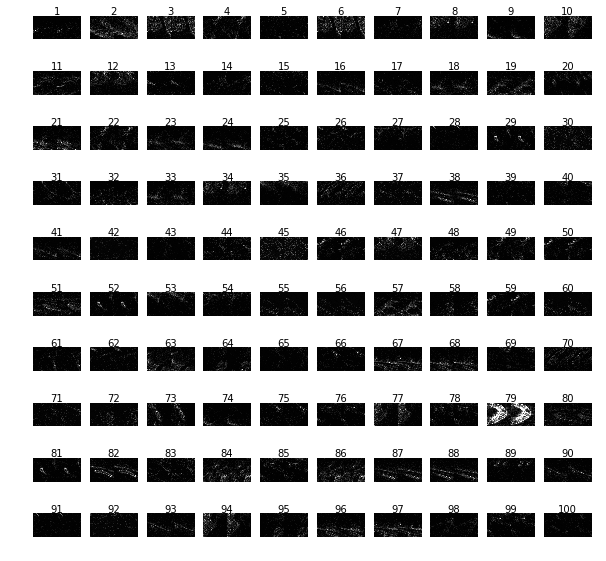

In [4]:
batchDraw(train_path, 100)

In [5]:
def unet(pretrained_weights = None,input_size = (512,512,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization(momentum=0.8)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization(momentum=0.8)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization(momentum=0.8)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization(momentum=0.8)(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = BatchNormalization(momentum=0.8)(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6 = BatchNormalization(momentum=0.8)(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7 = BatchNormalization(momentum=0.8)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = BatchNormalization(momentum=0.8)(conv8)
    
    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = BatchNormalization(momentum=0.8)(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'mse', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

In [6]:
def gen_traindata(img, batch_size):
    size = img.shape
    x_trains = []
    y_trains = []
    imgs_A = np.zeros((batch_size, size[0], size[1], 1))
    imgs_B = np.zeros((batch_size, size[0], size[1], 1))
    for j in range(size[3]):
        for jj in range(size[2]):
            a = np.random.randint(size[2], size=1)
            b = np.random.randint(size[2], size=1)
            imga = img[:, :, a, j]
            imgb = img[:, :, b, j]
            imga = np.squeeze(imga)
            imgb = np.squeeze(imgb)

            x_trains.append(imga)
            y_trains.append(imgb)
    x_train = np.array(x_trains)
    x_train = np.squeeze(x_train)
    x_train = np.transpose(x_train, [1, 2, 0])
    y_train = np.array(y_trains)
    y_train = np.squeeze(y_train)
    y_train = np.transpose(y_train, [1, 2, 0])
    batch_num = int(len(x_train) / batch_size)
    size1 = x_train.shape
    for batch in range(batch_num):
        imgs_As = []
        imgs_Bs = []
        for i in range(batch_size):
            a = np.random.randint(size1[2], size = 1)
            X_train = x_train[:, :, a]
            Y_train = y_train[:, :, a]
            X_train = np.squeeze(X_train)
            Y_train = np.squeeze(Y_train)
            imgs_As.append(X_train)
            imgs_Bs.append(Y_train)
        imgs_As = np.array(imgs_As) / 255.
        imgs_Bs = np.array(imgs_Bs) / 255.
        imgs_A[:, :, :, 0] = imgs_As
        imgs_B[:, :, :, 0] = imgs_Bs
        yield imgs_A, imgs_B

In [7]:
def test_prepro(path):
    image_arr = []
    for(root, dirs, files) in os.walk(path):
        for j, Ufile in enumerate(files):
            img_path = os.path.join(root, Ufile)
            image = np.array(imread(img_path))
            image = image / 255
            image = image.astype( 'float32' )
            image = image.reshape(image.shape[0], image.shape[1], 1)
            image_arr.append(image)
        image_arr = np.array(image_arr)
    return image_arr       

In [8]:
def saveResult(e, batch_size, batches, save_path, image_arr):
    for p, item in enumerate(image_arr):
        item = item - np.min(item)
        item = item / np.max(item)
        item = item * 255
        #io.imsave(os.path.join(save_path, "%d.tif"%(e * batch_size + batches / 10)), item.astype('uint8'))
        io.imsave(os.path.join(save_path, "%d_%d.tif"%(e ,batches)), item.astype(np.uint8))

In [9]:
def monitor(e, batch_size, batches, model, testpath, savepath):
    if batches % 10 == 0:
        test_arr = test_prepro(testpath)
        predict_tem = model.predict(test_arr)
        saveResult(e, batch_size, batches, savepath, predict_tem)

In [10]:
def draw_loss(x, y, path):
    plt.plot(x, y, c = 'g')
    plt.savefig(path, dpi = 100)
    plt.show()

[Epoch 0/100] [Batch 1/500] [loss: 0.218245] time: 0:00:27.802720
[Epoch 0/100] [Batch 2/500] [loss: 0.186627] time: 0:00:28.125177
[Epoch 0/100] [Batch 3/500] [loss: 0.186788] time: 0:00:28.443213
[Epoch 0/100] [Batch 4/500] [loss: 0.176152] time: 0:00:28.765071
[Epoch 0/100] [Batch 5/500] [loss: 0.157150] time: 0:00:29.082410
[Epoch 0/100] [Batch 6/500] [loss: 0.162314] time: 0:00:29.390226
[Epoch 0/100] [Batch 7/500] [loss: 0.159931] time: 0:00:29.710701
[Epoch 0/100] [Batch 8/500] [loss: 0.187813] time: 0:00:30.020023
[Epoch 0/100] [Batch 9/500] [loss: 0.176370] time: 0:00:30.335112
[Epoch 0/100] [Batch 10/500] [loss: 0.163333] time: 0:00:30.652858
[Epoch 0/100] [Batch 11/500] [loss: 0.178078] time: 0:00:31.778931
[Epoch 0/100] [Batch 12/500] [loss: 0.126979] time: 0:00:32.098282
[Epoch 0/100] [Batch 13/500] [loss: 0.165098] time: 0:00:32.419634
[Epoch 0/100] [Batch 14/500] [loss: 0.152032] time: 0:00:32.740487
[Epoch 0/100] [Batch 15/500] [loss: 0.151396] time: 0:00:33.058454
[Epo

[Epoch 0/100] [Batch 124/500] [loss: 0.150717] time: 0:01:08.367650
[Epoch 0/100] [Batch 125/500] [loss: 0.145667] time: 0:01:08.689002
[Epoch 0/100] [Batch 126/500] [loss: 0.140246] time: 0:01:09.006346
[Epoch 0/100] [Batch 127/500] [loss: 0.144346] time: 0:01:09.319699
[Epoch 0/100] [Batch 128/500] [loss: 0.145141] time: 0:01:09.644435
[Epoch 0/100] [Batch 129/500] [loss: 0.130030] time: 0:01:09.961582
[Epoch 0/100] [Batch 130/500] [loss: 0.125441] time: 0:01:10.271823
[Epoch 0/100] [Batch 131/500] [loss: 0.148207] time: 0:01:10.638905
[Epoch 0/100] [Batch 132/500] [loss: 0.105733] time: 0:01:10.955512
[Epoch 0/100] [Batch 133/500] [loss: 0.151670] time: 0:01:11.259687
[Epoch 0/100] [Batch 134/500] [loss: 0.137224] time: 0:01:11.576032
[Epoch 0/100] [Batch 135/500] [loss: 0.131096] time: 0:01:11.892991
[Epoch 0/100] [Batch 136/500] [loss: 0.123944] time: 0:01:12.214094
[Epoch 0/100] [Batch 137/500] [loss: 0.132063] time: 0:01:12.534671
[Epoch 0/100] [Batch 138/500] [loss: 0.150365] t

[Epoch 0/100] [Batch 245/500] [loss: 0.098934] time: 0:01:47.451980
[Epoch 0/100] [Batch 246/500] [loss: 0.105020] time: 0:01:47.769085
[Epoch 0/100] [Batch 247/500] [loss: 0.136127] time: 0:01:48.086389
[Epoch 0/100] [Batch 248/500] [loss: 0.102128] time: 0:01:48.407636
[Epoch 0/100] [Batch 249/500] [loss: 0.106631] time: 0:01:48.726183
[Epoch 0/100] [Batch 250/500] [loss: 0.104142] time: 0:01:49.040216
[Epoch 0/100] [Batch 251/500] [loss: 0.137047] time: 0:01:49.428505
[Epoch 0/100] [Batch 252/500] [loss: 0.132056] time: 0:01:49.750219
[Epoch 0/100] [Batch 253/500] [loss: 0.137359] time: 0:01:50.071272
[Epoch 0/100] [Batch 254/500] [loss: 0.134997] time: 0:01:50.385569
[Epoch 0/100] [Batch 255/500] [loss: 0.124715] time: 0:01:50.705469
[Epoch 0/100] [Batch 256/500] [loss: 0.101773] time: 0:01:51.025755
[Epoch 1/100] [Batch 1/500] [loss: 0.139951] time: 0:02:07.518929
[Epoch 1/100] [Batch 2/500] [loss: 0.123005] time: 0:02:07.830517
[Epoch 1/100] [Batch 3/500] [loss: 0.104806] time: 0

[Epoch 1/100] [Batch 112/500] [loss: 0.113770] time: 0:02:43.532037
[Epoch 1/100] [Batch 113/500] [loss: 0.132795] time: 0:02:43.843238
[Epoch 1/100] [Batch 114/500] [loss: 0.116416] time: 0:02:44.161585
[Epoch 1/100] [Batch 115/500] [loss: 0.088941] time: 0:02:44.481496
[Epoch 1/100] [Batch 116/500] [loss: 0.099784] time: 0:02:44.800355
[Epoch 1/100] [Batch 117/500] [loss: 0.129413] time: 0:02:45.103159
[Epoch 1/100] [Batch 118/500] [loss: 0.124332] time: 0:02:45.409129
[Epoch 1/100] [Batch 119/500] [loss: 0.136134] time: 0:02:45.729571
[Epoch 1/100] [Batch 120/500] [loss: 0.115606] time: 0:02:46.051886
[Epoch 1/100] [Batch 121/500] [loss: 0.134979] time: 0:02:46.433498
[Epoch 1/100] [Batch 122/500] [loss: 0.116263] time: 0:02:46.752252
[Epoch 1/100] [Batch 123/500] [loss: 0.118657] time: 0:02:47.073134
[Epoch 1/100] [Batch 124/500] [loss: 0.128353] time: 0:02:47.390528
[Epoch 1/100] [Batch 125/500] [loss: 0.127618] time: 0:02:47.712235
[Epoch 1/100] [Batch 126/500] [loss: 0.119144] t

[Epoch 1/100] [Batch 233/500] [loss: 0.110089] time: 0:03:22.690206
[Epoch 1/100] [Batch 234/500] [loss: 0.120530] time: 0:03:23.003039
[Epoch 1/100] [Batch 235/500] [loss: 0.127952] time: 0:03:23.308653
[Epoch 1/100] [Batch 236/500] [loss: 0.121448] time: 0:03:23.624320
[Epoch 1/100] [Batch 237/500] [loss: 0.111134] time: 0:03:23.942166
[Epoch 1/100] [Batch 238/500] [loss: 0.128857] time: 0:03:24.260673
[Epoch 1/100] [Batch 239/500] [loss: 0.120882] time: 0:03:24.580682
[Epoch 1/100] [Batch 240/500] [loss: 0.119780] time: 0:03:24.891267
[Epoch 1/100] [Batch 241/500] [loss: 0.118638] time: 0:03:25.263004
[Epoch 1/100] [Batch 242/500] [loss: 0.114023] time: 0:03:25.581683
[Epoch 1/100] [Batch 243/500] [loss: 0.119787] time: 0:03:25.900200
[Epoch 1/100] [Batch 244/500] [loss: 0.127421] time: 0:03:26.219045
[Epoch 1/100] [Batch 245/500] [loss: 0.122448] time: 0:03:26.535065
[Epoch 1/100] [Batch 246/500] [loss: 0.082720] time: 0:03:26.851956
[Epoch 1/100] [Batch 247/500] [loss: 0.125680] t

[Epoch 2/100] [Batch 100/500] [loss: 0.100326] time: 0:04:18.614393
[Epoch 2/100] [Batch 101/500] [loss: 0.089005] time: 0:04:18.991350
[Epoch 2/100] [Batch 102/500] [loss: 0.115016] time: 0:04:19.295741
[Epoch 2/100] [Batch 103/500] [loss: 0.105267] time: 0:04:19.612864
[Epoch 2/100] [Batch 104/500] [loss: 0.111317] time: 0:04:19.931818
[Epoch 2/100] [Batch 105/500] [loss: 0.085260] time: 0:04:20.248902
[Epoch 2/100] [Batch 106/500] [loss: 0.111853] time: 0:04:20.567750
[Epoch 2/100] [Batch 107/500] [loss: 0.114646] time: 0:04:20.883087
[Epoch 2/100] [Batch 108/500] [loss: 0.109768] time: 0:04:21.190548
[Epoch 2/100] [Batch 109/500] [loss: 0.085628] time: 0:04:21.508627
[Epoch 2/100] [Batch 110/500] [loss: 0.120866] time: 0:04:21.828477
[Epoch 2/100] [Batch 111/500] [loss: 0.109162] time: 0:04:22.215122
[Epoch 2/100] [Batch 112/500] [loss: 0.113356] time: 0:04:22.534226
[Epoch 2/100] [Batch 113/500] [loss: 0.099575] time: 0:04:22.851117
[Epoch 2/100] [Batch 114/500] [loss: 0.102653] t

[Epoch 2/100] [Batch 221/500] [loss: 0.112666] time: 0:04:58.065444
[Epoch 2/100] [Batch 222/500] [loss: 0.108787] time: 0:04:58.375285
[Epoch 2/100] [Batch 223/500] [loss: 0.105163] time: 0:04:58.696310
[Epoch 2/100] [Batch 224/500] [loss: 0.113338] time: 0:04:59.013873
[Epoch 2/100] [Batch 225/500] [loss: 0.099900] time: 0:04:59.329212
[Epoch 2/100] [Batch 226/500] [loss: 0.099675] time: 0:04:59.647005
[Epoch 2/100] [Batch 227/500] [loss: 0.108519] time: 0:04:59.968359
[Epoch 2/100] [Batch 228/500] [loss: 0.104352] time: 0:05:00.288272
[Epoch 2/100] [Batch 229/500] [loss: 0.099245] time: 0:05:00.597594
[Epoch 2/100] [Batch 230/500] [loss: 0.102640] time: 0:05:00.914996
[Epoch 2/100] [Batch 231/500] [loss: 0.078774] time: 0:05:01.295027
[Epoch 2/100] [Batch 232/500] [loss: 0.110461] time: 0:05:01.613745
[Epoch 2/100] [Batch 233/500] [loss: 0.090987] time: 0:05:01.921072
[Epoch 2/100] [Batch 234/500] [loss: 0.094497] time: 0:05:02.241446
[Epoch 2/100] [Batch 235/500] [loss: 0.081156] t

[Epoch 3/100] [Batch 87/500] [loss: 0.100040] time: 0:05:54.891272
[Epoch 3/100] [Batch 88/500] [loss: 0.098492] time: 0:05:55.211625
[Epoch 3/100] [Batch 89/500] [loss: 0.086505] time: 0:05:55.533777
[Epoch 3/100] [Batch 90/500] [loss: 0.110154] time: 0:05:55.851708
[Epoch 3/100] [Batch 91/500] [loss: 0.107385] time: 0:05:56.293743
[Epoch 3/100] [Batch 92/500] [loss: 0.101465] time: 0:05:56.611587
[Epoch 3/100] [Batch 93/500] [loss: 0.107293] time: 0:05:56.931938
[Epoch 3/100] [Batch 94/500] [loss: 0.109931] time: 0:05:57.241260
[Epoch 3/100] [Batch 95/500] [loss: 0.105853] time: 0:05:57.560611
[Epoch 3/100] [Batch 96/500] [loss: 0.109161] time: 0:05:57.881465
[Epoch 3/100] [Batch 97/500] [loss: 0.092807] time: 0:05:58.201313
[Epoch 3/100] [Batch 98/500] [loss: 0.104343] time: 0:05:58.519160
[Epoch 3/100] [Batch 99/500] [loss: 0.076012] time: 0:05:58.824471
[Epoch 3/100] [Batch 100/500] [loss: 0.098980] time: 0:05:59.141813
[Epoch 3/100] [Batch 101/500] [loss: 0.105073] time: 0:05:59.

[Epoch 3/100] [Batch 208/500] [loss: 0.095686] time: 0:06:34.312092
[Epoch 3/100] [Batch 209/500] [loss: 0.104330] time: 0:06:34.632766
[Epoch 3/100] [Batch 210/500] [loss: 0.084144] time: 0:06:34.952987
[Epoch 3/100] [Batch 211/500] [loss: 0.102921] time: 0:06:35.348261
[Epoch 3/100] [Batch 212/500] [loss: 0.094319] time: 0:06:35.661631
[Epoch 3/100] [Batch 213/500] [loss: 0.088617] time: 0:06:35.975192
[Epoch 3/100] [Batch 214/500] [loss: 0.097611] time: 0:06:36.296096
[Epoch 3/100] [Batch 215/500] [loss: 0.101583] time: 0:06:36.602899
[Epoch 3/100] [Batch 216/500] [loss: 0.097362] time: 0:06:36.920190
[Epoch 3/100] [Batch 217/500] [loss: 0.097685] time: 0:06:37.239078
[Epoch 3/100] [Batch 218/500] [loss: 0.089511] time: 0:06:37.554749
[Epoch 3/100] [Batch 219/500] [loss: 0.094732] time: 0:06:37.874098
[Epoch 3/100] [Batch 220/500] [loss: 0.098195] time: 0:06:38.191824
[Epoch 3/100] [Batch 221/500] [loss: 0.074860] time: 0:06:38.582676
[Epoch 3/100] [Batch 222/500] [loss: 0.100532] t

[Epoch 4/100] [Batch 74/500] [loss: 0.087746] time: 0:07:30.647064
[Epoch 4/100] [Batch 75/500] [loss: 0.096726] time: 0:07:30.958390
[Epoch 4/100] [Batch 76/500] [loss: 0.083383] time: 0:07:31.279744
[Epoch 4/100] [Batch 77/500] [loss: 0.089599] time: 0:07:31.599096
[Epoch 4/100] [Batch 78/500] [loss: 0.099003] time: 0:07:31.919946
[Epoch 4/100] [Batch 79/500] [loss: 0.081025] time: 0:07:32.240301
[Epoch 4/100] [Batch 80/500] [loss: 0.092582] time: 0:07:32.558647
[Epoch 4/100] [Batch 81/500] [loss: 0.084190] time: 0:07:32.942166
[Epoch 4/100] [Batch 82/500] [loss: 0.096393] time: 0:07:33.247979
[Epoch 4/100] [Batch 83/500] [loss: 0.096411] time: 0:07:33.564363
[Epoch 4/100] [Batch 84/500] [loss: 0.091612] time: 0:07:33.880330
[Epoch 4/100] [Batch 85/500] [loss: 0.089648] time: 0:07:34.199682
[Epoch 4/100] [Batch 86/500] [loss: 0.097665] time: 0:07:34.509508
[Epoch 4/100] [Batch 87/500] [loss: 0.098048] time: 0:07:34.828856
[Epoch 4/100] [Batch 88/500] [loss: 0.097515] time: 0:07:35.14

[Epoch 4/100] [Batch 195/500] [loss: 0.089179] time: 0:08:09.927487
[Epoch 4/100] [Batch 196/500] [loss: 0.092587] time: 0:08:10.243829
[Epoch 4/100] [Batch 197/500] [loss: 0.087760] time: 0:08:10.561673
[Epoch 4/100] [Batch 198/500] [loss: 0.062654] time: 0:08:10.879745
[Epoch 4/100] [Batch 199/500] [loss: 0.071782] time: 0:08:11.202681
[Epoch 4/100] [Batch 200/500] [loss: 0.087638] time: 0:08:11.524335
[Epoch 4/100] [Batch 201/500] [loss: 0.055624] time: 0:08:11.907853
[Epoch 4/100] [Batch 202/500] [loss: 0.078599] time: 0:08:12.226010
[Epoch 4/100] [Batch 203/500] [loss: 0.074286] time: 0:08:12.544860
[Epoch 4/100] [Batch 204/500] [loss: 0.090995] time: 0:08:12.864044
[Epoch 4/100] [Batch 205/500] [loss: 0.090941] time: 0:08:13.170449
[Epoch 4/100] [Batch 206/500] [loss: 0.062133] time: 0:08:13.482853
[Epoch 4/100] [Batch 207/500] [loss: 0.062743] time: 0:08:13.798696
[Epoch 4/100] [Batch 208/500] [loss: 0.092887] time: 0:08:14.116035
[Epoch 4/100] [Batch 209/500] [loss: 0.091046] t

[Epoch 5/100] [Batch 61/500] [loss: 0.081819] time: 0:09:06.461376
[Epoch 5/100] [Batch 62/500] [loss: 0.058121] time: 0:09:06.780766
[Epoch 5/100] [Batch 63/500] [loss: 0.089014] time: 0:09:07.101076
[Epoch 5/100] [Batch 64/500] [loss: 0.082773] time: 0:09:07.419964
[Epoch 5/100] [Batch 65/500] [loss: 0.070337] time: 0:09:07.738270
[Epoch 5/100] [Batch 66/500] [loss: 0.087486] time: 0:09:08.059627
[Epoch 5/100] [Batch 67/500] [loss: 0.086447] time: 0:09:08.377972
[Epoch 5/100] [Batch 68/500] [loss: 0.055649] time: 0:09:08.695819
[Epoch 5/100] [Batch 69/500] [loss: 0.057891] time: 0:09:09.003135
[Epoch 5/100] [Batch 70/500] [loss: 0.079834] time: 0:09:09.311990
[Epoch 5/100] [Batch 71/500] [loss: 0.085384] time: 0:09:09.706504
[Epoch 5/100] [Batch 72/500] [loss: 0.086737] time: 0:09:10.024350
[Epoch 5/100] [Batch 73/500] [loss: 0.087520] time: 0:09:10.339687
[Epoch 5/100] [Batch 74/500] [loss: 0.082812] time: 0:09:10.650517
[Epoch 5/100] [Batch 75/500] [loss: 0.084226] time: 0:09:10.96

[Epoch 5/100] [Batch 183/500] [loss: 0.075451] time: 0:09:45.836972
[Epoch 5/100] [Batch 184/500] [loss: 0.082262] time: 0:09:46.155315
[Epoch 5/100] [Batch 185/500] [loss: 0.082127] time: 0:09:46.460126
[Epoch 5/100] [Batch 186/500] [loss: 0.081275] time: 0:09:46.776969
[Epoch 5/100] [Batch 187/500] [loss: 0.074011] time: 0:09:47.091806
[Epoch 5/100] [Batch 188/500] [loss: 0.084573] time: 0:09:47.413233
[Epoch 5/100] [Batch 189/500] [loss: 0.076804] time: 0:09:47.733586
[Epoch 5/100] [Batch 190/500] [loss: 0.074141] time: 0:09:48.048421
[Epoch 5/100] [Batch 191/500] [loss: 0.074251] time: 0:09:48.439962
[Epoch 5/100] [Batch 192/500] [loss: 0.067918] time: 0:09:48.759853
[Epoch 5/100] [Batch 193/500] [loss: 0.071177] time: 0:09:49.075652
[Epoch 5/100] [Batch 194/500] [loss: 0.079960] time: 0:09:49.383470
[Epoch 5/100] [Batch 195/500] [loss: 0.074515] time: 0:09:49.704325
[Epoch 5/100] [Batch 196/500] [loss: 0.053990] time: 0:09:50.025232
[Epoch 5/100] [Batch 197/500] [loss: 0.071610] t

[Epoch 6/100] [Batch 49/500] [loss: 0.077507] time: 0:10:42.424378
[Epoch 6/100] [Batch 50/500] [loss: 0.075304] time: 0:10:42.738717
[Epoch 6/100] [Batch 51/500] [loss: 0.070484] time: 0:10:43.153319
[Epoch 6/100] [Batch 52/500] [loss: 0.074532] time: 0:10:43.473168
[Epoch 6/100] [Batch 53/500] [loss: 0.075118] time: 0:10:43.793521
[Epoch 6/100] [Batch 54/500] [loss: 0.071094] time: 0:10:44.113369
[Epoch 6/100] [Batch 55/500] [loss: 0.080016] time: 0:10:44.430713
[Epoch 6/100] [Batch 56/500] [loss: 0.071382] time: 0:10:44.740536
[Epoch 6/100] [Batch 57/500] [loss: 0.062759] time: 0:10:45.058883
[Epoch 6/100] [Batch 58/500] [loss: 0.061563] time: 0:10:45.380738
[Epoch 6/100] [Batch 59/500] [loss: 0.072136] time: 0:10:45.698588
[Epoch 6/100] [Batch 60/500] [loss: 0.077634] time: 0:10:46.019441
[Epoch 6/100] [Batch 61/500] [loss: 0.061140] time: 0:10:46.411022
[Epoch 6/100] [Batch 62/500] [loss: 0.077074] time: 0:10:46.729034
[Epoch 6/100] [Batch 63/500] [loss: 0.070584] time: 0:10:47.04

[Epoch 6/100] [Batch 171/500] [loss: 0.073556] time: 0:11:22.025803
[Epoch 6/100] [Batch 172/500] [loss: 0.075969] time: 0:11:22.335801
[Epoch 6/100] [Batch 173/500] [loss: 0.070104] time: 0:11:22.651634
[Epoch 6/100] [Batch 174/500] [loss: 0.071535] time: 0:11:22.968776
[Epoch 6/100] [Batch 175/500] [loss: 0.070824] time: 0:11:23.288679
[Epoch 6/100] [Batch 176/500] [loss: 0.075663] time: 0:11:23.606828
[Epoch 6/100] [Batch 177/500] [loss: 0.074619] time: 0:11:23.923171
[Epoch 6/100] [Batch 178/500] [loss: 0.063417] time: 0:11:24.242817
[Epoch 6/100] [Batch 179/500] [loss: 0.072477] time: 0:11:24.562449
[Epoch 6/100] [Batch 180/500] [loss: 0.066560] time: 0:11:24.883804
[Epoch 6/100] [Batch 181/500] [loss: 0.041423] time: 0:11:25.259936
[Epoch 6/100] [Batch 182/500] [loss: 0.074787] time: 0:11:25.577456
[Epoch 6/100] [Batch 183/500] [loss: 0.056249] time: 0:11:25.896875
[Epoch 6/100] [Batch 184/500] [loss: 0.070314] time: 0:11:26.205030
[Epoch 6/100] [Batch 185/500] [loss: 0.046964] t

[Epoch 7/100] [Batch 37/500] [loss: 0.054546] time: 0:12:17.609452
[Epoch 7/100] [Batch 38/500] [loss: 0.066071] time: 0:12:17.925779
[Epoch 7/100] [Batch 39/500] [loss: 0.070641] time: 0:12:18.243638
[Epoch 7/100] [Batch 40/500] [loss: 0.054786] time: 0:12:18.566009
[Epoch 7/100] [Batch 41/500] [loss: 0.067864] time: 0:12:18.990031
[Epoch 7/100] [Batch 42/500] [loss: 0.071150] time: 0:12:19.307877
[Epoch 7/100] [Batch 43/500] [loss: 0.065644] time: 0:12:19.624232
[Epoch 7/100] [Batch 44/500] [loss: 0.068327] time: 0:12:19.943630
[Epoch 7/100] [Batch 45/500] [loss: 0.068108] time: 0:12:20.263516
[Epoch 7/100] [Batch 46/500] [loss: 0.071017] time: 0:12:20.589382
[Epoch 7/100] [Batch 47/500] [loss: 0.069205] time: 0:12:20.909234
[Epoch 7/100] [Batch 48/500] [loss: 0.070793] time: 0:12:21.231335
[Epoch 7/100] [Batch 49/500] [loss: 0.066734] time: 0:12:21.543134
[Epoch 7/100] [Batch 50/500] [loss: 0.051852] time: 0:12:21.862709
[Epoch 7/100] [Batch 51/500] [loss: 0.056937] time: 0:12:22.27

[Epoch 7/100] [Batch 159/500] [loss: 0.064159] time: 0:12:57.448240
[Epoch 7/100] [Batch 160/500] [loss: 0.063604] time: 0:12:57.769008
[Epoch 7/100] [Batch 161/500] [loss: 0.059798] time: 0:12:58.159050
[Epoch 7/100] [Batch 162/500] [loss: 0.066618] time: 0:12:58.477201
[Epoch 7/100] [Batch 163/500] [loss: 0.059157] time: 0:12:58.795958
[Epoch 7/100] [Batch 164/500] [loss: 0.060899] time: 0:12:59.113597
[Epoch 7/100] [Batch 165/500] [loss: 0.061072] time: 0:12:59.430669
[Epoch 7/100] [Batch 166/500] [loss: 0.059096] time: 0:12:59.742584
[Epoch 7/100] [Batch 167/500] [loss: 0.063221] time: 0:13:00.059224
[Epoch 7/100] [Batch 168/500] [loss: 0.052922] time: 0:13:00.376063
[Epoch 7/100] [Batch 169/500] [loss: 0.064587] time: 0:13:00.693226
[Epoch 7/100] [Batch 170/500] [loss: 0.066769] time: 0:13:01.001751
[Epoch 7/100] [Batch 171/500] [loss: 0.051810] time: 0:13:01.377367
[Epoch 7/100] [Batch 172/500] [loss: 0.060890] time: 0:13:01.694208
[Epoch 7/100] [Batch 173/500] [loss: 0.064188] t

[Epoch 8/100] [Batch 24/500] [loss: 0.060672] time: 0:13:53.084098
[Epoch 8/100] [Batch 25/500] [loss: 0.059950] time: 0:13:53.410990
[Epoch 8/100] [Batch 26/500] [loss: 0.049331] time: 0:13:53.731101
[Epoch 8/100] [Batch 27/500] [loss: 0.060106] time: 0:13:54.052776
[Epoch 8/100] [Batch 28/500] [loss: 0.059878] time: 0:13:54.375072
[Epoch 8/100] [Batch 29/500] [loss: 0.060360] time: 0:13:54.692414
[Epoch 8/100] [Batch 30/500] [loss: 0.047571] time: 0:13:54.999071
[Epoch 8/100] [Batch 31/500] [loss: 0.051999] time: 0:13:55.399005
[Epoch 8/100] [Batch 32/500] [loss: 0.061691] time: 0:13:55.720303
[Epoch 8/100] [Batch 33/500] [loss: 0.058407] time: 0:13:56.039995
[Epoch 8/100] [Batch 34/500] [loss: 0.056909] time: 0:13:56.357903
[Epoch 8/100] [Batch 35/500] [loss: 0.063815] time: 0:13:56.677255
[Epoch 8/100] [Batch 36/500] [loss: 0.051074] time: 0:13:56.992090
[Epoch 8/100] [Batch 37/500] [loss: 0.053054] time: 0:13:57.300962
[Epoch 8/100] [Batch 38/500] [loss: 0.056551] time: 0:13:57.62

[Epoch 8/100] [Batch 146/500] [loss: 0.052888] time: 0:14:32.833962
[Epoch 8/100] [Batch 147/500] [loss: 0.061213] time: 0:14:33.141386
[Epoch 8/100] [Batch 148/500] [loss: 0.059430] time: 0:14:33.463307
[Epoch 8/100] [Batch 149/500] [loss: 0.046190] time: 0:14:33.782659
[Epoch 8/100] [Batch 150/500] [loss: 0.053342] time: 0:14:34.102490
[Epoch 8/100] [Batch 151/500] [loss: 0.053063] time: 0:14:34.488373
[Epoch 8/100] [Batch 152/500] [loss: 0.045870] time: 0:14:34.806740
[Epoch 8/100] [Batch 153/500] [loss: 0.056820] time: 0:14:35.126275
[Epoch 8/100] [Batch 154/500] [loss: 0.058763] time: 0:14:35.448519
[Epoch 8/100] [Batch 155/500] [loss: 0.036531] time: 0:14:35.769189
[Epoch 8/100] [Batch 156/500] [loss: 0.057349] time: 0:14:36.074034
[Epoch 8/100] [Batch 157/500] [loss: 0.060236] time: 0:14:36.391549
[Epoch 8/100] [Batch 158/500] [loss: 0.060002] time: 0:14:36.708768
[Epoch 8/100] [Batch 159/500] [loss: 0.058274] time: 0:14:37.018154
[Epoch 8/100] [Batch 160/500] [loss: 0.055018] t

[Epoch 9/100] [Batch 11/500] [loss: 0.034340] time: 0:15:28.814144
[Epoch 9/100] [Batch 12/500] [loss: 0.056091] time: 0:15:29.136699
[Epoch 9/100] [Batch 13/500] [loss: 0.051967] time: 0:15:29.457951
[Epoch 9/100] [Batch 14/500] [loss: 0.048071] time: 0:15:29.766738
[Epoch 9/100] [Batch 15/500] [loss: 0.057400] time: 0:15:30.087356
[Epoch 9/100] [Batch 16/500] [loss: 0.051264] time: 0:15:30.408714
[Epoch 9/100] [Batch 17/500] [loss: 0.055570] time: 0:15:30.727901
[Epoch 9/100] [Batch 18/500] [loss: 0.045120] time: 0:15:31.045598
[Epoch 9/100] [Batch 19/500] [loss: 0.055403] time: 0:15:31.361349
[Epoch 9/100] [Batch 20/500] [loss: 0.055910] time: 0:15:31.681201
[Epoch 9/100] [Batch 21/500] [loss: 0.056976] time: 0:15:32.066755
[Epoch 9/100] [Batch 22/500] [loss: 0.053099] time: 0:15:32.380346
[Epoch 9/100] [Batch 23/500] [loss: 0.042766] time: 0:15:32.687159
[Epoch 9/100] [Batch 24/500] [loss: 0.051056] time: 0:15:32.996483
[Epoch 9/100] [Batch 25/500] [loss: 0.046576] time: 0:15:33.30

[Epoch 9/100] [Batch 133/500] [loss: 0.032191] time: 0:16:08.571520
[Epoch 9/100] [Batch 134/500] [loss: 0.044954] time: 0:16:08.890326
[Epoch 9/100] [Batch 135/500] [loss: 0.054390] time: 0:16:09.207170
[Epoch 9/100] [Batch 136/500] [loss: 0.031332] time: 0:16:09.530533
[Epoch 9/100] [Batch 137/500] [loss: 0.051627] time: 0:16:09.852740
[Epoch 9/100] [Batch 138/500] [loss: 0.049482] time: 0:16:10.170607
[Epoch 9/100] [Batch 139/500] [loss: 0.038975] time: 0:16:10.490227
[Epoch 9/100] [Batch 140/500] [loss: 0.032451] time: 0:16:10.810419
[Epoch 9/100] [Batch 141/500] [loss: 0.053398] time: 0:16:11.203651
[Epoch 9/100] [Batch 142/500] [loss: 0.050392] time: 0:16:11.523504
[Epoch 9/100] [Batch 143/500] [loss: 0.054146] time: 0:16:11.844576
[Epoch 9/100] [Batch 144/500] [loss: 0.047814] time: 0:16:12.169853
[Epoch 9/100] [Batch 145/500] [loss: 0.054010] time: 0:16:12.491609
[Epoch 9/100] [Batch 146/500] [loss: 0.053590] time: 0:16:12.798670
[Epoch 9/100] [Batch 147/500] [loss: 0.050904] t

[Epoch 9/100] [Batch 254/500] [loss: 0.047649] time: 0:16:48.060599
[Epoch 9/100] [Batch 255/500] [loss: 0.042816] time: 0:16:48.373432
[Epoch 9/100] [Batch 256/500] [loss: 0.030174] time: 0:16:48.696766
[Epoch 10/100] [Batch 1/500] [loss: 0.040645] time: 0:17:05.450088
[Epoch 10/100] [Batch 2/500] [loss: 0.043145] time: 0:17:05.773353
[Epoch 10/100] [Batch 3/500] [loss: 0.027205] time: 0:17:06.093239
[Epoch 10/100] [Batch 4/500] [loss: 0.046328] time: 0:17:06.410106
[Epoch 10/100] [Batch 5/500] [loss: 0.045195] time: 0:17:06.727696
[Epoch 10/100] [Batch 6/500] [loss: 0.047917] time: 0:17:07.049888
[Epoch 10/100] [Batch 7/500] [loss: 0.043678] time: 0:17:07.367739
[Epoch 10/100] [Batch 8/500] [loss: 0.042486] time: 0:17:07.674253
[Epoch 10/100] [Batch 9/500] [loss: 0.047687] time: 0:17:08.007715
[Epoch 10/100] [Batch 10/500] [loss: 0.049011] time: 0:17:08.328557
[Epoch 10/100] [Batch 11/500] [loss: 0.050482] time: 0:17:08.713582
[Epoch 10/100] [Batch 12/500] [loss: 0.048135] time: 0:17

[Epoch 10/100] [Batch 119/500] [loss: 0.044809] time: 0:17:43.974126
[Epoch 10/100] [Batch 120/500] [loss: 0.044229] time: 0:17:44.293888
[Epoch 10/100] [Batch 121/500] [loss: 0.039360] time: 0:17:44.676933
[Epoch 10/100] [Batch 122/500] [loss: 0.048647] time: 0:17:44.998847
[Epoch 10/100] [Batch 123/500] [loss: 0.028245] time: 0:17:45.319139
[Epoch 10/100] [Batch 124/500] [loss: 0.043093] time: 0:17:45.636987
[Epoch 10/100] [Batch 125/500] [loss: 0.027532] time: 0:17:45.952766
[Epoch 10/100] [Batch 126/500] [loss: 0.040489] time: 0:17:46.269631
[Epoch 10/100] [Batch 127/500] [loss: 0.045213] time: 0:17:46.586515
[Epoch 10/100] [Batch 128/500] [loss: 0.039769] time: 0:17:46.896375
[Epoch 10/100] [Batch 129/500] [loss: 0.045516] time: 0:17:47.204512
[Epoch 10/100] [Batch 130/500] [loss: 0.028747] time: 0:17:47.526452
[Epoch 10/100] [Batch 131/500] [loss: 0.028342] time: 0:17:47.911857
[Epoch 10/100] [Batch 132/500] [loss: 0.047678] time: 0:17:48.220795
[Epoch 10/100] [Batch 133/500] [lo

[Epoch 10/100] [Batch 238/500] [loss: 0.041925] time: 0:18:22.552916
[Epoch 10/100] [Batch 239/500] [loss: 0.045771] time: 0:18:22.862944
[Epoch 10/100] [Batch 240/500] [loss: 0.024392] time: 0:18:23.179365
[Epoch 10/100] [Batch 241/500] [loss: 0.040251] time: 0:18:23.577696
[Epoch 10/100] [Batch 242/500] [loss: 0.044884] time: 0:18:23.898087
[Epoch 10/100] [Batch 243/500] [loss: 0.044480] time: 0:18:24.215329
[Epoch 10/100] [Batch 244/500] [loss: 0.039379] time: 0:18:24.534310
[Epoch 10/100] [Batch 245/500] [loss: 0.045040] time: 0:18:24.853083
[Epoch 10/100] [Batch 246/500] [loss: 0.041039] time: 0:18:25.162870
[Epoch 10/100] [Batch 247/500] [loss: 0.039228] time: 0:18:25.484488
[Epoch 10/100] [Batch 248/500] [loss: 0.043532] time: 0:18:25.803989
[Epoch 10/100] [Batch 249/500] [loss: 0.038684] time: 0:18:26.122295
[Epoch 10/100] [Batch 250/500] [loss: 0.044174] time: 0:18:26.438751
[Epoch 10/100] [Batch 251/500] [loss: 0.024970] time: 0:18:26.828958
[Epoch 10/100] [Batch 252/500] [lo

[Epoch 11/100] [Batch 103/500] [loss: 0.027356] time: 0:19:18.241388
[Epoch 11/100] [Batch 104/500] [loss: 0.033274] time: 0:19:18.560299
[Epoch 11/100] [Batch 105/500] [loss: 0.033795] time: 0:19:18.873377
[Epoch 11/100] [Batch 106/500] [loss: 0.041948] time: 0:19:19.185103
[Epoch 11/100] [Batch 107/500] [loss: 0.044070] time: 0:19:19.504536
[Epoch 11/100] [Batch 108/500] [loss: 0.024697] time: 0:19:19.821341
[Epoch 11/100] [Batch 109/500] [loss: 0.043417] time: 0:19:20.137773
[Epoch 11/100] [Batch 110/500] [loss: 0.040654] time: 0:19:20.455688
[Epoch 11/100] [Batch 111/500] [loss: 0.040377] time: 0:19:20.845941
[Epoch 11/100] [Batch 112/500] [loss: 0.038741] time: 0:19:21.164439
[Epoch 11/100] [Batch 113/500] [loss: 0.023572] time: 0:19:21.481725
[Epoch 11/100] [Batch 114/500] [loss: 0.034985] time: 0:19:21.799078
[Epoch 11/100] [Batch 115/500] [loss: 0.041066] time: 0:19:22.116165
[Epoch 11/100] [Batch 116/500] [loss: 0.043810] time: 0:19:22.434694
[Epoch 11/100] [Batch 117/500] [lo

[Epoch 11/100] [Batch 222/500] [loss: 0.038988] time: 0:19:57.301523
[Epoch 11/100] [Batch 223/500] [loss: 0.030091] time: 0:19:57.622248
[Epoch 11/100] [Batch 224/500] [loss: 0.038407] time: 0:19:57.940595
[Epoch 11/100] [Batch 225/500] [loss: 0.034342] time: 0:19:58.250443
[Epoch 11/100] [Batch 226/500] [loss: 0.032872] time: 0:19:58.573186
[Epoch 11/100] [Batch 227/500] [loss: 0.037691] time: 0:19:58.893910
[Epoch 11/100] [Batch 228/500] [loss: 0.041839] time: 0:19:59.198255
[Epoch 11/100] [Batch 229/500] [loss: 0.041978] time: 0:19:59.515466
[Epoch 11/100] [Batch 230/500] [loss: 0.038511] time: 0:19:59.832163
[Epoch 11/100] [Batch 231/500] [loss: 0.030533] time: 0:20:00.224747
[Epoch 11/100] [Batch 232/500] [loss: 0.040743] time: 0:20:00.541614
[Epoch 11/100] [Batch 233/500] [loss: 0.037451] time: 0:20:00.856748
[Epoch 11/100] [Batch 234/500] [loss: 0.041545] time: 0:20:01.173089
[Epoch 11/100] [Batch 235/500] [loss: 0.034084] time: 0:20:01.491212
[Epoch 11/100] [Batch 236/500] [lo

[Epoch 12/100] [Batch 87/500] [loss: 0.034202] time: 0:20:52.843372
[Epoch 12/100] [Batch 88/500] [loss: 0.031919] time: 0:20:53.162721
[Epoch 12/100] [Batch 89/500] [loss: 0.030816] time: 0:20:53.468714
[Epoch 12/100] [Batch 90/500] [loss: 0.028619] time: 0:20:53.774568
[Epoch 12/100] [Batch 91/500] [loss: 0.036785] time: 0:20:54.168625
[Epoch 12/100] [Batch 92/500] [loss: 0.031631] time: 0:20:54.481949
[Epoch 12/100] [Batch 93/500] [loss: 0.036728] time: 0:20:54.799155
[Epoch 12/100] [Batch 94/500] [loss: 0.039404] time: 0:20:55.115678
[Epoch 12/100] [Batch 95/500] [loss: 0.022094] time: 0:20:55.435769
[Epoch 12/100] [Batch 96/500] [loss: 0.031120] time: 0:20:55.748438
[Epoch 12/100] [Batch 97/500] [loss: 0.027991] time: 0:20:56.074352
[Epoch 12/100] [Batch 98/500] [loss: 0.030389] time: 0:20:56.397334
[Epoch 12/100] [Batch 99/500] [loss: 0.033891] time: 0:20:56.719147
[Epoch 12/100] [Batch 100/500] [loss: 0.034725] time: 0:20:57.043509
[Epoch 12/100] [Batch 101/500] [loss: 0.034743]

[Epoch 12/100] [Batch 206/500] [loss: 0.032920] time: 0:21:31.060455
[Epoch 12/100] [Batch 207/500] [loss: 0.027064] time: 0:21:31.372993
[Epoch 12/100] [Batch 208/500] [loss: 0.021102] time: 0:21:31.681210
[Epoch 12/100] [Batch 209/500] [loss: 0.037616] time: 0:21:31.999144
[Epoch 12/100] [Batch 210/500] [loss: 0.037015] time: 0:21:32.310268
[Epoch 12/100] [Batch 211/500] [loss: 0.035325] time: 0:21:32.677503
[Epoch 12/100] [Batch 212/500] [loss: 0.034245] time: 0:21:32.999223
[Epoch 12/100] [Batch 213/500] [loss: 0.033863] time: 0:21:33.309555
[Epoch 12/100] [Batch 214/500] [loss: 0.035546] time: 0:21:33.616874
[Epoch 12/100] [Batch 215/500] [loss: 0.034276] time: 0:21:33.922989
[Epoch 12/100] [Batch 216/500] [loss: 0.037441] time: 0:21:34.228786
[Epoch 12/100] [Batch 217/500] [loss: 0.028592] time: 0:21:34.545775
[Epoch 12/100] [Batch 218/500] [loss: 0.033789] time: 0:21:34.861829
[Epoch 12/100] [Batch 219/500] [loss: 0.030767] time: 0:21:35.181966
[Epoch 12/100] [Batch 220/500] [lo

[Epoch 13/100] [Batch 70/500] [loss: 0.034206] time: 0:22:26.475415
[Epoch 13/100] [Batch 71/500] [loss: 0.033825] time: 0:22:26.858946
[Epoch 13/100] [Batch 72/500] [loss: 0.025490] time: 0:22:27.175614
[Epoch 13/100] [Batch 73/500] [loss: 0.031944] time: 0:22:27.486288
[Epoch 13/100] [Batch 74/500] [loss: 0.019804] time: 0:22:27.806659
[Epoch 13/100] [Batch 75/500] [loss: 0.033964] time: 0:22:28.126008
[Epoch 13/100] [Batch 76/500] [loss: 0.028412] time: 0:22:28.447363
[Epoch 13/100] [Batch 77/500] [loss: 0.019896] time: 0:22:28.766714
[Epoch 13/100] [Batch 78/500] [loss: 0.031400] time: 0:22:29.075032
[Epoch 13/100] [Batch 79/500] [loss: 0.030410] time: 0:22:29.386267
[Epoch 13/100] [Batch 80/500] [loss: 0.032399] time: 0:22:29.704719
[Epoch 13/100] [Batch 81/500] [loss: 0.035246] time: 0:22:30.096638
[Epoch 13/100] [Batch 82/500] [loss: 0.020142] time: 0:22:30.419325
[Epoch 13/100] [Batch 83/500] [loss: 0.033461] time: 0:22:30.738202
[Epoch 13/100] [Batch 84/500] [loss: 0.033584] t

[Epoch 13/100] [Batch 190/500] [loss: 0.027177] time: 0:23:05.451112
[Epoch 13/100] [Batch 191/500] [loss: 0.031686] time: 0:23:05.844759
[Epoch 13/100] [Batch 192/500] [loss: 0.031559] time: 0:23:06.164582
[Epoch 13/100] [Batch 193/500] [loss: 0.026477] time: 0:23:06.483640
[Epoch 13/100] [Batch 194/500] [loss: 0.027280] time: 0:23:06.804495
[Epoch 13/100] [Batch 195/500] [loss: 0.033646] time: 0:23:07.118264
[Epoch 13/100] [Batch 196/500] [loss: 0.030210] time: 0:23:07.438002
[Epoch 13/100] [Batch 197/500] [loss: 0.029952] time: 0:23:07.755168
[Epoch 13/100] [Batch 198/500] [loss: 0.030833] time: 0:23:08.060979
[Epoch 13/100] [Batch 199/500] [loss: 0.031028] time: 0:23:08.382146
[Epoch 13/100] [Batch 200/500] [loss: 0.030115] time: 0:23:08.703107
[Epoch 13/100] [Batch 201/500] [loss: 0.032672] time: 0:23:09.084201
[Epoch 13/100] [Batch 202/500] [loss: 0.027524] time: 0:23:09.405892
[Epoch 13/100] [Batch 203/500] [loss: 0.028241] time: 0:23:09.714783
[Epoch 13/100] [Batch 204/500] [lo

[Epoch 14/100] [Batch 54/500] [loss: 0.029923] time: 0:24:00.893047
[Epoch 14/100] [Batch 55/500] [loss: 0.017151] time: 0:24:01.210263
[Epoch 14/100] [Batch 56/500] [loss: 0.028446] time: 0:24:01.529142
[Epoch 14/100] [Batch 57/500] [loss: 0.029292] time: 0:24:01.841472
[Epoch 14/100] [Batch 58/500] [loss: 0.030082] time: 0:24:02.165419
[Epoch 14/100] [Batch 59/500] [loss: 0.027837] time: 0:24:02.485405
[Epoch 14/100] [Batch 60/500] [loss: 0.027350] time: 0:24:02.805000
[Epoch 14/100] [Batch 61/500] [loss: 0.027779] time: 0:24:03.199185
[Epoch 14/100] [Batch 62/500] [loss: 0.029191] time: 0:24:03.516826
[Epoch 14/100] [Batch 63/500] [loss: 0.031268] time: 0:24:03.837459
[Epoch 14/100] [Batch 64/500] [loss: 0.016491] time: 0:24:04.160772
[Epoch 14/100] [Batch 65/500] [loss: 0.029656] time: 0:24:04.480812
[Epoch 14/100] [Batch 66/500] [loss: 0.027864] time: 0:24:04.789635
[Epoch 14/100] [Batch 67/500] [loss: 0.023998] time: 0:24:05.100960
[Epoch 14/100] [Batch 68/500] [loss: 0.027005] t

[Epoch 14/100] [Batch 174/500] [loss: 0.020873] time: 0:24:39.922855
[Epoch 14/100] [Batch 175/500] [loss: 0.025586] time: 0:24:40.239197
[Epoch 14/100] [Batch 176/500] [loss: 0.024569] time: 0:24:40.556573
[Epoch 14/100] [Batch 177/500] [loss: 0.025870] time: 0:24:40.868085
[Epoch 14/100] [Batch 178/500] [loss: 0.026776] time: 0:24:41.187371
[Epoch 14/100] [Batch 179/500] [loss: 0.027499] time: 0:24:41.504714
[Epoch 14/100] [Batch 180/500] [loss: 0.015521] time: 0:24:41.822077
[Epoch 14/100] [Batch 181/500] [loss: 0.028440] time: 0:24:42.217447
[Epoch 14/100] [Batch 182/500] [loss: 0.016110] time: 0:24:42.537180
[Epoch 14/100] [Batch 183/500] [loss: 0.028299] time: 0:24:42.854122
[Epoch 14/100] [Batch 184/500] [loss: 0.024416] time: 0:24:43.172041
[Epoch 14/100] [Batch 185/500] [loss: 0.019216] time: 0:24:43.491548
[Epoch 14/100] [Batch 186/500] [loss: 0.028188] time: 0:24:43.810788
[Epoch 14/100] [Batch 187/500] [loss: 0.021101] time: 0:24:44.126011
[Epoch 14/100] [Batch 188/500] [lo

[Epoch 15/100] [Batch 38/500] [loss: 0.023248] time: 0:25:35.565111
[Epoch 15/100] [Batch 39/500] [loss: 0.020628] time: 0:25:35.879833
[Epoch 15/100] [Batch 40/500] [loss: 0.022477] time: 0:25:36.197263
[Epoch 15/100] [Batch 41/500] [loss: 0.024933] time: 0:25:36.592949
[Epoch 15/100] [Batch 42/500] [loss: 0.026985] time: 0:25:36.910021
[Epoch 15/100] [Batch 43/500] [loss: 0.026223] time: 0:25:37.229961
[Epoch 15/100] [Batch 44/500] [loss: 0.026314] time: 0:25:37.550900
[Epoch 15/100] [Batch 45/500] [loss: 0.025065] time: 0:25:37.868642
[Epoch 15/100] [Batch 46/500] [loss: 0.018313] time: 0:25:38.191581
[Epoch 15/100] [Batch 47/500] [loss: 0.026367] time: 0:25:38.510778
[Epoch 15/100] [Batch 48/500] [loss: 0.026666] time: 0:25:38.833108
[Epoch 15/100] [Batch 49/500] [loss: 0.028121] time: 0:25:39.155710
[Epoch 15/100] [Batch 50/500] [loss: 0.023094] time: 0:25:39.478101
[Epoch 15/100] [Batch 51/500] [loss: 0.024497] time: 0:25:39.859683
[Epoch 15/100] [Batch 52/500] [loss: 0.026832] t

[Epoch 15/100] [Batch 158/500] [loss: 0.023485] time: 0:26:14.683666
[Epoch 15/100] [Batch 159/500] [loss: 0.022384] time: 0:26:15.007237
[Epoch 15/100] [Batch 160/500] [loss: 0.022469] time: 0:26:15.330932
[Epoch 15/100] [Batch 161/500] [loss: 0.025267] time: 0:26:15.782569
[Epoch 15/100] [Batch 162/500] [loss: 0.025012] time: 0:26:16.098713
[Epoch 15/100] [Batch 163/500] [loss: 0.024244] time: 0:26:16.416969
[Epoch 15/100] [Batch 164/500] [loss: 0.021787] time: 0:26:16.739379
[Epoch 15/100] [Batch 165/500] [loss: 0.020618] time: 0:26:17.057925
[Epoch 15/100] [Batch 166/500] [loss: 0.024764] time: 0:26:17.364226
[Epoch 15/100] [Batch 167/500] [loss: 0.022633] time: 0:26:17.678330
[Epoch 15/100] [Batch 168/500] [loss: 0.022614] time: 0:26:17.994234
[Epoch 15/100] [Batch 169/500] [loss: 0.024155] time: 0:26:18.309806
[Epoch 15/100] [Batch 170/500] [loss: 0.019208] time: 0:26:18.628739
[Epoch 15/100] [Batch 171/500] [loss: 0.023166] time: 0:26:19.080291
[Epoch 15/100] [Batch 172/500] [lo

[Epoch 16/100] [Batch 22/500] [loss: 0.022208] time: 0:27:10.356955
[Epoch 16/100] [Batch 23/500] [loss: 0.024132] time: 0:27:10.677694
[Epoch 16/100] [Batch 24/500] [loss: 0.018347] time: 0:27:10.999436
[Epoch 16/100] [Batch 25/500] [loss: 0.024010] time: 0:27:11.321794
[Epoch 16/100] [Batch 26/500] [loss: 0.022179] time: 0:27:11.636631
[Epoch 16/100] [Batch 27/500] [loss: 0.023036] time: 0:27:11.953981
[Epoch 16/100] [Batch 28/500] [loss: 0.022977] time: 0:27:12.271243
[Epoch 16/100] [Batch 29/500] [loss: 0.012987] time: 0:27:12.587953
[Epoch 16/100] [Batch 30/500] [loss: 0.022084] time: 0:27:12.906762
[Epoch 16/100] [Batch 31/500] [loss: 0.019975] time: 0:27:13.345306
[Epoch 16/100] [Batch 32/500] [loss: 0.025243] time: 0:27:13.667594
[Epoch 16/100] [Batch 33/500] [loss: 0.013132] time: 0:27:13.987547
[Epoch 16/100] [Batch 34/500] [loss: 0.023707] time: 0:27:14.293886
[Epoch 16/100] [Batch 35/500] [loss: 0.023049] time: 0:27:14.613783
[Epoch 16/100] [Batch 36/500] [loss: 0.022928] t

[Epoch 16/100] [Batch 142/500] [loss: 0.022213] time: 0:27:49.678731
[Epoch 16/100] [Batch 143/500] [loss: 0.016965] time: 0:27:49.998080
[Epoch 16/100] [Batch 144/500] [loss: 0.023949] time: 0:27:50.308802
[Epoch 16/100] [Batch 145/500] [loss: 0.021025] time: 0:27:50.626090
[Epoch 16/100] [Batch 146/500] [loss: 0.021941] time: 0:27:50.942853
[Epoch 16/100] [Batch 147/500] [loss: 0.016948] time: 0:27:51.265213
[Epoch 16/100] [Batch 148/500] [loss: 0.023722] time: 0:27:51.583357
[Epoch 16/100] [Batch 149/500] [loss: 0.020682] time: 0:27:51.905487
[Epoch 16/100] [Batch 150/500] [loss: 0.020645] time: 0:27:52.225467
[Epoch 16/100] [Batch 151/500] [loss: 0.020172] time: 0:27:52.619759
[Epoch 16/100] [Batch 152/500] [loss: 0.019672] time: 0:27:52.940843
[Epoch 16/100] [Batch 153/500] [loss: 0.022697] time: 0:27:53.265070
[Epoch 16/100] [Batch 154/500] [loss: 0.023239] time: 0:27:53.581608
[Epoch 16/100] [Batch 155/500] [loss: 0.022236] time: 0:27:53.899541
[Epoch 16/100] [Batch 156/500] [lo

[Epoch 17/100] [Batch 5/500] [loss: 0.019534] time: 0:28:45.084893
[Epoch 17/100] [Batch 6/500] [loss: 0.020155] time: 0:28:45.410080
[Epoch 17/100] [Batch 7/500] [loss: 0.019078] time: 0:28:45.717656
[Epoch 17/100] [Batch 8/500] [loss: 0.011485] time: 0:28:46.038651
[Epoch 17/100] [Batch 9/500] [loss: 0.016438] time: 0:28:46.377267
[Epoch 17/100] [Batch 10/500] [loss: 0.018611] time: 0:28:46.698621
[Epoch 17/100] [Batch 11/500] [loss: 0.021231] time: 0:28:47.094858
[Epoch 17/100] [Batch 12/500] [loss: 0.018373] time: 0:28:47.409154
[Epoch 17/100] [Batch 13/500] [loss: 0.018559] time: 0:28:47.729334
[Epoch 17/100] [Batch 14/500] [loss: 0.020530] time: 0:28:48.051259
[Epoch 17/100] [Batch 15/500] [loss: 0.021274] time: 0:28:48.371049
[Epoch 17/100] [Batch 16/500] [loss: 0.020481] time: 0:28:48.691327
[Epoch 17/100] [Batch 17/500] [loss: 0.018052] time: 0:28:49.010301
[Epoch 17/100] [Batch 18/500] [loss: 0.019725] time: 0:28:49.331921
[Epoch 17/100] [Batch 19/500] [loss: 0.017728] time: 

[Epoch 17/100] [Batch 126/500] [loss: 0.019627] time: 0:29:24.446833
[Epoch 17/100] [Batch 127/500] [loss: 0.010879] time: 0:29:24.756656
[Epoch 17/100] [Batch 128/500] [loss: 0.019139] time: 0:29:25.078511
[Epoch 17/100] [Batch 129/500] [loss: 0.019913] time: 0:29:25.399366
[Epoch 17/100] [Batch 130/500] [loss: 0.018731] time: 0:29:25.719712
[Epoch 17/100] [Batch 131/500] [loss: 0.019185] time: 0:29:26.096423
[Epoch 17/100] [Batch 132/500] [loss: 0.019178] time: 0:29:26.421997
[Epoch 17/100] [Batch 133/500] [loss: 0.020871] time: 0:29:26.740829
[Epoch 17/100] [Batch 134/500] [loss: 0.018859] time: 0:29:27.060356
[Epoch 17/100] [Batch 135/500] [loss: 0.019397] time: 0:29:27.380988
[Epoch 17/100] [Batch 136/500] [loss: 0.019769] time: 0:29:27.698294
[Epoch 17/100] [Batch 137/500] [loss: 0.015500] time: 0:29:28.016879
[Epoch 17/100] [Batch 138/500] [loss: 0.016722] time: 0:29:28.329499
[Epoch 17/100] [Batch 139/500] [loss: 0.011289] time: 0:29:28.646395
[Epoch 17/100] [Batch 140/500] [lo

[Epoch 17/100] [Batch 245/500] [loss: 0.018006] time: 0:30:03.513527
[Epoch 17/100] [Batch 246/500] [loss: 0.019245] time: 0:30:03.835429
[Epoch 17/100] [Batch 247/500] [loss: 0.014309] time: 0:30:04.156233
[Epoch 17/100] [Batch 248/500] [loss: 0.018112] time: 0:30:04.471071
[Epoch 17/100] [Batch 249/500] [loss: 0.016993] time: 0:30:04.784404
[Epoch 17/100] [Batch 250/500] [loss: 0.017833] time: 0:30:05.109812
[Epoch 17/100] [Batch 251/500] [loss: 0.018482] time: 0:30:05.599072
[Epoch 17/100] [Batch 252/500] [loss: 0.020010] time: 0:30:05.920134
[Epoch 17/100] [Batch 253/500] [loss: 0.020120] time: 0:30:06.236586
[Epoch 17/100] [Batch 254/500] [loss: 0.019176] time: 0:30:06.558942
[Epoch 17/100] [Batch 255/500] [loss: 0.018613] time: 0:30:06.878152
[Epoch 17/100] [Batch 256/500] [loss: 0.018167] time: 0:30:07.200844
[Epoch 18/100] [Batch 1/500] [loss: 0.017850] time: 0:30:25.591815
[Epoch 18/100] [Batch 2/500] [loss: 0.019919] time: 0:30:25.924255
[Epoch 18/100] [Batch 3/500] [loss: 0.

[Epoch 18/100] [Batch 110/500] [loss: 0.016773] time: 0:31:01.096637
[Epoch 18/100] [Batch 111/500] [loss: 0.010119] time: 0:31:01.470921
[Epoch 18/100] [Batch 112/500] [loss: 0.009794] time: 0:31:01.794926
[Epoch 18/100] [Batch 113/500] [loss: 0.013506] time: 0:31:02.112786
[Epoch 18/100] [Batch 114/500] [loss: 0.014316] time: 0:31:02.433602
[Epoch 18/100] [Batch 115/500] [loss: 0.016081] time: 0:31:02.753872
[Epoch 18/100] [Batch 116/500] [loss: 0.017978] time: 0:31:03.068972
[Epoch 18/100] [Batch 117/500] [loss: 0.018670] time: 0:31:03.385787
[Epoch 18/100] [Batch 118/500] [loss: 0.017009] time: 0:31:03.701972
[Epoch 18/100] [Batch 119/500] [loss: 0.017016] time: 0:31:04.017639
[Epoch 18/100] [Batch 120/500] [loss: 0.017529] time: 0:31:04.325711
[Epoch 18/100] [Batch 121/500] [loss: 0.019119] time: 0:31:04.716759
[Epoch 18/100] [Batch 122/500] [loss: 0.018787] time: 0:31:05.033837
[Epoch 18/100] [Batch 123/500] [loss: 0.017761] time: 0:31:05.354206
[Epoch 18/100] [Batch 124/500] [lo

[Epoch 18/100] [Batch 229/500] [loss: 0.016870] time: 0:31:39.894071
[Epoch 18/100] [Batch 230/500] [loss: 0.009717] time: 0:31:40.216445
[Epoch 18/100] [Batch 231/500] [loss: 0.015336] time: 0:31:40.653176
[Epoch 18/100] [Batch 232/500] [loss: 0.013895] time: 0:31:40.974452
[Epoch 18/100] [Batch 233/500] [loss: 0.016137] time: 0:31:41.295285
[Epoch 18/100] [Batch 234/500] [loss: 0.014400] time: 0:31:41.616614
[Epoch 18/100] [Batch 235/500] [loss: 0.017164] time: 0:31:41.933457
[Epoch 18/100] [Batch 236/500] [loss: 0.015086] time: 0:31:42.251692
[Epoch 18/100] [Batch 237/500] [loss: 0.016971] time: 0:31:42.569862
[Epoch 18/100] [Batch 238/500] [loss: 0.014555] time: 0:31:42.889532
[Epoch 18/100] [Batch 239/500] [loss: 0.016987] time: 0:31:43.208576
[Epoch 18/100] [Batch 240/500] [loss: 0.015743] time: 0:31:43.532395
[Epoch 18/100] [Batch 241/500] [loss: 0.016690] time: 0:31:43.929461
[Epoch 18/100] [Batch 242/500] [loss: 0.014617] time: 0:31:44.246802
[Epoch 18/100] [Batch 243/500] [lo

[Epoch 19/100] [Batch 94/500] [loss: 0.015403] time: 0:32:35.618785
[Epoch 19/100] [Batch 95/500] [loss: 0.014923] time: 0:32:35.935590
[Epoch 19/100] [Batch 96/500] [loss: 0.012236] time: 0:32:36.251142
[Epoch 19/100] [Batch 97/500] [loss: 0.015513] time: 0:32:36.567985
[Epoch 19/100] [Batch 98/500] [loss: 0.016050] time: 0:32:36.887334
[Epoch 19/100] [Batch 99/500] [loss: 0.016915] time: 0:32:37.195155
[Epoch 19/100] [Batch 100/500] [loss: 0.014991] time: 0:32:37.514627
[Epoch 19/100] [Batch 101/500] [loss: 0.015614] time: 0:32:37.970072
[Epoch 19/100] [Batch 102/500] [loss: 0.015273] time: 0:32:38.289883
[Epoch 19/100] [Batch 103/500] [loss: 0.016415] time: 0:32:38.610237
[Epoch 19/100] [Batch 104/500] [loss: 0.015563] time: 0:32:38.926078
[Epoch 19/100] [Batch 105/500] [loss: 0.014222] time: 0:32:39.241750
[Epoch 19/100] [Batch 106/500] [loss: 0.009297] time: 0:32:39.558092
[Epoch 19/100] [Batch 107/500] [loss: 0.013847] time: 0:32:39.877104
[Epoch 19/100] [Batch 108/500] [loss: 0.

[Epoch 19/100] [Batch 213/500] [loss: 0.013289] time: 0:33:14.364975
[Epoch 19/100] [Batch 214/500] [loss: 0.015179] time: 0:33:14.685379
[Epoch 19/100] [Batch 215/500] [loss: 0.015854] time: 0:33:15.005346
[Epoch 19/100] [Batch 216/500] [loss: 0.014507] time: 0:33:15.325558
[Epoch 19/100] [Batch 217/500] [loss: 0.015356] time: 0:33:15.647696
[Epoch 19/100] [Batch 218/500] [loss: 0.013111] time: 0:33:15.955473
[Epoch 19/100] [Batch 219/500] [loss: 0.011110] time: 0:33:16.273390
[Epoch 19/100] [Batch 220/500] [loss: 0.014959] time: 0:33:16.594413
[Epoch 19/100] [Batch 221/500] [loss: 0.013000] time: 0:33:16.983448
[Epoch 19/100] [Batch 222/500] [loss: 0.014903] time: 0:33:17.298532
[Epoch 19/100] [Batch 223/500] [loss: 0.015427] time: 0:33:17.620387
[Epoch 19/100] [Batch 224/500] [loss: 0.015134] time: 0:33:17.940152
[Epoch 19/100] [Batch 225/500] [loss: 0.012011] time: 0:33:18.247510
[Epoch 19/100] [Batch 226/500] [loss: 0.008631] time: 0:33:18.566148
[Epoch 19/100] [Batch 227/500] [lo

[Epoch 20/100] [Batch 77/500] [loss: 0.014193] time: 0:34:09.918920
[Epoch 20/100] [Batch 78/500] [loss: 0.014557] time: 0:34:10.238206
[Epoch 20/100] [Batch 79/500] [loss: 0.015366] time: 0:34:10.559589
[Epoch 20/100] [Batch 80/500] [loss: 0.013814] time: 0:34:10.879863
[Epoch 20/100] [Batch 81/500] [loss: 0.012754] time: 0:34:11.268997
[Epoch 20/100] [Batch 82/500] [loss: 0.012788] time: 0:34:11.585338
[Epoch 20/100] [Batch 83/500] [loss: 0.013285] time: 0:34:11.892796
[Epoch 20/100] [Batch 84/500] [loss: 0.013487] time: 0:34:12.212138
[Epoch 20/100] [Batch 85/500] [loss: 0.013393] time: 0:34:12.523423
[Epoch 20/100] [Batch 86/500] [loss: 0.013215] time: 0:34:12.831241
[Epoch 20/100] [Batch 87/500] [loss: 0.012929] time: 0:34:13.138562
[Epoch 20/100] [Batch 88/500] [loss: 0.014760] time: 0:34:13.459851
[Epoch 20/100] [Batch 89/500] [loss: 0.012412] time: 0:34:13.774781
[Epoch 20/100] [Batch 90/500] [loss: 0.013550] time: 0:34:14.085605
[Epoch 20/100] [Batch 91/500] [loss: 0.014176] t

[Epoch 20/100] [Batch 197/500] [loss: 0.014287] time: 0:34:48.909879
[Epoch 20/100] [Batch 198/500] [loss: 0.011877] time: 0:34:49.229729
[Epoch 20/100] [Batch 199/500] [loss: 0.012622] time: 0:34:49.548735
[Epoch 20/100] [Batch 200/500] [loss: 0.013444] time: 0:34:49.868851
[Epoch 20/100] [Batch 201/500] [loss: 0.011771] time: 0:34:50.246823
[Epoch 20/100] [Batch 202/500] [loss: 0.011896] time: 0:34:50.569181
[Epoch 20/100] [Batch 203/500] [loss: 0.014132] time: 0:34:50.890186
[Epoch 20/100] [Batch 204/500] [loss: 0.010607] time: 0:34:51.210585
[Epoch 20/100] [Batch 205/500] [loss: 0.013439] time: 0:34:51.532699
[Epoch 20/100] [Batch 206/500] [loss: 0.012482] time: 0:34:51.842565
[Epoch 20/100] [Batch 207/500] [loss: 0.007948] time: 0:34:52.158363
[Epoch 20/100] [Batch 208/500] [loss: 0.010546] time: 0:34:52.478007
[Epoch 20/100] [Batch 209/500] [loss: 0.013163] time: 0:34:52.797399
[Epoch 20/100] [Batch 210/500] [loss: 0.012561] time: 0:34:53.114752
[Epoch 20/100] [Batch 211/500] [lo

[Epoch 21/100] [Batch 61/500] [loss: 0.011526] time: 0:35:44.584171
[Epoch 21/100] [Batch 62/500] [loss: 0.011759] time: 0:35:44.899507
[Epoch 21/100] [Batch 63/500] [loss: 0.012629] time: 0:35:45.221211
[Epoch 21/100] [Batch 64/500] [loss: 0.013480] time: 0:35:45.546196
[Epoch 21/100] [Batch 65/500] [loss: 0.011213] time: 0:35:45.868576
[Epoch 21/100] [Batch 66/500] [loss: 0.011928] time: 0:35:46.189430
[Epoch 21/100] [Batch 67/500] [loss: 0.013315] time: 0:35:46.497949
[Epoch 21/100] [Batch 68/500] [loss: 0.012098] time: 0:35:46.815089
[Epoch 21/100] [Batch 69/500] [loss: 0.012026] time: 0:35:47.127142
[Epoch 21/100] [Batch 70/500] [loss: 0.012406] time: 0:35:47.445435
[Epoch 21/100] [Batch 71/500] [loss: 0.010109] time: 0:35:47.816667
[Epoch 21/100] [Batch 72/500] [loss: 0.012432] time: 0:35:48.136517
[Epoch 21/100] [Batch 73/500] [loss: 0.013652] time: 0:35:48.455866
[Epoch 21/100] [Batch 74/500] [loss: 0.011200] time: 0:35:48.774219
[Epoch 21/100] [Batch 75/500] [loss: 0.009973] t

[Epoch 21/100] [Batch 181/500] [loss: 0.011225] time: 0:36:24.690109
[Epoch 21/100] [Batch 182/500] [loss: 0.011234] time: 0:36:25.006181
[Epoch 21/100] [Batch 183/500] [loss: 0.010727] time: 0:36:25.324582
[Epoch 21/100] [Batch 184/500] [loss: 0.009586] time: 0:36:25.634067
[Epoch 21/100] [Batch 185/500] [loss: 0.011521] time: 0:36:25.957126
[Epoch 21/100] [Batch 186/500] [loss: 0.011454] time: 0:36:26.267213
[Epoch 21/100] [Batch 187/500] [loss: 0.007443] time: 0:36:26.590681
[Epoch 21/100] [Batch 188/500] [loss: 0.011064] time: 0:36:26.912285
[Epoch 21/100] [Batch 189/500] [loss: 0.010894] time: 0:36:27.234601
[Epoch 21/100] [Batch 190/500] [loss: 0.009615] time: 0:36:27.556235
[Epoch 21/100] [Batch 191/500] [loss: 0.007319] time: 0:36:27.984750
[Epoch 21/100] [Batch 192/500] [loss: 0.007724] time: 0:36:28.304099
[Epoch 21/100] [Batch 193/500] [loss: 0.011570] time: 0:36:28.619480
[Epoch 21/100] [Batch 194/500] [loss: 0.010630] time: 0:36:28.939100
[Epoch 21/100] [Batch 195/500] [lo

[Epoch 22/100] [Batch 45/500] [loss: 0.011512] time: 0:37:21.295590
[Epoch 22/100] [Batch 46/500] [loss: 0.011392] time: 0:37:21.607099
[Epoch 22/100] [Batch 47/500] [loss: 0.006993] time: 0:37:21.926448
[Epoch 22/100] [Batch 48/500] [loss: 0.006961] time: 0:37:22.248256
[Epoch 22/100] [Batch 49/500] [loss: 0.011447] time: 0:37:22.557073
[Epoch 22/100] [Batch 50/500] [loss: 0.010356] time: 0:37:22.878049
[Epoch 22/100] [Batch 51/500] [loss: 0.010424] time: 0:37:23.317534
[Epoch 22/100] [Batch 52/500] [loss: 0.011633] time: 0:37:23.634338
[Epoch 22/100] [Batch 53/500] [loss: 0.011167] time: 0:37:23.954290
[Epoch 22/100] [Batch 54/500] [loss: 0.010336] time: 0:37:24.269968
[Epoch 22/100] [Batch 55/500] [loss: 0.010950] time: 0:37:24.593287
[Epoch 22/100] [Batch 56/500] [loss: 0.010550] time: 0:37:24.901609
[Epoch 22/100] [Batch 57/500] [loss: 0.010721] time: 0:37:25.214439
[Epoch 22/100] [Batch 58/500] [loss: 0.011340] time: 0:37:25.532807
[Epoch 22/100] [Batch 59/500] [loss: 0.010208] t

[Epoch 22/100] [Batch 165/500] [loss: 0.010277] time: 0:38:00.733255
[Epoch 22/100] [Batch 166/500] [loss: 0.009918] time: 0:38:01.042702
[Epoch 22/100] [Batch 167/500] [loss: 0.010513] time: 0:38:01.359020
[Epoch 22/100] [Batch 168/500] [loss: 0.010151] time: 0:38:01.676544
[Epoch 22/100] [Batch 169/500] [loss: 0.009959] time: 0:38:01.990673
[Epoch 22/100] [Batch 170/500] [loss: 0.009768] time: 0:38:02.314536
[Epoch 22/100] [Batch 171/500] [loss: 0.010369] time: 0:38:02.706590
[Epoch 22/100] [Batch 172/500] [loss: 0.008555] time: 0:38:03.025002
[Epoch 22/100] [Batch 173/500] [loss: 0.010928] time: 0:38:03.341086
[Epoch 22/100] [Batch 174/500] [loss: 0.009899] time: 0:38:03.659431
[Epoch 22/100] [Batch 175/500] [loss: 0.009948] time: 0:38:03.980939
[Epoch 22/100] [Batch 176/500] [loss: 0.011547] time: 0:38:04.301930
[Epoch 22/100] [Batch 177/500] [loss: 0.011449] time: 0:38:04.620782
[Epoch 22/100] [Batch 178/500] [loss: 0.011330] time: 0:38:04.939596
[Epoch 22/100] [Batch 179/500] [lo

[Epoch 23/100] [Batch 29/500] [loss: 0.010228] time: 0:38:56.070252
[Epoch 23/100] [Batch 30/500] [loss: 0.009728] time: 0:38:56.390583
[Epoch 23/100] [Batch 31/500] [loss: 0.009598] time: 0:38:56.780345
[Epoch 23/100] [Batch 32/500] [loss: 0.009528] time: 0:38:57.101923
[Epoch 23/100] [Batch 33/500] [loss: 0.010006] time: 0:38:57.411246
[Epoch 23/100] [Batch 34/500] [loss: 0.010147] time: 0:38:57.731273
[Epoch 23/100] [Batch 35/500] [loss: 0.007550] time: 0:38:58.053825
[Epoch 23/100] [Batch 36/500] [loss: 0.009789] time: 0:38:58.374955
[Epoch 23/100] [Batch 37/500] [loss: 0.010703] time: 0:38:58.690254
[Epoch 23/100] [Batch 38/500] [loss: 0.009634] time: 0:38:59.004611
[Epoch 23/100] [Batch 39/500] [loss: 0.010505] time: 0:38:59.322081
[Epoch 23/100] [Batch 40/500] [loss: 0.010988] time: 0:38:59.641784
[Epoch 23/100] [Batch 41/500] [loss: 0.009656] time: 0:39:00.030559
[Epoch 23/100] [Batch 42/500] [loss: 0.010066] time: 0:39:00.335113
[Epoch 23/100] [Batch 43/500] [loss: 0.009845] t

[Epoch 23/100] [Batch 149/500] [loss: 0.009450] time: 0:39:34.988840
[Epoch 23/100] [Batch 150/500] [loss: 0.009655] time: 0:39:35.307533
[Epoch 23/100] [Batch 151/500] [loss: 0.009518] time: 0:39:35.701078
[Epoch 23/100] [Batch 152/500] [loss: 0.010364] time: 0:39:36.017860
[Epoch 23/100] [Batch 153/500] [loss: 0.008006] time: 0:39:36.324178
[Epoch 23/100] [Batch 154/500] [loss: 0.009589] time: 0:39:36.639717
[Epoch 23/100] [Batch 155/500] [loss: 0.009830] time: 0:39:36.957973
[Epoch 23/100] [Batch 156/500] [loss: 0.009536] time: 0:39:37.279294
[Epoch 23/100] [Batch 157/500] [loss: 0.009414] time: 0:39:37.599145
[Epoch 23/100] [Batch 158/500] [loss: 0.006376] time: 0:39:37.921765
[Epoch 23/100] [Batch 159/500] [loss: 0.009358] time: 0:39:38.242843
[Epoch 23/100] [Batch 160/500] [loss: 0.009830] time: 0:39:38.561652
[Epoch 23/100] [Batch 161/500] [loss: 0.009238] time: 0:39:38.953430
[Epoch 23/100] [Batch 162/500] [loss: 0.009230] time: 0:39:39.272361
[Epoch 23/100] [Batch 163/500] [lo

[Epoch 24/100] [Batch 13/500] [loss: 0.008871] time: 0:40:30.932364
[Epoch 24/100] [Batch 14/500] [loss: 0.007668] time: 0:40:31.254144
[Epoch 24/100] [Batch 15/500] [loss: 0.009226] time: 0:40:31.581272
[Epoch 24/100] [Batch 16/500] [loss: 0.008453] time: 0:40:31.902785
[Epoch 24/100] [Batch 17/500] [loss: 0.009070] time: 0:40:32.223870
[Epoch 24/100] [Batch 18/500] [loss: 0.008857] time: 0:40:32.541330
[Epoch 24/100] [Batch 19/500] [loss: 0.009542] time: 0:40:32.858653
[Epoch 24/100] [Batch 20/500] [loss: 0.008914] time: 0:40:33.179195
[Epoch 24/100] [Batch 21/500] [loss: 0.008864] time: 0:40:33.568939
[Epoch 24/100] [Batch 22/500] [loss: 0.008809] time: 0:40:33.892815
[Epoch 24/100] [Batch 23/500] [loss: 0.008760] time: 0:40:34.210276
[Epoch 24/100] [Batch 24/500] [loss: 0.008904] time: 0:40:34.529188
[Epoch 24/100] [Batch 25/500] [loss: 0.007567] time: 0:40:34.850641
[Epoch 24/100] [Batch 26/500] [loss: 0.008162] time: 0:40:35.171703
[Epoch 24/100] [Batch 27/500] [loss: 0.008939] t

[Epoch 24/100] [Batch 133/500] [loss: 0.008309] time: 0:41:10.136550
[Epoch 24/100] [Batch 134/500] [loss: 0.008646] time: 0:41:10.457295
[Epoch 24/100] [Batch 135/500] [loss: 0.008424] time: 0:41:10.780552
[Epoch 24/100] [Batch 136/500] [loss: 0.008537] time: 0:41:11.094566
[Epoch 24/100] [Batch 137/500] [loss: 0.008316] time: 0:41:11.409518
[Epoch 24/100] [Batch 138/500] [loss: 0.008487] time: 0:41:11.725435
[Epoch 24/100] [Batch 139/500] [loss: 0.008510] time: 0:41:12.043743
[Epoch 24/100] [Batch 140/500] [loss: 0.008439] time: 0:41:12.362016
[Epoch 24/100] [Batch 141/500] [loss: 0.008415] time: 0:41:12.756562
[Epoch 24/100] [Batch 142/500] [loss: 0.008371] time: 0:41:13.073972
[Epoch 24/100] [Batch 143/500] [loss: 0.008708] time: 0:41:13.392319
[Epoch 24/100] [Batch 144/500] [loss: 0.008485] time: 0:41:13.700510
[Epoch 24/100] [Batch 145/500] [loss: 0.005917] time: 0:41:14.022445
[Epoch 24/100] [Batch 146/500] [loss: 0.008481] time: 0:41:14.342397
[Epoch 24/100] [Batch 147/500] [lo

[Epoch 24/100] [Batch 252/500] [loss: 0.007192] time: 0:41:49.031104
[Epoch 24/100] [Batch 253/500] [loss: 0.008321] time: 0:41:49.341274
[Epoch 24/100] [Batch 254/500] [loss: 0.005683] time: 0:41:49.649635
[Epoch 24/100] [Batch 255/500] [loss: 0.007134] time: 0:41:49.966473
[Epoch 24/100] [Batch 256/500] [loss: 0.008060] time: 0:41:50.284896
[Epoch 25/100] [Batch 1/500] [loss: 0.007671] time: 0:42:07.012243
[Epoch 25/100] [Batch 2/500] [loss: 0.008208] time: 0:42:07.325954
[Epoch 25/100] [Batch 3/500] [loss: 0.008634] time: 0:42:07.645217
[Epoch 25/100] [Batch 4/500] [loss: 0.008018] time: 0:42:07.952384
[Epoch 25/100] [Batch 5/500] [loss: 0.008699] time: 0:42:08.268682
[Epoch 25/100] [Batch 6/500] [loss: 0.008071] time: 0:42:08.590203
[Epoch 25/100] [Batch 7/500] [loss: 0.007641] time: 0:42:08.914930
[Epoch 25/100] [Batch 8/500] [loss: 0.007966] time: 0:42:09.230976
[Epoch 25/100] [Batch 9/500] [loss: 0.007319] time: 0:42:09.547859
[Epoch 25/100] [Batch 10/500] [loss: 0.007860] time:

[Epoch 25/100] [Batch 117/500] [loss: 0.007840] time: 0:42:44.755747
[Epoch 25/100] [Batch 118/500] [loss: 0.008050] time: 0:42:45.064569
[Epoch 25/100] [Batch 119/500] [loss: 0.007694] time: 0:42:45.387740
[Epoch 25/100] [Batch 120/500] [loss: 0.007749] time: 0:42:45.711332
[Epoch 25/100] [Batch 121/500] [loss: 0.007738] time: 0:42:46.145915
[Epoch 25/100] [Batch 122/500] [loss: 0.007569] time: 0:42:46.466836
[Epoch 25/100] [Batch 123/500] [loss: 0.007885] time: 0:42:46.784810
[Epoch 25/100] [Batch 124/500] [loss: 0.007717] time: 0:42:47.103425
[Epoch 25/100] [Batch 125/500] [loss: 0.007665] time: 0:42:47.419765
[Epoch 25/100] [Batch 126/500] [loss: 0.006704] time: 0:42:47.739171
[Epoch 25/100] [Batch 127/500] [loss: 0.007186] time: 0:42:48.059625
[Epoch 25/100] [Batch 128/500] [loss: 0.007120] time: 0:42:48.376465
[Epoch 25/100] [Batch 129/500] [loss: 0.007333] time: 0:42:48.694841
[Epoch 25/100] [Batch 130/500] [loss: 0.007626] time: 0:42:49.004923
[Epoch 25/100] [Batch 131/500] [lo

[Epoch 25/100] [Batch 236/500] [loss: 0.007505] time: 0:43:23.800512
[Epoch 25/100] [Batch 237/500] [loss: 0.007756] time: 0:43:24.117185
[Epoch 25/100] [Batch 238/500] [loss: 0.007534] time: 0:43:24.437793
[Epoch 25/100] [Batch 239/500] [loss: 0.007189] time: 0:43:24.747813
[Epoch 25/100] [Batch 240/500] [loss: 0.006961] time: 0:43:25.058180
[Epoch 25/100] [Batch 241/500] [loss: 0.007334] time: 0:43:25.446748
[Epoch 25/100] [Batch 242/500] [loss: 0.007003] time: 0:43:25.766782
[Epoch 25/100] [Batch 243/500] [loss: 0.007659] time: 0:43:26.085837
[Epoch 25/100] [Batch 244/500] [loss: 0.007159] time: 0:43:26.405556
[Epoch 25/100] [Batch 245/500] [loss: 0.007642] time: 0:43:26.728567
[Epoch 25/100] [Batch 246/500] [loss: 0.007383] time: 0:43:27.048026
[Epoch 25/100] [Batch 247/500] [loss: 0.005473] time: 0:43:27.362877
[Epoch 25/100] [Batch 248/500] [loss: 0.005447] time: 0:43:27.680240
[Epoch 25/100] [Batch 249/500] [loss: 0.007405] time: 0:43:27.999520
[Epoch 25/100] [Batch 250/500] [lo

[Epoch 26/100] [Batch 101/500] [loss: 0.007028] time: 0:44:20.634941
[Epoch 26/100] [Batch 102/500] [loss: 0.005439] time: 0:44:20.951303
[Epoch 26/100] [Batch 103/500] [loss: 0.007028] time: 0:44:21.259123
[Epoch 26/100] [Batch 104/500] [loss: 0.007166] time: 0:44:21.580734
[Epoch 26/100] [Batch 105/500] [loss: 0.006962] time: 0:44:21.901227
[Epoch 26/100] [Batch 106/500] [loss: 0.007220] time: 0:44:22.219222
[Epoch 26/100] [Batch 107/500] [loss: 0.007083] time: 0:44:22.537026
[Epoch 26/100] [Batch 108/500] [loss: 0.005147] time: 0:44:22.858336
[Epoch 26/100] [Batch 109/500] [loss: 0.007007] time: 0:44:23.180287
[Epoch 26/100] [Batch 110/500] [loss: 0.006894] time: 0:44:23.499089
[Epoch 26/100] [Batch 111/500] [loss: 0.007147] time: 0:44:23.896646
[Epoch 26/100] [Batch 112/500] [loss: 0.006889] time: 0:44:24.216729
[Epoch 26/100] [Batch 113/500] [loss: 0.006746] time: 0:44:24.537618
[Epoch 26/100] [Batch 114/500] [loss: 0.007168] time: 0:44:24.859099
[Epoch 26/100] [Batch 115/500] [lo

[Epoch 26/100] [Batch 220/500] [loss: 0.006544] time: 0:44:59.632484
[Epoch 26/100] [Batch 221/500] [loss: 0.006935] time: 0:45:00.007887
[Epoch 26/100] [Batch 222/500] [loss: 0.006859] time: 0:45:00.324558
[Epoch 26/100] [Batch 223/500] [loss: 0.006860] time: 0:45:00.640397
[Epoch 26/100] [Batch 224/500] [loss: 0.006801] time: 0:45:00.962087
[Epoch 26/100] [Batch 225/500] [loss: 0.006633] time: 0:45:01.286262
[Epoch 26/100] [Batch 226/500] [loss: 0.006645] time: 0:45:01.596051
[Epoch 26/100] [Batch 227/500] [loss: 0.006641] time: 0:45:01.912472
[Epoch 26/100] [Batch 228/500] [loss: 0.006761] time: 0:45:02.232605
[Epoch 26/100] [Batch 229/500] [loss: 0.005228] time: 0:45:02.554036
[Epoch 26/100] [Batch 230/500] [loss: 0.006991] time: 0:45:02.873804
[Epoch 26/100] [Batch 231/500] [loss: 0.006542] time: 0:45:03.252049
[Epoch 26/100] [Batch 232/500] [loss: 0.006095] time: 0:45:03.574818
[Epoch 26/100] [Batch 233/500] [loss: 0.006567] time: 0:45:03.892660
[Epoch 26/100] [Batch 234/500] [lo

[Epoch 27/100] [Batch 85/500] [loss: 0.006656] time: 0:45:55.645380
[Epoch 27/100] [Batch 86/500] [loss: 0.006033] time: 0:45:55.961758
[Epoch 27/100] [Batch 87/500] [loss: 0.006284] time: 0:45:56.280796
[Epoch 27/100] [Batch 88/500] [loss: 0.006133] time: 0:45:56.599599
[Epoch 27/100] [Batch 89/500] [loss: 0.006167] time: 0:45:56.917445
[Epoch 27/100] [Batch 90/500] [loss: 0.005710] time: 0:45:57.238799
[Epoch 27/100] [Batch 91/500] [loss: 0.006626] time: 0:45:57.625303
[Epoch 27/100] [Batch 92/500] [loss: 0.005100] time: 0:45:57.948150
[Epoch 27/100] [Batch 93/500] [loss: 0.005292] time: 0:45:58.268462
[Epoch 27/100] [Batch 94/500] [loss: 0.006588] time: 0:45:58.592298
[Epoch 27/100] [Batch 95/500] [loss: 0.006605] time: 0:45:58.911057
[Epoch 27/100] [Batch 96/500] [loss: 0.005466] time: 0:45:59.231691
[Epoch 27/100] [Batch 97/500] [loss: 0.006280] time: 0:45:59.540012
[Epoch 27/100] [Batch 98/500] [loss: 0.005863] time: 0:45:59.856397
[Epoch 27/100] [Batch 99/500] [loss: 0.006673] t

[Epoch 27/100] [Batch 204/500] [loss: 0.006020] time: 0:46:34.576319
[Epoch 27/100] [Batch 205/500] [loss: 0.006343] time: 0:46:34.897559
[Epoch 27/100] [Batch 206/500] [loss: 0.006160] time: 0:46:35.211880
[Epoch 27/100] [Batch 207/500] [loss: 0.006278] time: 0:46:35.526009
[Epoch 27/100] [Batch 208/500] [loss: 0.006263] time: 0:46:35.845596
[Epoch 27/100] [Batch 209/500] [loss: 0.006124] time: 0:46:36.169923
[Epoch 27/100] [Batch 210/500] [loss: 0.006460] time: 0:46:36.491821
[Epoch 27/100] [Batch 211/500] [loss: 0.005842] time: 0:46:36.881423
[Epoch 27/100] [Batch 212/500] [loss: 0.004881] time: 0:46:37.190433
[Epoch 27/100] [Batch 213/500] [loss: 0.006304] time: 0:46:37.501055
[Epoch 27/100] [Batch 214/500] [loss: 0.006094] time: 0:46:37.823914
[Epoch 27/100] [Batch 215/500] [loss: 0.005938] time: 0:46:38.143762
[Epoch 27/100] [Batch 216/500] [loss: 0.006173] time: 0:46:38.454421
[Epoch 27/100] [Batch 217/500] [loss: 0.006217] time: 0:46:38.773005
[Epoch 27/100] [Batch 218/500] [lo

[Epoch 28/100] [Batch 68/500] [loss: 0.005874] time: 0:47:30.053178
[Epoch 28/100] [Batch 69/500] [loss: 0.005319] time: 0:47:30.372841
[Epoch 28/100] [Batch 70/500] [loss: 0.006612] time: 0:47:30.692335
[Epoch 28/100] [Batch 71/500] [loss: 0.005663] time: 0:47:31.084063
[Epoch 28/100] [Batch 72/500] [loss: 0.006099] time: 0:47:31.403917
[Epoch 28/100] [Batch 73/500] [loss: 0.005746] time: 0:47:31.721998
[Epoch 28/100] [Batch 74/500] [loss: 0.005650] time: 0:47:32.036903
[Epoch 28/100] [Batch 75/500] [loss: 0.006055] time: 0:47:32.356750
[Epoch 28/100] [Batch 76/500] [loss: 0.006039] time: 0:47:32.678568
[Epoch 28/100] [Batch 77/500] [loss: 0.005804] time: 0:47:32.985926
[Epoch 28/100] [Batch 78/500] [loss: 0.005396] time: 0:47:33.294840
[Epoch 28/100] [Batch 79/500] [loss: 0.005982] time: 0:47:33.622226
[Epoch 28/100] [Batch 80/500] [loss: 0.006065] time: 0:47:33.945271
[Epoch 28/100] [Batch 81/500] [loss: 0.006776] time: 0:47:34.333873
[Epoch 28/100] [Batch 82/500] [loss: 0.006089] t

[Epoch 28/100] [Batch 188/500] [loss: 0.005635] time: 0:48:09.143194
[Epoch 28/100] [Batch 189/500] [loss: 0.005550] time: 0:48:09.462619
[Epoch 28/100] [Batch 190/500] [loss: 0.006018] time: 0:48:09.781481
[Epoch 28/100] [Batch 191/500] [loss: 0.005731] time: 0:48:10.177535
[Epoch 28/100] [Batch 192/500] [loss: 0.005373] time: 0:48:10.496726
[Epoch 28/100] [Batch 193/500] [loss: 0.005052] time: 0:48:10.819337
[Epoch 28/100] [Batch 194/500] [loss: 0.005621] time: 0:48:11.142537
[Epoch 28/100] [Batch 195/500] [loss: 0.005943] time: 0:48:11.458915
[Epoch 28/100] [Batch 196/500] [loss: 0.005518] time: 0:48:11.774326
[Epoch 28/100] [Batch 197/500] [loss: 0.005184] time: 0:48:12.090153
[Epoch 28/100] [Batch 198/500] [loss: 0.005835] time: 0:48:12.410767
[Epoch 28/100] [Batch 199/500] [loss: 0.005471] time: 0:48:12.729935
[Epoch 28/100] [Batch 200/500] [loss: 0.005610] time: 0:48:13.048582
[Epoch 28/100] [Batch 201/500] [loss: 0.005459] time: 0:48:13.427125
[Epoch 28/100] [Batch 202/500] [lo

[Epoch 29/100] [Batch 52/500] [loss: 0.005915] time: 0:49:04.589406
[Epoch 29/100] [Batch 53/500] [loss: 0.005423] time: 0:49:04.909720
[Epoch 29/100] [Batch 54/500] [loss: 0.004989] time: 0:49:05.227696
[Epoch 29/100] [Batch 55/500] [loss: 0.005383] time: 0:49:05.545041
[Epoch 29/100] [Batch 56/500] [loss: 0.005162] time: 0:49:05.866700
[Epoch 29/100] [Batch 57/500] [loss: 0.005309] time: 0:49:06.188555
[Epoch 29/100] [Batch 58/500] [loss: 0.005110] time: 0:49:06.511581
[Epoch 29/100] [Batch 59/500] [loss: 0.005499] time: 0:49:06.832166
[Epoch 29/100] [Batch 60/500] [loss: 0.005063] time: 0:49:07.147262
[Epoch 29/100] [Batch 61/500] [loss: 0.005202] time: 0:49:07.536801
[Epoch 29/100] [Batch 62/500] [loss: 0.005577] time: 0:49:07.855977
[Epoch 29/100] [Batch 63/500] [loss: 0.004852] time: 0:49:08.174931
[Epoch 29/100] [Batch 64/500] [loss: 0.005690] time: 0:49:08.492778
[Epoch 29/100] [Batch 65/500] [loss: 0.005865] time: 0:49:08.812630
[Epoch 29/100] [Batch 66/500] [loss: 0.005285] t

[Epoch 29/100] [Batch 172/500] [loss: 0.005689] time: 0:49:43.731975
[Epoch 29/100] [Batch 173/500] [loss: 0.007428] time: 0:49:44.054056
[Epoch 29/100] [Batch 174/500] [loss: 0.005962] time: 0:49:44.377630
[Epoch 29/100] [Batch 175/500] [loss: 0.005757] time: 0:49:44.700040
[Epoch 29/100] [Batch 176/500] [loss: 0.005416] time: 0:49:45.018924
[Epoch 29/100] [Batch 177/500] [loss: 0.005601] time: 0:49:45.338167
[Epoch 29/100] [Batch 178/500] [loss: 0.005388] time: 0:49:45.652062
[Epoch 29/100] [Batch 179/500] [loss: 0.005760] time: 0:49:45.961842
[Epoch 29/100] [Batch 180/500] [loss: 0.005349] time: 0:49:46.280033
[Epoch 29/100] [Batch 181/500] [loss: 0.005129] time: 0:49:46.668505
[Epoch 29/100] [Batch 182/500] [loss: 0.005552] time: 0:49:46.985738
[Epoch 29/100] [Batch 183/500] [loss: 0.005738] time: 0:49:47.305589
[Epoch 29/100] [Batch 184/500] [loss: 0.005093] time: 0:49:47.616263
[Epoch 29/100] [Batch 185/500] [loss: 0.005079] time: 0:49:47.933419
[Epoch 29/100] [Batch 186/500] [lo

[Epoch 30/100] [Batch 36/500] [loss: 0.004805] time: 0:50:39.099450
[Epoch 30/100] [Batch 37/500] [loss: 0.005012] time: 0:50:39.422092
[Epoch 30/100] [Batch 38/500] [loss: 0.004713] time: 0:50:39.728722
[Epoch 30/100] [Batch 39/500] [loss: 0.005537] time: 0:50:40.049637
[Epoch 30/100] [Batch 40/500] [loss: 0.004856] time: 0:50:40.364567
[Epoch 30/100] [Batch 41/500] [loss: 0.004911] time: 0:50:40.843375
[Epoch 30/100] [Batch 42/500] [loss: 0.005060] time: 0:50:41.163664
[Epoch 30/100] [Batch 43/500] [loss: 0.005362] time: 0:50:41.485727
[Epoch 30/100] [Batch 44/500] [loss: 0.005228] time: 0:50:41.809020
[Epoch 30/100] [Batch 45/500] [loss: 0.004633] time: 0:50:42.129373
[Epoch 30/100] [Batch 46/500] [loss: 0.004826] time: 0:50:42.447097
[Epoch 30/100] [Batch 47/500] [loss: 0.005497] time: 0:50:42.776472
[Epoch 30/100] [Batch 48/500] [loss: 0.005242] time: 0:50:43.105448
[Epoch 30/100] [Batch 49/500] [loss: 0.005757] time: 0:50:43.437047
[Epoch 30/100] [Batch 50/500] [loss: 0.004790] t

[Epoch 30/100] [Batch 156/500] [loss: 0.004501] time: 0:51:18.371710
[Epoch 30/100] [Batch 157/500] [loss: 0.004647] time: 0:51:18.689154
[Epoch 30/100] [Batch 158/500] [loss: 0.005291] time: 0:51:19.006738
[Epoch 30/100] [Batch 159/500] [loss: 0.005464] time: 0:51:19.327556
[Epoch 30/100] [Batch 160/500] [loss: 0.004695] time: 0:51:19.634773
[Epoch 30/100] [Batch 161/500] [loss: 0.004586] time: 0:51:20.012406
[Epoch 30/100] [Batch 162/500] [loss: 0.005668] time: 0:51:20.333266
[Epoch 30/100] [Batch 163/500] [loss: 0.004553] time: 0:51:20.649841
[Epoch 30/100] [Batch 164/500] [loss: 0.004937] time: 0:51:20.959665
[Epoch 30/100] [Batch 165/500] [loss: 0.004697] time: 0:51:21.266401
[Epoch 30/100] [Batch 166/500] [loss: 0.004528] time: 0:51:21.585187
[Epoch 30/100] [Batch 167/500] [loss: 0.004646] time: 0:51:21.908829
[Epoch 30/100] [Batch 168/500] [loss: 0.004533] time: 0:51:22.230644
[Epoch 30/100] [Batch 169/500] [loss: 0.004556] time: 0:51:22.552232
[Epoch 30/100] [Batch 170/500] [lo

[Epoch 31/100] [Batch 20/500] [loss: 0.004814] time: 0:52:13.762844
[Epoch 31/100] [Batch 21/500] [loss: 0.004713] time: 0:52:14.158396
[Epoch 31/100] [Batch 22/500] [loss: 0.005124] time: 0:52:14.476364
[Epoch 31/100] [Batch 23/500] [loss: 0.005373] time: 0:52:14.799024
[Epoch 31/100] [Batch 24/500] [loss: 0.004678] time: 0:52:15.120541
[Epoch 31/100] [Batch 25/500] [loss: 0.003986] time: 0:52:15.436648
[Epoch 31/100] [Batch 26/500] [loss: 0.004679] time: 0:52:15.755459
[Epoch 31/100] [Batch 27/500] [loss: 0.004336] time: 0:52:16.072072
[Epoch 31/100] [Batch 28/500] [loss: 0.004389] time: 0:52:16.391530
[Epoch 31/100] [Batch 29/500] [loss: 0.005110] time: 0:52:16.710989
[Epoch 31/100] [Batch 30/500] [loss: 0.004448] time: 0:52:17.030839
[Epoch 31/100] [Batch 31/500] [loss: 0.004849] time: 0:52:17.411249
[Epoch 31/100] [Batch 32/500] [loss: 0.004419] time: 0:52:17.730239
[Epoch 31/100] [Batch 33/500] [loss: 0.004378] time: 0:52:18.052772
[Epoch 31/100] [Batch 34/500] [loss: 0.004369] t

[Epoch 31/100] [Batch 140/500] [loss: 0.004038] time: 0:52:53.002702
[Epoch 31/100] [Batch 141/500] [loss: 0.005124] time: 0:52:53.395343
[Epoch 31/100] [Batch 142/500] [loss: 0.004066] time: 0:52:53.717288
[Epoch 31/100] [Batch 143/500] [loss: 0.004354] time: 0:52:54.036339
[Epoch 31/100] [Batch 144/500] [loss: 0.004274] time: 0:52:54.356401
[Epoch 31/100] [Batch 145/500] [loss: 0.004311] time: 0:52:54.675212
[Epoch 31/100] [Batch 146/500] [loss: 0.004255] time: 0:52:54.994793
[Epoch 31/100] [Batch 147/500] [loss: 0.004871] time: 0:52:55.315896
[Epoch 31/100] [Batch 148/500] [loss: 0.004032] time: 0:52:55.632019
[Epoch 31/100] [Batch 149/500] [loss: 0.004164] time: 0:52:55.951330
[Epoch 31/100] [Batch 150/500] [loss: 0.004104] time: 0:52:56.262960
[Epoch 31/100] [Batch 151/500] [loss: 0.004148] time: 0:52:56.646010
[Epoch 31/100] [Batch 152/500] [loss: 0.005117] time: 0:52:56.964454
[Epoch 31/100] [Batch 153/500] [loss: 0.004857] time: 0:52:57.271273
[Epoch 31/100] [Batch 154/500] [lo

[Epoch 32/100] [Batch 3/500] [loss: 0.004353] time: 0:53:47.870467
[Epoch 32/100] [Batch 4/500] [loss: 0.004065] time: 0:53:48.181819
[Epoch 32/100] [Batch 5/500] [loss: 0.004201] time: 0:53:48.499709
[Epoch 32/100] [Batch 6/500] [loss: 0.005082] time: 0:53:48.821633
[Epoch 32/100] [Batch 7/500] [loss: 0.003983] time: 0:53:49.141985
[Epoch 32/100] [Batch 8/500] [loss: 0.004492] time: 0:53:49.468983
[Epoch 32/100] [Batch 9/500] [loss: 0.004651] time: 0:53:49.789652
[Epoch 32/100] [Batch 10/500] [loss: 0.004336] time: 0:53:50.107329
[Epoch 32/100] [Batch 11/500] [loss: 0.004302] time: 0:53:50.499517
[Epoch 32/100] [Batch 12/500] [loss: 0.004764] time: 0:53:50.807411
[Epoch 32/100] [Batch 13/500] [loss: 0.004066] time: 0:53:51.127254
[Epoch 32/100] [Batch 14/500] [loss: 0.005208] time: 0:53:51.449611
[Epoch 32/100] [Batch 15/500] [loss: 0.004114] time: 0:53:51.768674
[Epoch 32/100] [Batch 16/500] [loss: 0.003905] time: 0:53:52.088596
[Epoch 32/100] [Batch 17/500] [loss: 0.004551] time: 0:

[Epoch 32/100] [Batch 124/500] [loss: 0.005708] time: 0:54:27.138911
[Epoch 32/100] [Batch 125/500] [loss: 0.003831] time: 0:54:27.456400
[Epoch 32/100] [Batch 126/500] [loss: 0.004692] time: 0:54:27.775826
[Epoch 32/100] [Batch 127/500] [loss: 0.004664] time: 0:54:28.094393
[Epoch 32/100] [Batch 128/500] [loss: 0.004028] time: 0:54:28.414331
[Epoch 32/100] [Batch 129/500] [loss: 0.004448] time: 0:54:28.734184
[Epoch 32/100] [Batch 130/500] [loss: 0.003878] time: 0:54:29.043004
[Epoch 32/100] [Batch 131/500] [loss: 0.004384] time: 0:54:29.490607
[Epoch 32/100] [Batch 132/500] [loss: 0.004725] time: 0:54:29.810419
[Epoch 32/100] [Batch 133/500] [loss: 0.004799] time: 0:54:30.127744
[Epoch 32/100] [Batch 134/500] [loss: 0.003755] time: 0:54:30.449601
[Epoch 32/100] [Batch 135/500] [loss: 0.003835] time: 0:54:30.772912
[Epoch 32/100] [Batch 136/500] [loss: 0.003801] time: 0:54:31.095808
[Epoch 32/100] [Batch 137/500] [loss: 0.003793] time: 0:54:31.414639
[Epoch 32/100] [Batch 138/500] [lo

[Epoch 32/100] [Batch 243/500] [loss: 0.003464] time: 0:55:05.958527
[Epoch 32/100] [Batch 244/500] [loss: 0.004673] time: 0:55:06.279400
[Epoch 32/100] [Batch 245/500] [loss: 0.003832] time: 0:55:06.600778
[Epoch 32/100] [Batch 246/500] [loss: 0.004316] time: 0:55:06.924381
[Epoch 32/100] [Batch 247/500] [loss: 0.003868] time: 0:55:07.242729
[Epoch 32/100] [Batch 248/500] [loss: 0.003425] time: 0:55:07.559121
[Epoch 32/100] [Batch 249/500] [loss: 0.003839] time: 0:55:07.878019
[Epoch 32/100] [Batch 250/500] [loss: 0.004273] time: 0:55:08.191731
[Epoch 32/100] [Batch 251/500] [loss: 0.003257] time: 0:55:08.563306
[Epoch 32/100] [Batch 252/500] [loss: 0.003553] time: 0:55:08.878760
[Epoch 32/100] [Batch 253/500] [loss: 0.004676] time: 0:55:09.194680
[Epoch 32/100] [Batch 254/500] [loss: 0.003633] time: 0:55:09.514619
[Epoch 32/100] [Batch 255/500] [loss: 0.004552] time: 0:55:09.835005
[Epoch 32/100] [Batch 256/500] [loss: 0.003781] time: 0:55:10.157360
[Epoch 33/100] [Batch 1/500] [loss

[Epoch 33/100] [Batch 108/500] [loss: 0.003627] time: 0:56:02.328889
[Epoch 33/100] [Batch 109/500] [loss: 0.003590] time: 0:56:02.646694
[Epoch 33/100] [Batch 110/500] [loss: 0.003695] time: 0:56:02.964254
[Epoch 33/100] [Batch 111/500] [loss: 0.004602] time: 0:56:03.349544
[Epoch 33/100] [Batch 112/500] [loss: 0.004828] time: 0:56:03.667372
[Epoch 33/100] [Batch 113/500] [loss: 0.004702] time: 0:56:03.986681
[Epoch 33/100] [Batch 114/500] [loss: 0.004813] time: 0:56:04.304745
[Epoch 33/100] [Batch 115/500] [loss: 0.003961] time: 0:56:04.626052
[Epoch 33/100] [Batch 116/500] [loss: 0.003678] time: 0:56:04.940890
[Epoch 33/100] [Batch 117/500] [loss: 0.003785] time: 0:56:05.252504
[Epoch 33/100] [Batch 118/500] [loss: 0.004609] time: 0:56:05.574325
[Epoch 33/100] [Batch 119/500] [loss: 0.005634] time: 0:56:05.895508
[Epoch 33/100] [Batch 120/500] [loss: 0.004834] time: 0:56:06.213995
[Epoch 33/100] [Batch 121/500] [loss: 0.004773] time: 0:56:06.602257
[Epoch 33/100] [Batch 122/500] [lo

[Epoch 33/100] [Batch 227/500] [loss: 0.003469] time: 0:56:41.269071
[Epoch 33/100] [Batch 228/500] [loss: 0.003455] time: 0:56:41.588418
[Epoch 33/100] [Batch 229/500] [loss: 0.005114] time: 0:56:41.903893
[Epoch 33/100] [Batch 230/500] [loss: 0.004167] time: 0:56:42.219812
[Epoch 33/100] [Batch 231/500] [loss: 0.003382] time: 0:56:42.603022
[Epoch 33/100] [Batch 232/500] [loss: 0.003501] time: 0:56:42.922107
[Epoch 33/100] [Batch 233/500] [loss: 0.003345] time: 0:56:43.228776
[Epoch 33/100] [Batch 234/500] [loss: 0.003306] time: 0:56:43.551523
[Epoch 33/100] [Batch 235/500] [loss: 0.003406] time: 0:56:43.868363
[Epoch 33/100] [Batch 236/500] [loss: 0.005952] time: 0:56:44.183539
[Epoch 33/100] [Batch 237/500] [loss: 0.004371] time: 0:56:44.501883
[Epoch 33/100] [Batch 238/500] [loss: 0.003273] time: 0:56:44.820952
[Epoch 33/100] [Batch 239/500] [loss: 0.003762] time: 0:56:45.141303
[Epoch 33/100] [Batch 240/500] [loss: 0.005050] time: 0:56:45.458599
[Epoch 33/100] [Batch 241/500] [lo

[Epoch 34/100] [Batch 92/500] [loss: 0.004615] time: 0:57:37.391022
[Epoch 34/100] [Batch 93/500] [loss: 0.003908] time: 0:57:37.708894
[Epoch 34/100] [Batch 94/500] [loss: 0.004361] time: 0:57:38.027767
[Epoch 34/100] [Batch 95/500] [loss: 0.004761] time: 0:57:38.336087
[Epoch 34/100] [Batch 96/500] [loss: 0.003987] time: 0:57:38.653822
[Epoch 34/100] [Batch 97/500] [loss: 0.003303] time: 0:57:38.974793
[Epoch 34/100] [Batch 98/500] [loss: 0.004421] time: 0:57:39.292754
[Epoch 34/100] [Batch 99/500] [loss: 0.003226] time: 0:57:39.608554
[Epoch 34/100] [Batch 100/500] [loss: 0.003626] time: 0:57:39.927903
[Epoch 34/100] [Batch 101/500] [loss: 0.003332] time: 0:57:40.323103
[Epoch 34/100] [Batch 102/500] [loss: 0.003144] time: 0:57:40.645493
[Epoch 34/100] [Batch 103/500] [loss: 0.004850] time: 0:57:40.963305
[Epoch 34/100] [Batch 104/500] [loss: 0.004244] time: 0:57:41.281733
[Epoch 34/100] [Batch 105/500] [loss: 0.004420] time: 0:57:41.604967
[Epoch 34/100] [Batch 106/500] [loss: 0.00

[Epoch 34/100] [Batch 211/500] [loss: 0.003421] time: 0:58:16.065882
[Epoch 34/100] [Batch 212/500] [loss: 0.003063] time: 0:58:16.377577
[Epoch 34/100] [Batch 213/500] [loss: 0.003325] time: 0:58:16.695419
[Epoch 34/100] [Batch 214/500] [loss: 0.002831] time: 0:58:17.018577
[Epoch 34/100] [Batch 215/500] [loss: 0.005552] time: 0:58:17.325391
[Epoch 34/100] [Batch 216/500] [loss: 0.004650] time: 0:58:17.636528
[Epoch 34/100] [Batch 217/500] [loss: 0.005329] time: 0:58:17.952783
[Epoch 34/100] [Batch 218/500] [loss: 0.003112] time: 0:58:18.269235
[Epoch 34/100] [Batch 219/500] [loss: 0.003325] time: 0:58:18.578558
[Epoch 34/100] [Batch 220/500] [loss: 0.003223] time: 0:58:18.895201
[Epoch 34/100] [Batch 221/500] [loss: 0.003237] time: 0:58:19.364230
[Epoch 34/100] [Batch 222/500] [loss: 0.002855] time: 0:58:19.684073
[Epoch 34/100] [Batch 223/500] [loss: 0.003322] time: 0:58:20.006736
[Epoch 34/100] [Batch 224/500] [loss: 0.005321] time: 0:58:20.318008
[Epoch 34/100] [Batch 225/500] [lo

[Epoch 35/100] [Batch 75/500] [loss: 0.004305] time: 0:59:11.562514
[Epoch 35/100] [Batch 76/500] [loss: 0.004734] time: 0:59:11.879331
[Epoch 35/100] [Batch 77/500] [loss: 0.002970] time: 0:59:12.185142
[Epoch 35/100] [Batch 78/500] [loss: 0.003099] time: 0:59:12.501474
[Epoch 35/100] [Batch 79/500] [loss: 0.003681] time: 0:59:12.819804
[Epoch 35/100] [Batch 80/500] [loss: 0.002741] time: 0:59:13.138873
[Epoch 35/100] [Batch 81/500] [loss: 0.003240] time: 0:59:13.592325
[Epoch 35/100] [Batch 82/500] [loss: 0.003480] time: 0:59:13.910568
[Epoch 35/100] [Batch 83/500] [loss: 0.006125] time: 0:59:14.231273
[Epoch 35/100] [Batch 84/500] [loss: 0.003460] time: 0:59:14.546804
[Epoch 35/100] [Batch 85/500] [loss: 0.003336] time: 0:59:14.864144
[Epoch 35/100] [Batch 86/500] [loss: 0.003420] time: 0:59:15.180468
[Epoch 35/100] [Batch 87/500] [loss: 0.004789] time: 0:59:15.502163
[Epoch 35/100] [Batch 88/500] [loss: 0.003008] time: 0:59:15.820635
[Epoch 35/100] [Batch 89/500] [loss: 0.006593] t

[Epoch 35/100] [Batch 195/500] [loss: 0.002887] time: 0:59:50.487618
[Epoch 35/100] [Batch 196/500] [loss: 0.003020] time: 0:59:50.806567
[Epoch 35/100] [Batch 197/500] [loss: 0.003283] time: 0:59:51.126918
[Epoch 35/100] [Batch 198/500] [loss: 0.004112] time: 0:59:51.445519
[Epoch 35/100] [Batch 199/500] [loss: 0.004675] time: 0:59:51.750971
[Epoch 35/100] [Batch 200/500] [loss: 0.003384] time: 0:59:52.068059
[Epoch 35/100] [Batch 201/500] [loss: 0.004657] time: 0:59:52.453051
[Epoch 35/100] [Batch 202/500] [loss: 0.004630] time: 0:59:52.771128
[Epoch 35/100] [Batch 203/500] [loss: 0.003278] time: 0:59:53.089055
[Epoch 35/100] [Batch 204/500] [loss: 0.003899] time: 0:59:53.408688
[Epoch 35/100] [Batch 205/500] [loss: 0.003285] time: 0:59:53.729858
[Epoch 35/100] [Batch 206/500] [loss: 0.005510] time: 0:59:54.048427
[Epoch 35/100] [Batch 207/500] [loss: 0.002986] time: 0:59:54.366861
[Epoch 35/100] [Batch 208/500] [loss: 0.004097] time: 0:59:54.684707
[Epoch 35/100] [Batch 209/500] [lo

[Epoch 36/100] [Batch 59/500] [loss: 0.003558] time: 1:00:47.084616
[Epoch 36/100] [Batch 60/500] [loss: 0.005281] time: 1:00:47.403965
[Epoch 36/100] [Batch 61/500] [loss: 0.002753] time: 1:00:47.786187
[Epoch 36/100] [Batch 62/500] [loss: 0.004167] time: 1:00:48.096612
[Epoch 36/100] [Batch 63/500] [loss: 0.003460] time: 1:00:48.411743
[Epoch 36/100] [Batch 64/500] [loss: 0.002598] time: 1:00:48.729596
[Epoch 36/100] [Batch 65/500] [loss: 0.007792] time: 1:00:49.049912
[Epoch 36/100] [Batch 66/500] [loss: 0.003249] time: 1:00:49.359272
[Epoch 36/100] [Batch 67/500] [loss: 0.002582] time: 1:00:49.682356
[Epoch 36/100] [Batch 68/500] [loss: 0.003217] time: 1:00:49.999615
[Epoch 36/100] [Batch 69/500] [loss: 0.005058] time: 1:00:50.321300
[Epoch 36/100] [Batch 70/500] [loss: 0.004570] time: 1:00:50.641678
[Epoch 36/100] [Batch 71/500] [loss: 0.004954] time: 1:00:51.023189
[Epoch 36/100] [Batch 72/500] [loss: 0.003692] time: 1:00:51.343610
[Epoch 36/100] [Batch 73/500] [loss: 0.005558] t

[Epoch 36/100] [Batch 179/500] [loss: 0.002735] time: 1:01:26.011594
[Epoch 36/100] [Batch 180/500] [loss: 0.005608] time: 1:01:26.331405
[Epoch 36/100] [Batch 181/500] [loss: 0.003964] time: 1:01:26.786958
[Epoch 36/100] [Batch 182/500] [loss: 0.003235] time: 1:01:27.106196
[Epoch 36/100] [Batch 183/500] [loss: 0.002635] time: 1:01:27.425071
[Epoch 36/100] [Batch 184/500] [loss: 0.003478] time: 1:01:27.733894
[Epoch 36/100] [Batch 185/500] [loss: 0.004112] time: 1:01:28.053859
[Epoch 36/100] [Batch 186/500] [loss: 0.003117] time: 1:01:28.374258
[Epoch 36/100] [Batch 187/500] [loss: 0.003564] time: 1:01:28.691208
[Epoch 36/100] [Batch 188/500] [loss: 0.004434] time: 1:01:29.009135
[Epoch 36/100] [Batch 189/500] [loss: 0.002942] time: 1:01:29.322983
[Epoch 36/100] [Batch 190/500] [loss: 0.003873] time: 1:01:29.642383
[Epoch 36/100] [Batch 191/500] [loss: 0.002635] time: 1:01:30.022419
[Epoch 36/100] [Batch 192/500] [loss: 0.003404] time: 1:01:30.340796
[Epoch 36/100] [Batch 193/500] [lo

[Epoch 37/100] [Batch 43/500] [loss: 0.004338] time: 1:02:21.576988
[Epoch 37/100] [Batch 44/500] [loss: 0.002625] time: 1:02:21.896832
[Epoch 37/100] [Batch 45/500] [loss: 0.004083] time: 1:02:22.214281
[Epoch 37/100] [Batch 46/500] [loss: 0.002591] time: 1:02:22.537206
[Epoch 37/100] [Batch 47/500] [loss: 0.003061] time: 1:02:22.861602
[Epoch 37/100] [Batch 48/500] [loss: 0.003009] time: 1:02:23.170042
[Epoch 37/100] [Batch 49/500] [loss: 0.004332] time: 1:02:23.491632
[Epoch 37/100] [Batch 50/500] [loss: 0.007510] time: 1:02:23.813382
[Epoch 37/100] [Batch 51/500] [loss: 0.002941] time: 1:02:24.212359
[Epoch 37/100] [Batch 52/500] [loss: 0.006268] time: 1:02:24.532824
[Epoch 37/100] [Batch 53/500] [loss: 0.002501] time: 1:02:24.852914
[Epoch 37/100] [Batch 54/500] [loss: 0.004014] time: 1:02:25.172222
[Epoch 37/100] [Batch 55/500] [loss: 0.002781] time: 1:02:25.498446
[Epoch 37/100] [Batch 56/500] [loss: 0.002678] time: 1:02:25.809144
[Epoch 37/100] [Batch 57/500] [loss: 0.002954] t

[Epoch 37/100] [Batch 163/500] [loss: 0.002923] time: 1:03:00.608333
[Epoch 37/100] [Batch 164/500] [loss: 0.002771] time: 1:03:00.917121
[Epoch 37/100] [Batch 165/500] [loss: 0.002859] time: 1:03:01.226438
[Epoch 37/100] [Batch 166/500] [loss: 0.006637] time: 1:03:01.548611
[Epoch 37/100] [Batch 167/500] [loss: 0.004644] time: 1:03:01.867768
[Epoch 37/100] [Batch 168/500] [loss: 0.002537] time: 1:03:02.188837
[Epoch 37/100] [Batch 169/500] [loss: 0.004479] time: 1:03:02.507686
[Epoch 37/100] [Batch 170/500] [loss: 0.002358] time: 1:03:02.826757
[Epoch 37/100] [Batch 171/500] [loss: 0.003639] time: 1:03:03.218295
[Epoch 37/100] [Batch 172/500] [loss: 0.004290] time: 1:03:03.536822
[Epoch 37/100] [Batch 173/500] [loss: 0.003398] time: 1:03:03.856219
[Epoch 37/100] [Batch 174/500] [loss: 0.005377] time: 1:03:04.177306
[Epoch 37/100] [Batch 175/500] [loss: 0.005668] time: 1:03:04.497353
[Epoch 37/100] [Batch 176/500] [loss: 0.002801] time: 1:03:04.815857
[Epoch 37/100] [Batch 177/500] [lo

[Epoch 38/100] [Batch 27/500] [loss: 0.003042] time: 1:03:56.076595
[Epoch 38/100] [Batch 28/500] [loss: 0.002300] time: 1:03:56.395559
[Epoch 38/100] [Batch 29/500] [loss: 0.002893] time: 1:03:56.713817
[Epoch 38/100] [Batch 30/500] [loss: 0.002589] time: 1:03:57.036641
[Epoch 38/100] [Batch 31/500] [loss: 0.002689] time: 1:03:57.425178
[Epoch 38/100] [Batch 32/500] [loss: 0.005079] time: 1:03:57.731131
[Epoch 38/100] [Batch 33/500] [loss: 0.004425] time: 1:03:58.053292
[Epoch 38/100] [Batch 34/500] [loss: 0.003110] time: 1:03:58.375422
[Epoch 38/100] [Batch 35/500] [loss: 0.005336] time: 1:03:58.697260
[Epoch 38/100] [Batch 36/500] [loss: 0.004522] time: 1:03:59.019454
[Epoch 38/100] [Batch 37/500] [loss: 0.004075] time: 1:03:59.344221
[Epoch 38/100] [Batch 38/500] [loss: 0.002470] time: 1:03:59.666375
[Epoch 38/100] [Batch 39/500] [loss: 0.003811] time: 1:03:59.993910
[Epoch 38/100] [Batch 40/500] [loss: 0.003905] time: 1:04:00.314461
[Epoch 38/100] [Batch 41/500] [loss: 0.003875] t

[Epoch 38/100] [Batch 147/500] [loss: 0.002670] time: 1:04:35.344406
[Epoch 38/100] [Batch 148/500] [loss: 0.002250] time: 1:04:35.662348
[Epoch 38/100] [Batch 149/500] [loss: 0.004187] time: 1:04:35.982678
[Epoch 38/100] [Batch 150/500] [loss: 0.002290] time: 1:04:36.301200
[Epoch 38/100] [Batch 151/500] [loss: 0.002574] time: 1:04:36.681708
[Epoch 38/100] [Batch 152/500] [loss: 0.004057] time: 1:04:36.999553
[Epoch 38/100] [Batch 153/500] [loss: 0.003869] time: 1:04:37.318912
[Epoch 38/100] [Batch 154/500] [loss: 0.004538] time: 1:04:37.638804
[Epoch 38/100] [Batch 155/500] [loss: 0.004421] time: 1:04:37.956136
[Epoch 38/100] [Batch 156/500] [loss: 0.002537] time: 1:04:38.267777
[Epoch 38/100] [Batch 157/500] [loss: 0.002601] time: 1:04:38.587369
[Epoch 38/100] [Batch 158/500] [loss: 0.002875] time: 1:04:38.910729
[Epoch 38/100] [Batch 159/500] [loss: 0.004010] time: 1:04:39.232407
[Epoch 38/100] [Batch 160/500] [loss: 0.006477] time: 1:04:39.551595
[Epoch 38/100] [Batch 161/500] [lo

[Epoch 39/100] [Batch 10/500] [loss: 0.002775] time: 1:05:30.332982
[Epoch 39/100] [Batch 11/500] [loss: 0.004259] time: 1:05:30.716035
[Epoch 39/100] [Batch 12/500] [loss: 0.002234] time: 1:05:31.036389
[Epoch 39/100] [Batch 13/500] [loss: 0.002300] time: 1:05:31.345862
[Epoch 39/100] [Batch 14/500] [loss: 0.002797] time: 1:05:31.664188
[Epoch 39/100] [Batch 15/500] [loss: 0.002260] time: 1:05:31.982496
[Epoch 39/100] [Batch 16/500] [loss: 0.002688] time: 1:05:32.303350
[Epoch 39/100] [Batch 17/500] [loss: 0.004297] time: 1:05:32.622370
[Epoch 39/100] [Batch 18/500] [loss: 0.002498] time: 1:05:32.940460
[Epoch 39/100] [Batch 19/500] [loss: 0.003936] time: 1:05:33.262326
[Epoch 39/100] [Batch 20/500] [loss: 0.004994] time: 1:05:33.582009
[Epoch 39/100] [Batch 21/500] [loss: 0.002666] time: 1:05:33.977973
[Epoch 39/100] [Batch 22/500] [loss: 0.004245] time: 1:05:34.296806
[Epoch 39/100] [Batch 23/500] [loss: 0.003804] time: 1:05:34.615656
[Epoch 39/100] [Batch 24/500] [loss: 0.003649] t

[Epoch 39/100] [Batch 131/500] [loss: 0.002921] time: 1:06:09.926040
[Epoch 39/100] [Batch 132/500] [loss: 0.002185] time: 1:06:10.247728
[Epoch 39/100] [Batch 133/500] [loss: 0.003589] time: 1:06:10.565545
[Epoch 39/100] [Batch 134/500] [loss: 0.003039] time: 1:06:10.882254
[Epoch 39/100] [Batch 135/500] [loss: 0.003323] time: 1:06:11.200695
[Epoch 39/100] [Batch 136/500] [loss: 0.006029] time: 1:06:11.517052
[Epoch 39/100] [Batch 137/500] [loss: 0.003832] time: 1:06:11.836362
[Epoch 39/100] [Batch 138/500] [loss: 0.003533] time: 1:06:12.152202
[Epoch 39/100] [Batch 139/500] [loss: 0.004070] time: 1:06:12.473470
[Epoch 39/100] [Batch 140/500] [loss: 0.002567] time: 1:06:12.792818
[Epoch 39/100] [Batch 141/500] [loss: 0.002540] time: 1:06:13.166314
[Epoch 39/100] [Batch 142/500] [loss: 0.002682] time: 1:06:13.486694
[Epoch 39/100] [Batch 143/500] [loss: 0.004074] time: 1:06:13.805082
[Epoch 39/100] [Batch 144/500] [loss: 0.002581] time: 1:06:14.118378
[Epoch 39/100] [Batch 145/500] [lo

[Epoch 39/100] [Batch 250/500] [loss: 0.004935] time: 1:06:48.476874
[Epoch 39/100] [Batch 251/500] [loss: 0.002082] time: 1:06:48.859234
[Epoch 39/100] [Batch 252/500] [loss: 0.003928] time: 1:06:49.164297
[Epoch 39/100] [Batch 253/500] [loss: 0.004414] time: 1:06:49.481942
[Epoch 39/100] [Batch 254/500] [loss: 0.002525] time: 1:06:49.802625
[Epoch 39/100] [Batch 255/500] [loss: 0.002162] time: 1:06:50.122977
[Epoch 39/100] [Batch 256/500] [loss: 0.002696] time: 1:06:50.440798
[Epoch 40/100] [Batch 1/500] [loss: 0.002136] time: 1:07:07.201599
[Epoch 40/100] [Batch 2/500] [loss: 0.003728] time: 1:07:07.528201
[Epoch 40/100] [Batch 3/500] [loss: 0.002428] time: 1:07:07.851011
[Epoch 40/100] [Batch 4/500] [loss: 0.002253] time: 1:07:08.169355
[Epoch 40/100] [Batch 5/500] [loss: 0.002476] time: 1:07:08.490107
[Epoch 40/100] [Batch 6/500] [loss: 0.004306] time: 1:07:08.809235
[Epoch 40/100] [Batch 7/500] [loss: 0.003733] time: 1:07:09.114932
[Epoch 40/100] [Batch 8/500] [loss: 0.004231] ti

[Epoch 40/100] [Batch 115/500] [loss: 0.004038] time: 1:07:44.271165
[Epoch 40/100] [Batch 116/500] [loss: 0.003856] time: 1:07:44.590811
[Epoch 40/100] [Batch 117/500] [loss: 0.002552] time: 1:07:44.911779
[Epoch 40/100] [Batch 118/500] [loss: 0.002752] time: 1:07:45.231520
[Epoch 40/100] [Batch 119/500] [loss: 0.003920] time: 1:07:45.549031
[Epoch 40/100] [Batch 120/500] [loss: 0.003730] time: 1:07:45.866723
[Epoch 40/100] [Batch 121/500] [loss: 0.004850] time: 1:07:46.258754
[Epoch 40/100] [Batch 122/500] [loss: 0.003769] time: 1:07:46.577103
[Epoch 40/100] [Batch 123/500] [loss: 0.004391] time: 1:07:46.896737
[Epoch 40/100] [Batch 124/500] [loss: 0.002413] time: 1:07:47.215874
[Epoch 40/100] [Batch 125/500] [loss: 0.002107] time: 1:07:47.531843
[Epoch 40/100] [Batch 126/500] [loss: 0.002516] time: 1:07:47.850619
[Epoch 40/100] [Batch 127/500] [loss: 0.002006] time: 1:07:48.172111
[Epoch 40/100] [Batch 128/500] [loss: 0.004150] time: 1:07:48.491965
[Epoch 40/100] [Batch 129/500] [lo

[Epoch 40/100] [Batch 234/500] [loss: 0.002551] time: 1:08:23.113011
[Epoch 40/100] [Batch 235/500] [loss: 0.005845] time: 1:08:23.426851
[Epoch 40/100] [Batch 236/500] [loss: 0.002831] time: 1:08:23.737536
[Epoch 40/100] [Batch 237/500] [loss: 0.002094] time: 1:08:24.057066
[Epoch 40/100] [Batch 238/500] [loss: 0.001917] time: 1:08:24.372736
[Epoch 40/100] [Batch 239/500] [loss: 0.004635] time: 1:08:24.692769
[Epoch 40/100] [Batch 240/500] [loss: 0.003283] time: 1:08:25.010616
[Epoch 40/100] [Batch 241/500] [loss: 0.002623] time: 1:08:25.402765
[Epoch 40/100] [Batch 242/500] [loss: 0.002316] time: 1:08:25.718729
[Epoch 40/100] [Batch 243/500] [loss: 0.002256] time: 1:08:26.039079
[Epoch 40/100] [Batch 244/500] [loss: 0.002062] time: 1:08:26.359308
[Epoch 40/100] [Batch 245/500] [loss: 0.003814] time: 1:08:26.668538
[Epoch 40/100] [Batch 246/500] [loss: 0.003054] time: 1:08:26.987586
[Epoch 40/100] [Batch 247/500] [loss: 0.002025] time: 1:08:27.304502
[Epoch 40/100] [Batch 248/500] [lo

[Epoch 41/100] [Batch 99/500] [loss: 0.002091] time: 1:09:18.759725
[Epoch 41/100] [Batch 100/500] [loss: 0.002438] time: 1:09:19.079532
[Epoch 41/100] [Batch 101/500] [loss: 0.002085] time: 1:09:19.450522
[Epoch 41/100] [Batch 102/500] [loss: 0.002053] time: 1:09:19.768865
[Epoch 41/100] [Batch 103/500] [loss: 0.003682] time: 1:09:20.089270
[Epoch 41/100] [Batch 104/500] [loss: 0.004217] time: 1:09:20.410553
[Epoch 41/100] [Batch 105/500] [loss: 0.002350] time: 1:09:20.728982
[Epoch 41/100] [Batch 106/500] [loss: 0.002489] time: 1:09:21.037389
[Epoch 41/100] [Batch 107/500] [loss: 0.002543] time: 1:09:21.354341
[Epoch 41/100] [Batch 108/500] [loss: 0.002828] time: 1:09:21.672846
[Epoch 41/100] [Batch 109/500] [loss: 0.001932] time: 1:09:21.990228
[Epoch 41/100] [Batch 110/500] [loss: 0.004062] time: 1:09:22.305388
[Epoch 41/100] [Batch 111/500] [loss: 0.005858] time: 1:09:22.697649
[Epoch 41/100] [Batch 112/500] [loss: 0.001984] time: 1:09:23.012748
[Epoch 41/100] [Batch 113/500] [los

[Epoch 41/100] [Batch 218/500] [loss: 0.002019] time: 1:09:57.869262
[Epoch 41/100] [Batch 219/500] [loss: 0.004252] time: 1:09:58.190898
[Epoch 41/100] [Batch 220/500] [loss: 0.003892] time: 1:09:58.509702
[Epoch 41/100] [Batch 221/500] [loss: 0.002303] time: 1:09:58.999332
[Epoch 41/100] [Batch 222/500] [loss: 0.003948] time: 1:09:59.317819
[Epoch 41/100] [Batch 223/500] [loss: 0.002251] time: 1:09:59.633797
[Epoch 41/100] [Batch 224/500] [loss: 0.003634] time: 1:09:59.951078
[Epoch 41/100] [Batch 225/500] [loss: 0.003495] time: 1:10:00.259204
[Epoch 41/100] [Batch 226/500] [loss: 0.002076] time: 1:10:00.572973
[Epoch 41/100] [Batch 227/500] [loss: 0.002389] time: 1:10:00.891888
[Epoch 41/100] [Batch 228/500] [loss: 0.001968] time: 1:10:01.209973
[Epoch 41/100] [Batch 229/500] [loss: 0.003287] time: 1:10:01.529320
[Epoch 41/100] [Batch 230/500] [loss: 0.002605] time: 1:10:01.847384
[Epoch 41/100] [Batch 231/500] [loss: 0.003004] time: 1:10:02.348696
[Epoch 41/100] [Batch 232/500] [lo

[Epoch 42/100] [Batch 83/500] [loss: 0.003540] time: 1:10:55.218273
[Epoch 42/100] [Batch 84/500] [loss: 0.004159] time: 1:10:55.537879
[Epoch 42/100] [Batch 85/500] [loss: 0.002693] time: 1:10:55.844197
[Epoch 42/100] [Batch 86/500] [loss: 0.003097] time: 1:10:56.159632
[Epoch 42/100] [Batch 87/500] [loss: 0.002760] time: 1:10:56.479987
[Epoch 42/100] [Batch 88/500] [loss: 0.002822] time: 1:10:56.797438
[Epoch 42/100] [Batch 89/500] [loss: 0.002265] time: 1:10:57.116288
[Epoch 42/100] [Batch 90/500] [loss: 0.002485] time: 1:10:57.431376
[Epoch 42/100] [Batch 91/500] [loss: 0.002704] time: 1:10:57.867376
[Epoch 42/100] [Batch 92/500] [loss: 0.002267] time: 1:10:58.194953
[Epoch 42/100] [Batch 93/500] [loss: 0.002482] time: 1:10:58.514809
[Epoch 42/100] [Batch 94/500] [loss: 0.001827] time: 1:10:58.832706
[Epoch 42/100] [Batch 95/500] [loss: 0.002011] time: 1:10:59.151185
[Epoch 42/100] [Batch 96/500] [loss: 0.004110] time: 1:10:59.471536
[Epoch 42/100] [Batch 97/500] [loss: 0.002155] t

[Epoch 42/100] [Batch 202/500] [loss: 0.004289] time: 1:11:34.160640
[Epoch 42/100] [Batch 203/500] [loss: 0.002032] time: 1:11:34.481417
[Epoch 42/100] [Batch 204/500] [loss: 0.002118] time: 1:11:34.788823
[Epoch 42/100] [Batch 205/500] [loss: 0.006199] time: 1:11:35.105167
[Epoch 42/100] [Batch 206/500] [loss: 0.002899] time: 1:11:35.424204
[Epoch 42/100] [Batch 207/500] [loss: 0.002375] time: 1:11:35.744597
[Epoch 42/100] [Batch 208/500] [loss: 0.002942] time: 1:11:36.063674
[Epoch 42/100] [Batch 209/500] [loss: 0.002860] time: 1:11:36.384148
[Epoch 42/100] [Batch 210/500] [loss: 0.002391] time: 1:11:36.701010
[Epoch 42/100] [Batch 211/500] [loss: 0.003637] time: 1:11:37.133650
[Epoch 42/100] [Batch 212/500] [loss: 0.002419] time: 1:11:37.452353
[Epoch 42/100] [Batch 213/500] [loss: 0.004318] time: 1:11:37.768346
[Epoch 42/100] [Batch 214/500] [loss: 0.004238] time: 1:11:38.088750
[Epoch 42/100] [Batch 215/500] [loss: 0.003679] time: 1:11:38.414122
[Epoch 42/100] [Batch 216/500] [lo

[Epoch 43/100] [Batch 66/500] [loss: 0.002663] time: 1:12:29.554451
[Epoch 43/100] [Batch 67/500] [loss: 0.006532] time: 1:12:29.877846
[Epoch 43/100] [Batch 68/500] [loss: 0.002314] time: 1:12:30.199670
[Epoch 43/100] [Batch 69/500] [loss: 0.002707] time: 1:12:30.508220
[Epoch 43/100] [Batch 70/500] [loss: 0.002438] time: 1:12:30.827858
[Epoch 43/100] [Batch 71/500] [loss: 0.004955] time: 1:12:31.219225
[Epoch 43/100] [Batch 72/500] [loss: 0.002179] time: 1:12:31.538072
[Epoch 43/100] [Batch 73/500] [loss: 0.006608] time: 1:12:31.857208
[Epoch 43/100] [Batch 74/500] [loss: 0.002326] time: 1:12:32.175151
[Epoch 43/100] [Batch 75/500] [loss: 0.003423] time: 1:12:32.489214
[Epoch 43/100] [Batch 76/500] [loss: 0.002963] time: 1:12:32.809067
[Epoch 43/100] [Batch 77/500] [loss: 0.003818] time: 1:12:33.127811
[Epoch 43/100] [Batch 78/500] [loss: 0.004972] time: 1:12:33.449214
[Epoch 43/100] [Batch 79/500] [loss: 0.004962] time: 1:12:33.760084
[Epoch 43/100] [Batch 80/500] [loss: 0.002144] t

[Epoch 43/100] [Batch 186/500] [loss: 0.003569] time: 1:13:09.005212
[Epoch 43/100] [Batch 187/500] [loss: 0.002242] time: 1:13:09.312532
[Epoch 43/100] [Batch 188/500] [loss: 0.004459] time: 1:13:09.631709
[Epoch 43/100] [Batch 189/500] [loss: 0.001912] time: 1:13:09.951355
[Epoch 43/100] [Batch 190/500] [loss: 0.001674] time: 1:13:10.270411
[Epoch 43/100] [Batch 191/500] [loss: 0.001796] time: 1:13:10.654938
[Epoch 43/100] [Batch 192/500] [loss: 0.002210] time: 1:13:10.971436
[Epoch 43/100] [Batch 193/500] [loss: 0.002231] time: 1:13:11.279074
[Epoch 43/100] [Batch 194/500] [loss: 0.002935] time: 1:13:11.601429
[Epoch 43/100] [Batch 195/500] [loss: 0.002496] time: 1:13:11.918029
[Epoch 43/100] [Batch 196/500] [loss: 0.001731] time: 1:13:12.225359
[Epoch 43/100] [Batch 197/500] [loss: 0.003870] time: 1:13:12.542206
[Epoch 43/100] [Batch 198/500] [loss: 0.002099] time: 1:13:12.860555
[Epoch 43/100] [Batch 199/500] [loss: 0.001759] time: 1:13:13.176024
[Epoch 43/100] [Batch 200/500] [lo

[Epoch 44/100] [Batch 50/500] [loss: 0.001894] time: 1:14:04.418329
[Epoch 44/100] [Batch 51/500] [loss: 0.001791] time: 1:14:04.803336
[Epoch 44/100] [Batch 52/500] [loss: 0.006224] time: 1:14:05.109687
[Epoch 44/100] [Batch 53/500] [loss: 0.002119] time: 1:14:05.429571
[Epoch 44/100] [Batch 54/500] [loss: 0.004472] time: 1:14:05.747259
[Epoch 44/100] [Batch 55/500] [loss: 0.005262] time: 1:14:06.070016
[Epoch 44/100] [Batch 56/500] [loss: 0.001843] time: 1:14:06.390515
[Epoch 44/100] [Batch 57/500] [loss: 0.004379] time: 1:14:06.698163
[Epoch 44/100] [Batch 58/500] [loss: 0.002105] time: 1:14:07.016453
[Epoch 44/100] [Batch 59/500] [loss: 0.005124] time: 1:14:07.336296
[Epoch 44/100] [Batch 60/500] [loss: 0.002177] time: 1:14:07.654974
[Epoch 44/100] [Batch 61/500] [loss: 0.004136] time: 1:14:08.083036
[Epoch 44/100] [Batch 62/500] [loss: 0.001687] time: 1:14:08.406409
[Epoch 44/100] [Batch 63/500] [loss: 0.001753] time: 1:14:08.724356
[Epoch 44/100] [Batch 64/500] [loss: 0.005959] t

[Epoch 44/100] [Batch 170/500] [loss: 0.001585] time: 1:14:43.426365
[Epoch 44/100] [Batch 171/500] [loss: 0.002560] time: 1:14:43.811759
[Epoch 44/100] [Batch 172/500] [loss: 0.001739] time: 1:14:44.118744
[Epoch 44/100] [Batch 173/500] [loss: 0.002671] time: 1:14:44.439636
[Epoch 44/100] [Batch 174/500] [loss: 0.004536] time: 1:14:44.758482
[Epoch 44/100] [Batch 175/500] [loss: 0.002099] time: 1:14:45.068306
[Epoch 44/100] [Batch 176/500] [loss: 0.002479] time: 1:14:45.384741
[Epoch 44/100] [Batch 177/500] [loss: 0.001788] time: 1:14:45.699173
[Epoch 44/100] [Batch 178/500] [loss: 0.001748] time: 1:14:46.019025
[Epoch 44/100] [Batch 179/500] [loss: 0.003631] time: 1:14:46.332903
[Epoch 44/100] [Batch 180/500] [loss: 0.001666] time: 1:14:46.655282
[Epoch 44/100] [Batch 181/500] [loss: 0.002295] time: 1:14:47.046408
[Epoch 44/100] [Batch 182/500] [loss: 0.001701] time: 1:14:47.357794
[Epoch 44/100] [Batch 183/500] [loss: 0.003872] time: 1:14:47.673419
[Epoch 44/100] [Batch 184/500] [lo

[Epoch 45/100] [Batch 34/500] [loss: 0.008031] time: 1:15:39.365343
[Epoch 45/100] [Batch 35/500] [loss: 0.004642] time: 1:15:39.681713
[Epoch 45/100] [Batch 36/500] [loss: 0.002297] time: 1:15:39.992479
[Epoch 45/100] [Batch 37/500] [loss: 0.001691] time: 1:15:40.308858
[Epoch 45/100] [Batch 38/500] [loss: 0.001763] time: 1:15:40.624729
[Epoch 45/100] [Batch 39/500] [loss: 0.001676] time: 1:15:40.942808
[Epoch 45/100] [Batch 40/500] [loss: 0.001714] time: 1:15:41.265791
[Epoch 45/100] [Batch 41/500] [loss: 0.003200] time: 1:15:41.647461
[Epoch 45/100] [Batch 42/500] [loss: 0.001742] time: 1:15:41.966855
[Epoch 45/100] [Batch 43/500] [loss: 0.001969] time: 1:15:42.288454
[Epoch 45/100] [Batch 44/500] [loss: 0.003536] time: 1:15:42.609291
[Epoch 45/100] [Batch 45/500] [loss: 0.002509] time: 1:15:42.928330
[Epoch 45/100] [Batch 46/500] [loss: 0.001880] time: 1:15:43.250232
[Epoch 45/100] [Batch 47/500] [loss: 0.004984] time: 1:15:43.571578
[Epoch 45/100] [Batch 48/500] [loss: 0.004570] t

[Epoch 45/100] [Batch 154/500] [loss: 0.005884] time: 1:16:18.497852
[Epoch 45/100] [Batch 155/500] [loss: 0.003091] time: 1:16:18.813192
[Epoch 45/100] [Batch 156/500] [loss: 0.003660] time: 1:16:19.122408
[Epoch 45/100] [Batch 157/500] [loss: 0.003600] time: 1:16:19.441321
[Epoch 45/100] [Batch 158/500] [loss: 0.002099] time: 1:16:19.761948
[Epoch 45/100] [Batch 159/500] [loss: 0.002404] time: 1:16:20.079294
[Epoch 45/100] [Batch 160/500] [loss: 0.004263] time: 1:16:20.399643
[Epoch 45/100] [Batch 161/500] [loss: 0.001704] time: 1:16:20.786171
[Epoch 45/100] [Batch 162/500] [loss: 0.002663] time: 1:16:21.104016
[Epoch 45/100] [Batch 163/500] [loss: 0.001814] time: 1:16:21.423365
[Epoch 45/100] [Batch 164/500] [loss: 0.002172] time: 1:16:21.742213
[Epoch 45/100] [Batch 165/500] [loss: 0.004592] time: 1:16:22.061563
[Epoch 45/100] [Batch 166/500] [loss: 0.002007] time: 1:16:22.369922
[Epoch 45/100] [Batch 167/500] [loss: 0.002615] time: 1:16:22.689732
[Epoch 45/100] [Batch 168/500] [lo

[Epoch 46/100] [Batch 18/500] [loss: 0.002582] time: 1:17:14.344632
[Epoch 46/100] [Batch 19/500] [loss: 0.003778] time: 1:17:14.665807
[Epoch 46/100] [Batch 20/500] [loss: 0.002405] time: 1:17:14.983194
[Epoch 46/100] [Batch 21/500] [loss: 0.003857] time: 1:17:15.371232
[Epoch 46/100] [Batch 22/500] [loss: 0.001551] time: 1:17:15.689929
[Epoch 46/100] [Batch 23/500] [loss: 0.003244] time: 1:17:16.007545
[Epoch 46/100] [Batch 24/500] [loss: 0.002456] time: 1:17:16.316364
[Epoch 46/100] [Batch 25/500] [loss: 0.004309] time: 1:17:16.625190
[Epoch 46/100] [Batch 26/500] [loss: 0.002599] time: 1:17:16.941089
[Epoch 46/100] [Batch 27/500] [loss: 0.002320] time: 1:17:17.260418
[Epoch 46/100] [Batch 28/500] [loss: 0.001610] time: 1:17:17.567778
[Epoch 46/100] [Batch 29/500] [loss: 0.001768] time: 1:17:17.888054
[Epoch 46/100] [Batch 30/500] [loss: 0.002031] time: 1:17:18.203733
[Epoch 46/100] [Batch 31/500] [loss: 0.004135] time: 1:17:18.596274
[Epoch 46/100] [Batch 32/500] [loss: 0.004745] t

[Epoch 46/100] [Batch 138/500] [loss: 0.004311] time: 1:17:53.389474
[Epoch 46/100] [Batch 139/500] [loss: 0.004432] time: 1:17:53.707619
[Epoch 46/100] [Batch 140/500] [loss: 0.002318] time: 1:17:54.028818
[Epoch 46/100] [Batch 141/500] [loss: 0.001632] time: 1:17:54.440078
[Epoch 46/100] [Batch 142/500] [loss: 0.004365] time: 1:17:54.758124
[Epoch 46/100] [Batch 143/500] [loss: 0.004298] time: 1:17:55.076568
[Epoch 46/100] [Batch 144/500] [loss: 0.001549] time: 1:17:55.394319
[Epoch 46/100] [Batch 145/500] [loss: 0.001732] time: 1:17:55.713668
[Epoch 46/100] [Batch 146/500] [loss: 0.002963] time: 1:17:56.028415
[Epoch 46/100] [Batch 147/500] [loss: 0.003564] time: 1:17:56.350798
[Epoch 46/100] [Batch 148/500] [loss: 0.002192] time: 1:17:56.666639
[Epoch 46/100] [Batch 149/500] [loss: 0.004082] time: 1:17:56.973452
[Epoch 46/100] [Batch 150/500] [loss: 0.002082] time: 1:17:57.288829
[Epoch 46/100] [Batch 151/500] [loss: 0.003751] time: 1:17:57.678019
[Epoch 46/100] [Batch 152/500] [lo

[Epoch 47/100] [Batch 1/500] [loss: 0.002643] time: 1:18:48.392557
[Epoch 47/100] [Batch 2/500] [loss: 0.003870] time: 1:18:48.709361
[Epoch 47/100] [Batch 3/500] [loss: 0.003563] time: 1:18:49.017268
[Epoch 47/100] [Batch 4/500] [loss: 0.002916] time: 1:18:49.335111
[Epoch 47/100] [Batch 5/500] [loss: 0.004238] time: 1:18:49.650953
[Epoch 47/100] [Batch 6/500] [loss: 0.001621] time: 1:18:49.973896
[Epoch 47/100] [Batch 7/500] [loss: 0.001826] time: 1:18:50.282313
[Epoch 47/100] [Batch 8/500] [loss: 0.002323] time: 1:18:50.608180
[Epoch 47/100] [Batch 9/500] [loss: 0.004678] time: 1:18:50.929613
[Epoch 47/100] [Batch 10/500] [loss: 0.004880] time: 1:18:51.249962
[Epoch 47/100] [Batch 11/500] [loss: 0.005013] time: 1:18:51.625479
[Epoch 47/100] [Batch 12/500] [loss: 0.004014] time: 1:18:51.937812
[Epoch 47/100] [Batch 13/500] [loss: 0.003656] time: 1:18:52.242169
[Epoch 47/100] [Batch 14/500] [loss: 0.002719] time: 1:18:52.545972
[Epoch 47/100] [Batch 15/500] [loss: 0.001809] time: 1:18

[Epoch 47/100] [Batch 122/500] [loss: 0.002452] time: 1:19:27.666959
[Epoch 47/100] [Batch 123/500] [loss: 0.001889] time: 1:19:27.987882
[Epoch 47/100] [Batch 124/500] [loss: 0.003727] time: 1:19:28.309490
[Epoch 47/100] [Batch 125/500] [loss: 0.004627] time: 1:19:28.616512
[Epoch 47/100] [Batch 126/500] [loss: 0.001614] time: 1:19:28.932301
[Epoch 47/100] [Batch 127/500] [loss: 0.003584] time: 1:19:29.238618
[Epoch 47/100] [Batch 128/500] [loss: 0.002569] time: 1:19:29.557621
[Epoch 47/100] [Batch 129/500] [loss: 0.003733] time: 1:19:29.875152
[Epoch 47/100] [Batch 130/500] [loss: 0.001936] time: 1:19:30.195046
[Epoch 47/100] [Batch 131/500] [loss: 0.002760] time: 1:19:30.584676
[Epoch 47/100] [Batch 132/500] [loss: 0.002634] time: 1:19:30.900866
[Epoch 47/100] [Batch 133/500] [loss: 0.004048] time: 1:19:31.218638
[Epoch 47/100] [Batch 134/500] [loss: 0.004425] time: 1:19:31.535978
[Epoch 47/100] [Batch 135/500] [loss: 0.001881] time: 1:19:31.845549
[Epoch 47/100] [Batch 136/500] [lo

[Epoch 47/100] [Batch 241/500] [loss: 0.003758] time: 1:20:06.236162
[Epoch 47/100] [Batch 242/500] [loss: 0.002306] time: 1:20:06.558188
[Epoch 47/100] [Batch 243/500] [loss: 0.001676] time: 1:20:06.865999
[Epoch 47/100] [Batch 244/500] [loss: 0.005855] time: 1:20:07.182460
[Epoch 47/100] [Batch 245/500] [loss: 0.001582] time: 1:20:07.500804
[Epoch 47/100] [Batch 246/500] [loss: 0.005902] time: 1:20:07.818862
[Epoch 47/100] [Batch 247/500] [loss: 0.001511] time: 1:20:08.135704
[Epoch 47/100] [Batch 248/500] [loss: 0.003381] time: 1:20:08.452243
[Epoch 47/100] [Batch 249/500] [loss: 0.003735] time: 1:20:08.772131
[Epoch 47/100] [Batch 250/500] [loss: 0.002015] time: 1:20:09.093488
[Epoch 47/100] [Batch 251/500] [loss: 0.001419] time: 1:20:09.484690
[Epoch 47/100] [Batch 252/500] [loss: 0.002018] time: 1:20:09.801888
[Epoch 47/100] [Batch 253/500] [loss: 0.006512] time: 1:20:10.120518
[Epoch 47/100] [Batch 254/500] [loss: 0.005995] time: 1:20:10.441880
[Epoch 47/100] [Batch 255/500] [lo

[Epoch 48/100] [Batch 106/500] [loss: 0.002810] time: 1:21:03.329429
[Epoch 48/100] [Batch 107/500] [loss: 0.004081] time: 1:21:03.647988
[Epoch 48/100] [Batch 108/500] [loss: 0.004365] time: 1:21:03.964331
[Epoch 48/100] [Batch 109/500] [loss: 0.004246] time: 1:21:04.279671
[Epoch 48/100] [Batch 110/500] [loss: 0.004063] time: 1:21:04.596830
[Epoch 48/100] [Batch 111/500] [loss: 0.001713] time: 1:21:04.987375
[Epoch 48/100] [Batch 112/500] [loss: 0.004033] time: 1:21:05.303758
[Epoch 48/100] [Batch 113/500] [loss: 0.001719] time: 1:21:05.620300
[Epoch 48/100] [Batch 114/500] [loss: 0.004244] time: 1:21:05.939000
[Epoch 48/100] [Batch 115/500] [loss: 0.002033] time: 1:21:06.256932
[Epoch 48/100] [Batch 116/500] [loss: 0.003527] time: 1:21:06.569271
[Epoch 48/100] [Batch 117/500] [loss: 0.001767] time: 1:21:06.890397
[Epoch 48/100] [Batch 118/500] [loss: 0.005804] time: 1:21:07.208941
[Epoch 48/100] [Batch 119/500] [loss: 0.002025] time: 1:21:07.529892
[Epoch 48/100] [Batch 120/500] [lo

[Epoch 48/100] [Batch 225/500] [loss: 0.001867] time: 1:21:41.890850
[Epoch 48/100] [Batch 226/500] [loss: 0.002913] time: 1:21:42.198497
[Epoch 48/100] [Batch 227/500] [loss: 0.004524] time: 1:21:42.513430
[Epoch 48/100] [Batch 228/500] [loss: 0.001859] time: 1:21:42.818609
[Epoch 48/100] [Batch 229/500] [loss: 0.002278] time: 1:21:43.136481
[Epoch 48/100] [Batch 230/500] [loss: 0.001762] time: 1:21:43.452358
[Epoch 48/100] [Batch 231/500] [loss: 0.001564] time: 1:21:43.842053
[Epoch 48/100] [Batch 232/500] [loss: 0.001363] time: 1:21:44.159397
[Epoch 48/100] [Batch 233/500] [loss: 0.001888] time: 1:21:44.474890
[Epoch 48/100] [Batch 234/500] [loss: 0.004220] time: 1:21:44.791235
[Epoch 48/100] [Batch 235/500] [loss: 0.001518] time: 1:21:45.109930
[Epoch 48/100] [Batch 236/500] [loss: 0.002717] time: 1:21:45.430277
[Epoch 48/100] [Batch 237/500] [loss: 0.001579] time: 1:21:45.748338
[Epoch 48/100] [Batch 238/500] [loss: 0.001682] time: 1:21:46.068188
[Epoch 48/100] [Batch 239/500] [lo

[Epoch 49/100] [Batch 90/500] [loss: 0.001522] time: 1:22:37.371636
[Epoch 49/100] [Batch 91/500] [loss: 0.002294] time: 1:22:37.757603
[Epoch 49/100] [Batch 92/500] [loss: 0.001489] time: 1:22:38.076561
[Epoch 49/100] [Batch 93/500] [loss: 0.001876] time: 1:22:38.399114
[Epoch 49/100] [Batch 94/500] [loss: 0.001571] time: 1:22:38.720429
[Epoch 49/100] [Batch 95/500] [loss: 0.004925] time: 1:22:39.040839
[Epoch 49/100] [Batch 96/500] [loss: 0.003544] time: 1:22:39.361574
[Epoch 49/100] [Batch 97/500] [loss: 0.001416] time: 1:22:39.679784
[Epoch 49/100] [Batch 98/500] [loss: 0.002576] time: 1:22:39.983398
[Epoch 49/100] [Batch 99/500] [loss: 0.003631] time: 1:22:40.289065
[Epoch 49/100] [Batch 100/500] [loss: 0.001999] time: 1:22:40.607695
[Epoch 49/100] [Batch 101/500] [loss: 0.002534] time: 1:22:40.988208
[Epoch 49/100] [Batch 102/500] [loss: 0.002200] time: 1:22:41.299929
[Epoch 49/100] [Batch 103/500] [loss: 0.002527] time: 1:22:41.617080
[Epoch 49/100] [Batch 104/500] [loss: 0.0067

[Epoch 49/100] [Batch 209/500] [loss: 0.001536] time: 1:23:16.425183
[Epoch 49/100] [Batch 210/500] [loss: 0.002117] time: 1:23:16.745439
[Epoch 49/100] [Batch 211/500] [loss: 0.003681] time: 1:23:17.131506
[Epoch 49/100] [Batch 212/500] [loss: 0.005984] time: 1:23:17.453006
[Epoch 49/100] [Batch 213/500] [loss: 0.004291] time: 1:23:17.777369
[Epoch 49/100] [Batch 214/500] [loss: 0.002392] time: 1:23:18.096704
[Epoch 49/100] [Batch 215/500] [loss: 0.001823] time: 1:23:18.420549
[Epoch 49/100] [Batch 216/500] [loss: 0.001677] time: 1:23:18.740475
[Epoch 49/100] [Batch 217/500] [loss: 0.001937] time: 1:23:19.049090
[Epoch 49/100] [Batch 218/500] [loss: 0.001634] time: 1:23:19.365431
[Epoch 49/100] [Batch 219/500] [loss: 0.004058] time: 1:23:19.683782
[Epoch 49/100] [Batch 220/500] [loss: 0.002404] time: 1:23:20.000138
[Epoch 49/100] [Batch 221/500] [loss: 0.002807] time: 1:23:20.388881
[Epoch 49/100] [Batch 222/500] [loss: 0.001428] time: 1:23:20.706289
[Epoch 49/100] [Batch 223/500] [lo

[Epoch 50/100] [Batch 73/500] [loss: 0.002790] time: 1:24:11.909782
[Epoch 50/100] [Batch 74/500] [loss: 0.004602] time: 1:24:12.227869
[Epoch 50/100] [Batch 75/500] [loss: 0.001853] time: 1:24:12.537956
[Epoch 50/100] [Batch 76/500] [loss: 0.002176] time: 1:24:12.863889
[Epoch 50/100] [Batch 77/500] [loss: 0.001395] time: 1:24:13.187885
[Epoch 50/100] [Batch 78/500] [loss: 0.004248] time: 1:24:13.507337
[Epoch 50/100] [Batch 79/500] [loss: 0.004535] time: 1:24:13.824179
[Epoch 50/100] [Batch 80/500] [loss: 0.007332] time: 1:24:14.135088
[Epoch 50/100] [Batch 81/500] [loss: 0.002635] time: 1:24:14.525996
[Epoch 50/100] [Batch 82/500] [loss: 0.001812] time: 1:24:14.842979
[Epoch 50/100] [Batch 83/500] [loss: 0.001560] time: 1:24:15.149079
[Epoch 50/100] [Batch 84/500] [loss: 0.002409] time: 1:24:15.461410
[Epoch 50/100] [Batch 85/500] [loss: 0.011364] time: 1:24:15.781887
[Epoch 50/100] [Batch 86/500] [loss: 0.004077] time: 1:24:16.099377
[Epoch 50/100] [Batch 87/500] [loss: 0.002690] t

[Epoch 50/100] [Batch 193/500] [loss: 0.003674] time: 1:24:50.881497
[Epoch 50/100] [Batch 194/500] [loss: 0.006388] time: 1:24:51.199120
[Epoch 50/100] [Batch 195/500] [loss: 0.003436] time: 1:24:51.518970
[Epoch 50/100] [Batch 196/500] [loss: 0.001585] time: 1:24:51.839101
[Epoch 50/100] [Batch 197/500] [loss: 0.002189] time: 1:24:52.146479
[Epoch 50/100] [Batch 198/500] [loss: 0.004038] time: 1:24:52.465433
[Epoch 50/100] [Batch 199/500] [loss: 0.003592] time: 1:24:52.785341
[Epoch 50/100] [Batch 200/500] [loss: 0.004117] time: 1:24:53.092056
[Epoch 50/100] [Batch 201/500] [loss: 0.002283] time: 1:24:53.465418
[Epoch 50/100] [Batch 202/500] [loss: 0.001571] time: 1:24:53.785013
[Epoch 50/100] [Batch 203/500] [loss: 0.002118] time: 1:24:54.105394
[Epoch 50/100] [Batch 204/500] [loss: 0.004201] time: 1:24:54.426437
[Epoch 50/100] [Batch 205/500] [loss: 0.002294] time: 1:24:54.743665
[Epoch 50/100] [Batch 206/500] [loss: 0.001541] time: 1:24:55.057998
[Epoch 50/100] [Batch 207/500] [lo

[Epoch 51/100] [Batch 57/500] [loss: 0.001635] time: 1:25:46.258886
[Epoch 51/100] [Batch 58/500] [loss: 0.001443] time: 1:25:46.576485
[Epoch 51/100] [Batch 59/500] [loss: 0.006614] time: 1:25:46.897428
[Epoch 51/100] [Batch 60/500] [loss: 0.001626] time: 1:25:47.215813
[Epoch 51/100] [Batch 61/500] [loss: 0.002633] time: 1:25:47.606650
[Epoch 51/100] [Batch 62/500] [loss: 0.001372] time: 1:25:47.922950
[Epoch 51/100] [Batch 63/500] [loss: 0.001661] time: 1:25:48.240484
[Epoch 51/100] [Batch 64/500] [loss: 0.004270] time: 1:25:48.559007
[Epoch 51/100] [Batch 65/500] [loss: 0.001365] time: 1:25:48.881000
[Epoch 51/100] [Batch 66/500] [loss: 0.001431] time: 1:25:49.201391
[Epoch 51/100] [Batch 67/500] [loss: 0.001538] time: 1:25:49.517268
[Epoch 51/100] [Batch 68/500] [loss: 0.005674] time: 1:25:49.834333
[Epoch 51/100] [Batch 69/500] [loss: 0.001407] time: 1:25:50.149672
[Epoch 51/100] [Batch 70/500] [loss: 0.002869] time: 1:25:50.471637
[Epoch 51/100] [Batch 71/500] [loss: 0.004217] t

[Epoch 51/100] [Batch 177/500] [loss: 0.006811] time: 1:26:25.225783
[Epoch 51/100] [Batch 178/500] [loss: 0.002715] time: 1:26:25.540833
[Epoch 51/100] [Batch 179/500] [loss: 0.001548] time: 1:26:25.857635
[Epoch 51/100] [Batch 180/500] [loss: 0.005082] time: 1:26:26.169467
[Epoch 51/100] [Batch 181/500] [loss: 0.001786] time: 1:26:26.558712
[Epoch 51/100] [Batch 182/500] [loss: 0.001970] time: 1:26:26.877896
[Epoch 51/100] [Batch 183/500] [loss: 0.004338] time: 1:26:27.195742
[Epoch 51/100] [Batch 184/500] [loss: 0.004588] time: 1:26:27.517929
[Epoch 51/100] [Batch 185/500] [loss: 0.003195] time: 1:26:27.836760
[Epoch 51/100] [Batch 186/500] [loss: 0.003398] time: 1:26:28.152096
[Epoch 51/100] [Batch 187/500] [loss: 0.001893] time: 1:26:28.470443
[Epoch 51/100] [Batch 188/500] [loss: 0.002686] time: 1:26:28.786792
[Epoch 51/100] [Batch 189/500] [loss: 0.003176] time: 1:26:29.101619
[Epoch 51/100] [Batch 190/500] [loss: 0.001639] time: 1:26:29.409776
[Epoch 51/100] [Batch 191/500] [lo

[Epoch 52/100] [Batch 41/500] [loss: 0.003583] time: 1:27:21.865361
[Epoch 52/100] [Batch 42/500] [loss: 0.004149] time: 1:27:22.181206
[Epoch 52/100] [Batch 43/500] [loss: 0.001925] time: 1:27:22.497449
[Epoch 52/100] [Batch 44/500] [loss: 0.003975] time: 1:27:22.817579
[Epoch 52/100] [Batch 45/500] [loss: 0.001644] time: 1:27:23.126871
[Epoch 52/100] [Batch 46/500] [loss: 0.002098] time: 1:27:23.446522
[Epoch 52/100] [Batch 47/500] [loss: 0.002796] time: 1:27:23.764676
[Epoch 52/100] [Batch 48/500] [loss: 0.001648] time: 1:27:24.084801
[Epoch 52/100] [Batch 49/500] [loss: 0.002416] time: 1:27:24.404271
[Epoch 52/100] [Batch 50/500] [loss: 0.001475] time: 1:27:24.717114
[Epoch 52/100] [Batch 51/500] [loss: 0.006124] time: 1:27:25.104178
[Epoch 52/100] [Batch 52/500] [loss: 0.005014] time: 1:27:25.420573
[Epoch 52/100] [Batch 53/500] [loss: 0.003452] time: 1:27:25.740946
[Epoch 52/100] [Batch 54/500] [loss: 0.002351] time: 1:27:26.055780
[Epoch 52/100] [Batch 55/500] [loss: 0.006711] t

[Epoch 52/100] [Batch 161/500] [loss: 0.004589] time: 1:28:01.034008
[Epoch 52/100] [Batch 162/500] [loss: 0.002503] time: 1:28:01.353312
[Epoch 52/100] [Batch 163/500] [loss: 0.002180] time: 1:28:01.678182
[Epoch 52/100] [Batch 164/500] [loss: 0.004317] time: 1:28:01.994918
[Epoch 52/100] [Batch 165/500] [loss: 0.002017] time: 1:28:02.307611
[Epoch 52/100] [Batch 166/500] [loss: 0.001415] time: 1:28:02.619440
[Epoch 52/100] [Batch 167/500] [loss: 0.003795] time: 1:28:02.938287
[Epoch 52/100] [Batch 168/500] [loss: 0.002943] time: 1:28:03.256132
[Epoch 52/100] [Batch 169/500] [loss: 0.002467] time: 1:28:03.562570
[Epoch 52/100] [Batch 170/500] [loss: 0.001957] time: 1:28:03.882159
[Epoch 52/100] [Batch 171/500] [loss: 0.001456] time: 1:28:04.268870
[Epoch 52/100] [Batch 172/500] [loss: 0.001648] time: 1:28:04.583709
[Epoch 52/100] [Batch 173/500] [loss: 0.002604] time: 1:28:04.890524
[Epoch 52/100] [Batch 174/500] [loss: 0.003573] time: 1:28:05.209364
[Epoch 52/100] [Batch 175/500] [lo

[Epoch 53/100] [Batch 25/500] [loss: 0.002797] time: 1:28:57.415528
[Epoch 53/100] [Batch 26/500] [loss: 0.003915] time: 1:28:57.733374
[Epoch 53/100] [Batch 27/500] [loss: 0.001486] time: 1:28:58.048763
[Epoch 53/100] [Batch 28/500] [loss: 0.001438] time: 1:28:58.360828
[Epoch 53/100] [Batch 29/500] [loss: 0.006753] time: 1:28:58.688252
[Epoch 53/100] [Batch 30/500] [loss: 0.004191] time: 1:28:59.010609
[Epoch 53/100] [Batch 31/500] [loss: 0.004138] time: 1:28:59.442046
[Epoch 53/100] [Batch 32/500] [loss: 0.001902] time: 1:28:59.761826
[Epoch 53/100] [Batch 33/500] [loss: 0.001617] time: 1:29:00.081171
[Epoch 53/100] [Batch 34/500] [loss: 0.001703] time: 1:29:00.396763
[Epoch 53/100] [Batch 35/500] [loss: 0.004260] time: 1:29:00.716769
[Epoch 53/100] [Batch 36/500] [loss: 0.001646] time: 1:29:01.036882
[Epoch 53/100] [Batch 37/500] [loss: 0.001781] time: 1:29:01.356732
[Epoch 53/100] [Batch 38/500] [loss: 0.006000] time: 1:29:01.664796
[Epoch 53/100] [Batch 39/500] [loss: 0.001524] t

[Epoch 53/100] [Batch 145/500] [loss: 0.002252] time: 1:29:38.447369
[Epoch 53/100] [Batch 146/500] [loss: 0.001445] time: 1:29:38.762672
[Epoch 53/100] [Batch 147/500] [loss: 0.002338] time: 1:29:39.088538
[Epoch 53/100] [Batch 148/500] [loss: 0.002809] time: 1:29:39.407891
[Epoch 53/100] [Batch 149/500] [loss: 0.004275] time: 1:29:39.727291
[Epoch 53/100] [Batch 150/500] [loss: 0.004962] time: 1:29:40.047974
[Epoch 53/100] [Batch 151/500] [loss: 0.001429] time: 1:29:40.484229
[Epoch 53/100] [Batch 152/500] [loss: 0.002269] time: 1:29:40.803077
[Epoch 53/100] [Batch 153/500] [loss: 0.003649] time: 1:29:41.110394
[Epoch 53/100] [Batch 154/500] [loss: 0.002375] time: 1:29:41.428671
[Epoch 53/100] [Batch 155/500] [loss: 0.002084] time: 1:29:41.738563
[Epoch 53/100] [Batch 156/500] [loss: 0.002021] time: 1:29:42.057911
[Epoch 53/100] [Batch 157/500] [loss: 0.004281] time: 1:29:42.376461
[Epoch 53/100] [Batch 158/500] [loss: 0.002999] time: 1:29:42.699226
[Epoch 53/100] [Batch 159/500] [lo

[Epoch 54/100] [Batch 8/500] [loss: 0.004050] time: 1:30:37.300433
[Epoch 54/100] [Batch 9/500] [loss: 0.001247] time: 1:30:37.614454
[Epoch 54/100] [Batch 10/500] [loss: 0.004089] time: 1:30:37.935908
[Epoch 54/100] [Batch 11/500] [loss: 0.005051] time: 1:30:38.319570
[Epoch 54/100] [Batch 12/500] [loss: 0.003589] time: 1:30:38.636743
[Epoch 54/100] [Batch 13/500] [loss: 0.002568] time: 1:30:38.955692
[Epoch 54/100] [Batch 14/500] [loss: 0.001345] time: 1:30:39.275001
[Epoch 54/100] [Batch 15/500] [loss: 0.001599] time: 1:30:39.595468
[Epoch 54/100] [Batch 16/500] [loss: 0.002039] time: 1:30:39.903828
[Epoch 54/100] [Batch 17/500] [loss: 0.003591] time: 1:30:40.222656
[Epoch 54/100] [Batch 18/500] [loss: 0.001955] time: 1:30:40.542506
[Epoch 54/100] [Batch 19/500] [loss: 0.003665] time: 1:30:40.864744
[Epoch 54/100] [Batch 20/500] [loss: 0.003776] time: 1:30:41.185978
[Epoch 54/100] [Batch 21/500] [loss: 0.002823] time: 1:30:41.582991
[Epoch 54/100] [Batch 22/500] [loss: 0.004170] tim

[Epoch 54/100] [Batch 129/500] [loss: 0.002398] time: 1:31:16.761775
[Epoch 54/100] [Batch 130/500] [loss: 0.001894] time: 1:31:17.080618
[Epoch 54/100] [Batch 131/500] [loss: 0.003309] time: 1:31:17.455254
[Epoch 54/100] [Batch 132/500] [loss: 0.005985] time: 1:31:17.762758
[Epoch 54/100] [Batch 133/500] [loss: 0.003584] time: 1:31:18.079779
[Epoch 54/100] [Batch 134/500] [loss: 0.002186] time: 1:31:18.389103
[Epoch 54/100] [Batch 135/500] [loss: 0.001216] time: 1:31:18.706422
[Epoch 54/100] [Batch 136/500] [loss: 0.001805] time: 1:31:19.017787
[Epoch 54/100] [Batch 137/500] [loss: 0.004298] time: 1:31:19.333285
[Epoch 54/100] [Batch 138/500] [loss: 0.003635] time: 1:31:19.649854
[Epoch 54/100] [Batch 139/500] [loss: 0.002126] time: 1:31:19.967464
[Epoch 54/100] [Batch 140/500] [loss: 0.001319] time: 1:31:20.285376
[Epoch 54/100] [Batch 141/500] [loss: 0.003600] time: 1:31:20.743030
[Epoch 54/100] [Batch 142/500] [loss: 0.002851] time: 1:31:21.058683
[Epoch 54/100] [Batch 143/500] [lo

[Epoch 54/100] [Batch 248/500] [loss: 0.001778] time: 1:31:56.487116
[Epoch 54/100] [Batch 249/500] [loss: 0.004425] time: 1:31:56.803574
[Epoch 54/100] [Batch 250/500] [loss: 0.002625] time: 1:31:57.122385
[Epoch 54/100] [Batch 251/500] [loss: 0.002034] time: 1:31:57.516380
[Epoch 54/100] [Batch 252/500] [loss: 0.006690] time: 1:31:57.834289
[Epoch 54/100] [Batch 253/500] [loss: 0.002090] time: 1:31:58.154638
[Epoch 54/100] [Batch 254/500] [loss: 0.002570] time: 1:31:58.473606
[Epoch 54/100] [Batch 255/500] [loss: 0.005934] time: 1:31:58.790591
[Epoch 54/100] [Batch 256/500] [loss: 0.002548] time: 1:31:59.109439
[Epoch 55/100] [Batch 1/500] [loss: 0.003807] time: 1:32:15.799724
[Epoch 55/100] [Batch 2/500] [loss: 0.005891] time: 1:32:16.122081
[Epoch 55/100] [Batch 3/500] [loss: 0.005590] time: 1:32:16.439512
[Epoch 55/100] [Batch 4/500] [loss: 0.003801] time: 1:32:16.758006
[Epoch 55/100] [Batch 5/500] [loss: 0.001940] time: 1:32:17.068788
[Epoch 55/100] [Batch 6/500] [loss: 0.002073

[Epoch 55/100] [Batch 113/500] [loss: 0.001590] time: 1:32:52.762245
[Epoch 55/100] [Batch 114/500] [loss: 0.001867] time: 1:32:53.070563
[Epoch 55/100] [Batch 115/500] [loss: 0.002669] time: 1:32:53.390400
[Epoch 55/100] [Batch 116/500] [loss: 0.001473] time: 1:32:53.700264
[Epoch 55/100] [Batch 117/500] [loss: 0.001442] time: 1:32:54.021066
[Epoch 55/100] [Batch 118/500] [loss: 0.001744] time: 1:32:54.331369
[Epoch 55/100] [Batch 119/500] [loss: 0.001321] time: 1:32:54.647708
[Epoch 55/100] [Batch 120/500] [loss: 0.002272] time: 1:32:54.968086
[Epoch 55/100] [Batch 121/500] [loss: 0.001520] time: 1:32:55.450504
[Epoch 55/100] [Batch 122/500] [loss: 0.001811] time: 1:32:55.771560
[Epoch 55/100] [Batch 123/500] [loss: 0.002790] time: 1:32:56.092913
[Epoch 55/100] [Batch 124/500] [loss: 0.002459] time: 1:32:56.402509
[Epoch 55/100] [Batch 125/500] [loss: 0.005304] time: 1:32:56.720874
[Epoch 55/100] [Batch 126/500] [loss: 0.004012] time: 1:32:57.036841
[Epoch 55/100] [Batch 127/500] [lo

[Epoch 55/100] [Batch 232/500] [loss: 0.001958] time: 1:33:31.493883
[Epoch 55/100] [Batch 233/500] [loss: 0.001531] time: 1:33:31.814628
[Epoch 55/100] [Batch 234/500] [loss: 0.001674] time: 1:33:32.132524
[Epoch 55/100] [Batch 235/500] [loss: 0.003674] time: 1:33:32.452592
[Epoch 55/100] [Batch 236/500] [loss: 0.004170] time: 1:33:32.770938
[Epoch 55/100] [Batch 237/500] [loss: 0.002434] time: 1:33:33.080422
[Epoch 55/100] [Batch 238/500] [loss: 0.001757] time: 1:33:33.399117
[Epoch 55/100] [Batch 239/500] [loss: 0.004898] time: 1:33:33.713820
[Epoch 55/100] [Batch 240/500] [loss: 0.001624] time: 1:33:34.032929
[Epoch 55/100] [Batch 241/500] [loss: 0.002292] time: 1:33:34.404404
[Epoch 55/100] [Batch 242/500] [loss: 0.001956] time: 1:33:34.712926
[Epoch 55/100] [Batch 243/500] [loss: 0.002669] time: 1:33:35.032218
[Epoch 55/100] [Batch 244/500] [loss: 0.001450] time: 1:33:35.352169
[Epoch 55/100] [Batch 245/500] [loss: 0.001419] time: 1:33:35.674326
[Epoch 55/100] [Batch 246/500] [lo

[Epoch 56/100] [Batch 97/500] [loss: 0.001895] time: 1:34:27.381773
[Epoch 56/100] [Batch 98/500] [loss: 0.001446] time: 1:34:27.695677
[Epoch 56/100] [Batch 99/500] [loss: 0.001699] time: 1:34:28.013530
[Epoch 56/100] [Batch 100/500] [loss: 0.002146] time: 1:34:28.319467
[Epoch 56/100] [Batch 101/500] [loss: 0.002146] time: 1:34:29.249942
[Epoch 56/100] [Batch 102/500] [loss: 0.001360] time: 1:34:29.570872
[Epoch 56/100] [Batch 103/500] [loss: 0.002522] time: 1:34:29.886069
[Epoch 56/100] [Batch 104/500] [loss: 0.002512] time: 1:34:30.203784
[Epoch 56/100] [Batch 105/500] [loss: 0.001870] time: 1:34:30.523634
[Epoch 56/100] [Batch 106/500] [loss: 0.001731] time: 1:34:30.842018
[Epoch 56/100] [Batch 107/500] [loss: 0.002692] time: 1:34:31.159431
[Epoch 56/100] [Batch 108/500] [loss: 0.001759] time: 1:34:31.483615
[Epoch 56/100] [Batch 109/500] [loss: 0.002027] time: 1:34:31.793483
[Epoch 56/100] [Batch 110/500] [loss: 0.002669] time: 1:34:32.106230
[Epoch 56/100] [Batch 111/500] [loss:

[Epoch 56/100] [Batch 216/500] [loss: 0.001454] time: 1:35:06.946988
[Epoch 56/100] [Batch 217/500] [loss: 0.001788] time: 1:35:07.262916
[Epoch 56/100] [Batch 218/500] [loss: 0.004357] time: 1:35:07.580608
[Epoch 56/100] [Batch 219/500] [loss: 0.002031] time: 1:35:07.899589
[Epoch 56/100] [Batch 220/500] [loss: 0.003536] time: 1:35:08.215662
[Epoch 56/100] [Batch 221/500] [loss: 0.002370] time: 1:35:09.032664
[Epoch 56/100] [Batch 222/500] [loss: 0.001517] time: 1:35:09.350543
[Epoch 56/100] [Batch 223/500] [loss: 0.001915] time: 1:35:09.668160
[Epoch 56/100] [Batch 224/500] [loss: 0.001857] time: 1:35:09.989310
[Epoch 56/100] [Batch 225/500] [loss: 0.002754] time: 1:35:10.297228
[Epoch 56/100] [Batch 226/500] [loss: 0.001484] time: 1:35:10.611615
[Epoch 56/100] [Batch 227/500] [loss: 0.004672] time: 1:35:10.926991
[Epoch 56/100] [Batch 228/500] [loss: 0.003630] time: 1:35:11.244714
[Epoch 56/100] [Batch 229/500] [loss: 0.004347] time: 1:35:11.562370
[Epoch 56/100] [Batch 230/500] [lo

[Epoch 57/100] [Batch 81/500] [loss: 0.005205] time: 1:36:03.449750
[Epoch 57/100] [Batch 82/500] [loss: 0.004212] time: 1:36:03.764086
[Epoch 57/100] [Batch 83/500] [loss: 0.001986] time: 1:36:04.083275
[Epoch 57/100] [Batch 84/500] [loss: 0.002282] time: 1:36:04.398399
[Epoch 57/100] [Batch 85/500] [loss: 0.004280] time: 1:36:04.717245
[Epoch 57/100] [Batch 86/500] [loss: 0.003192] time: 1:36:05.032624
[Epoch 57/100] [Batch 87/500] [loss: 0.007713] time: 1:36:05.356761
[Epoch 57/100] [Batch 88/500] [loss: 0.001521] time: 1:36:05.680273
[Epoch 57/100] [Batch 89/500] [loss: 0.001604] time: 1:36:06.001958
[Epoch 57/100] [Batch 90/500] [loss: 0.001591] time: 1:36:06.308335
[Epoch 57/100] [Batch 91/500] [loss: 0.002143] time: 1:36:06.687578
[Epoch 57/100] [Batch 92/500] [loss: 0.002537] time: 1:36:07.010614
[Epoch 57/100] [Batch 93/500] [loss: 0.005174] time: 1:36:07.328958
[Epoch 57/100] [Batch 94/500] [loss: 0.004408] time: 1:36:07.650928
[Epoch 57/100] [Batch 95/500] [loss: 0.004446] t

[Epoch 57/100] [Batch 201/500] [loss: 0.001891] time: 1:36:42.951441
[Epoch 57/100] [Batch 202/500] [loss: 0.003032] time: 1:36:43.270924
[Epoch 57/100] [Batch 203/500] [loss: 0.002130] time: 1:36:43.588772
[Epoch 57/100] [Batch 204/500] [loss: 0.004043] time: 1:36:43.905428
[Epoch 57/100] [Batch 205/500] [loss: 0.002946] time: 1:36:44.229218
[Epoch 57/100] [Batch 206/500] [loss: 0.004417] time: 1:36:44.550128
[Epoch 57/100] [Batch 207/500] [loss: 0.002974] time: 1:36:44.872496
[Epoch 57/100] [Batch 208/500] [loss: 0.004009] time: 1:36:45.190199
[Epoch 57/100] [Batch 209/500] [loss: 0.002886] time: 1:36:45.508942
[Epoch 57/100] [Batch 210/500] [loss: 0.001763] time: 1:36:45.829048
[Epoch 57/100] [Batch 211/500] [loss: 0.001871] time: 1:36:46.211775
[Epoch 57/100] [Batch 212/500] [loss: 0.002307] time: 1:36:46.530256
[Epoch 57/100] [Batch 213/500] [loss: 0.004076] time: 1:36:46.852740
[Epoch 57/100] [Batch 214/500] [loss: 0.004340] time: 1:36:47.173593
[Epoch 57/100] [Batch 215/500] [lo

[Epoch 58/100] [Batch 65/500] [loss: 0.003636] time: 1:37:38.980245
[Epoch 58/100] [Batch 66/500] [loss: 0.004115] time: 1:37:39.295968
[Epoch 58/100] [Batch 67/500] [loss: 0.004321] time: 1:37:39.622247
[Epoch 58/100] [Batch 68/500] [loss: 0.002296] time: 1:37:39.928889
[Epoch 58/100] [Batch 69/500] [loss: 0.001575] time: 1:37:40.245828
[Epoch 58/100] [Batch 70/500] [loss: 0.001896] time: 1:37:40.564136
[Epoch 58/100] [Batch 71/500] [loss: 0.003987] time: 1:37:41.206579
[Epoch 58/100] [Batch 72/500] [loss: 0.001958] time: 1:37:41.526889
[Epoch 58/100] [Batch 73/500] [loss: 0.003691] time: 1:37:41.834774
[Epoch 58/100] [Batch 74/500] [loss: 0.003664] time: 1:37:42.151617
[Epoch 58/100] [Batch 75/500] [loss: 0.004767] time: 1:37:42.471548
[Epoch 58/100] [Batch 76/500] [loss: 0.002760] time: 1:37:42.793406
[Epoch 58/100] [Batch 77/500] [loss: 0.003683] time: 1:37:43.110655
[Epoch 58/100] [Batch 78/500] [loss: 0.003296] time: 1:37:43.419278
[Epoch 58/100] [Batch 79/500] [loss: 0.001512] t

[Epoch 58/100] [Batch 185/500] [loss: 0.004459] time: 1:38:21.319857
[Epoch 58/100] [Batch 186/500] [loss: 0.004310] time: 1:38:21.626133
[Epoch 58/100] [Batch 187/500] [loss: 0.002420] time: 1:38:21.946303
[Epoch 58/100] [Batch 188/500] [loss: 0.001419] time: 1:38:22.263463
[Epoch 58/100] [Batch 189/500] [loss: 0.003946] time: 1:38:22.586320
[Epoch 58/100] [Batch 190/500] [loss: 0.001364] time: 1:38:22.904535
[Epoch 58/100] [Batch 191/500] [loss: 0.002289] time: 1:38:23.323622
[Epoch 58/100] [Batch 192/500] [loss: 0.003675] time: 1:38:23.638985
[Epoch 58/100] [Batch 193/500] [loss: 0.001424] time: 1:38:23.958975
[Epoch 58/100] [Batch 194/500] [loss: 0.001595] time: 1:38:24.281537
[Epoch 58/100] [Batch 195/500] [loss: 0.001740] time: 1:38:24.598755
[Epoch 58/100] [Batch 196/500] [loss: 0.001538] time: 1:38:24.919117
[Epoch 58/100] [Batch 197/500] [loss: 0.004357] time: 1:38:25.237678
[Epoch 58/100] [Batch 198/500] [loss: 0.003446] time: 1:38:25.553418
[Epoch 58/100] [Batch 199/500] [lo

[Epoch 59/100] [Batch 49/500] [loss: 0.001319] time: 1:39:16.884204
[Epoch 59/100] [Batch 50/500] [loss: 0.002396] time: 1:39:17.189516
[Epoch 59/100] [Batch 51/500] [loss: 0.001383] time: 1:39:17.585147
[Epoch 59/100] [Batch 52/500] [loss: 0.001846] time: 1:39:17.900955
[Epoch 59/100] [Batch 53/500] [loss: 0.001378] time: 1:39:18.218846
[Epoch 59/100] [Batch 54/500] [loss: 0.004790] time: 1:39:18.539133
[Epoch 59/100] [Batch 55/500] [loss: 0.004918] time: 1:39:18.854585
[Epoch 59/100] [Batch 56/500] [loss: 0.001977] time: 1:39:19.166918
[Epoch 59/100] [Batch 57/500] [loss: 0.002749] time: 1:39:19.486264
[Epoch 59/100] [Batch 58/500] [loss: 0.002946] time: 1:39:19.802703
[Epoch 59/100] [Batch 59/500] [loss: 0.002152] time: 1:39:20.119293
[Epoch 59/100] [Batch 60/500] [loss: 0.003733] time: 1:39:20.435677
[Epoch 59/100] [Batch 61/500] [loss: 0.002144] time: 1:39:20.820541
[Epoch 59/100] [Batch 62/500] [loss: 0.002167] time: 1:39:21.136986
[Epoch 59/100] [Batch 63/500] [loss: 0.002160] t

[Epoch 59/100] [Batch 169/500] [loss: 0.002100] time: 1:39:56.046063
[Epoch 59/100] [Batch 170/500] [loss: 0.001596] time: 1:39:56.365275
[Epoch 59/100] [Batch 171/500] [loss: 0.001899] time: 1:39:56.807089
[Epoch 59/100] [Batch 172/500] [loss: 0.001993] time: 1:39:57.125934
[Epoch 59/100] [Batch 173/500] [loss: 0.001663] time: 1:39:57.450403
[Epoch 59/100] [Batch 174/500] [loss: 0.001935] time: 1:39:57.762892
[Epoch 59/100] [Batch 175/500] [loss: 0.001466] time: 1:39:58.080970
[Epoch 59/100] [Batch 176/500] [loss: 0.001419] time: 1:39:58.397554
[Epoch 59/100] [Batch 177/500] [loss: 0.002363] time: 1:39:58.718242
[Epoch 59/100] [Batch 178/500] [loss: 0.002284] time: 1:39:59.035333
[Epoch 59/100] [Batch 179/500] [loss: 0.002671] time: 1:39:59.351989
[Epoch 59/100] [Batch 180/500] [loss: 0.002489] time: 1:39:59.667788
[Epoch 59/100] [Batch 181/500] [loss: 0.001881] time: 1:40:00.107440
[Epoch 59/100] [Batch 182/500] [loss: 0.002958] time: 1:40:00.427470
[Epoch 59/100] [Batch 183/500] [lo

[Epoch 60/100] [Batch 33/500] [loss: 0.004085] time: 1:40:51.937566
[Epoch 60/100] [Batch 34/500] [loss: 0.001604] time: 1:40:52.257020
[Epoch 60/100] [Batch 35/500] [loss: 0.004264] time: 1:40:52.579878
[Epoch 60/100] [Batch 36/500] [loss: 0.002656] time: 1:40:52.892710
[Epoch 60/100] [Batch 37/500] [loss: 0.003787] time: 1:40:53.213062
[Epoch 60/100] [Batch 38/500] [loss: 0.004106] time: 1:40:53.530182
[Epoch 60/100] [Batch 39/500] [loss: 0.004338] time: 1:40:53.847072
[Epoch 60/100] [Batch 40/500] [loss: 0.002086] time: 1:40:54.163075
[Epoch 60/100] [Batch 41/500] [loss: 0.003495] time: 1:40:54.870564
[Epoch 60/100] [Batch 42/500] [loss: 0.004181] time: 1:40:55.190917
[Epoch 60/100] [Batch 43/500] [loss: 0.001670] time: 1:40:55.509302
[Epoch 60/100] [Batch 44/500] [loss: 0.003401] time: 1:40:55.828386
[Epoch 60/100] [Batch 45/500] [loss: 0.001527] time: 1:40:56.147736
[Epoch 60/100] [Batch 46/500] [loss: 0.005891] time: 1:40:56.464535
[Epoch 60/100] [Batch 47/500] [loss: 0.001937] t

[Epoch 60/100] [Batch 153/500] [loss: 0.002073] time: 1:41:31.299530
[Epoch 60/100] [Batch 154/500] [loss: 0.001425] time: 1:41:31.617874
[Epoch 60/100] [Batch 155/500] [loss: 0.003146] time: 1:41:31.938727
[Epoch 60/100] [Batch 156/500] [loss: 0.004974] time: 1:41:32.258076
[Epoch 60/100] [Batch 157/500] [loss: 0.001706] time: 1:41:32.573482
[Epoch 60/100] [Batch 158/500] [loss: 0.001504] time: 1:41:32.887881
[Epoch 60/100] [Batch 159/500] [loss: 0.003817] time: 1:41:33.202759
[Epoch 60/100] [Batch 160/500] [loss: 0.001939] time: 1:41:33.523902
[Epoch 60/100] [Batch 161/500] [loss: 0.003742] time: 1:41:33.957678
[Epoch 60/100] [Batch 162/500] [loss: 0.001653] time: 1:41:34.277242
[Epoch 60/100] [Batch 163/500] [loss: 0.002705] time: 1:41:34.597900
[Epoch 60/100] [Batch 164/500] [loss: 0.001482] time: 1:41:34.915158
[Epoch 60/100] [Batch 165/500] [loss: 0.003545] time: 1:41:35.221818
[Epoch 60/100] [Batch 166/500] [loss: 0.003559] time: 1:41:35.531136
[Epoch 60/100] [Batch 167/500] [lo

[Epoch 61/100] [Batch 17/500] [loss: 0.005675] time: 1:42:26.603822
[Epoch 61/100] [Batch 18/500] [loss: 0.001630] time: 1:42:26.926603
[Epoch 61/100] [Batch 19/500] [loss: 0.002061] time: 1:42:27.246921
[Epoch 61/100] [Batch 20/500] [loss: 0.004670] time: 1:42:27.569005
[Epoch 61/100] [Batch 21/500] [loss: 0.004063] time: 1:42:27.964234
[Epoch 61/100] [Batch 22/500] [loss: 0.001831] time: 1:42:28.296551
[Epoch 61/100] [Batch 23/500] [loss: 0.004207] time: 1:42:28.618409
[Epoch 61/100] [Batch 24/500] [loss: 0.003549] time: 1:42:28.936255
[Epoch 61/100] [Batch 25/500] [loss: 0.001926] time: 1:42:29.259047
[Epoch 61/100] [Batch 26/500] [loss: 0.001851] time: 1:42:29.579900
[Epoch 61/100] [Batch 27/500] [loss: 0.002254] time: 1:42:29.900568
[Epoch 61/100] [Batch 28/500] [loss: 0.002084] time: 1:42:30.221158
[Epoch 61/100] [Batch 29/500] [loss: 0.004353] time: 1:42:30.535705
[Epoch 61/100] [Batch 30/500] [loss: 0.002153] time: 1:42:30.856091
[Epoch 61/100] [Batch 31/500] [loss: 0.002318] t

[Epoch 61/100] [Batch 137/500] [loss: 0.002016] time: 1:43:05.597089
[Epoch 61/100] [Batch 138/500] [loss: 0.003790] time: 1:43:05.915920
[Epoch 61/100] [Batch 139/500] [loss: 0.001834] time: 1:43:06.232072
[Epoch 61/100] [Batch 140/500] [loss: 0.004429] time: 1:43:06.547954
[Epoch 61/100] [Batch 141/500] [loss: 0.004332] time: 1:43:07.381828
[Epoch 61/100] [Batch 142/500] [loss: 0.001561] time: 1:43:07.698168
[Epoch 61/100] [Batch 143/500] [loss: 0.001459] time: 1:43:08.018179
[Epoch 61/100] [Batch 144/500] [loss: 0.004295] time: 1:43:08.328966
[Epoch 61/100] [Batch 145/500] [loss: 0.002531] time: 1:43:08.649589
[Epoch 61/100] [Batch 146/500] [loss: 0.003800] time: 1:43:08.968898
[Epoch 61/100] [Batch 147/500] [loss: 0.001292] time: 1:43:09.285748
[Epoch 61/100] [Batch 148/500] [loss: 0.001386] time: 1:43:09.605005
[Epoch 61/100] [Batch 149/500] [loss: 0.005117] time: 1:43:09.919916
[Epoch 61/100] [Batch 150/500] [loss: 0.001426] time: 1:43:10.241773
[Epoch 61/100] [Batch 151/500] [lo

[Epoch 61/100] [Batch 256/500] [loss: 0.001656] time: 1:43:45.018136
[Epoch 62/100] [Batch 1/500] [loss: 0.002078] time: 1:44:01.651040
[Epoch 62/100] [Batch 2/500] [loss: 0.003426] time: 1:44:01.971490
[Epoch 62/100] [Batch 3/500] [loss: 0.004317] time: 1:44:02.293968
[Epoch 62/100] [Batch 4/500] [loss: 0.002052] time: 1:44:02.612792
[Epoch 62/100] [Batch 5/500] [loss: 0.004990] time: 1:44:02.935651
[Epoch 62/100] [Batch 6/500] [loss: 0.001337] time: 1:44:03.257954
[Epoch 62/100] [Batch 7/500] [loss: 0.001726] time: 1:44:03.578383
[Epoch 62/100] [Batch 8/500] [loss: 0.003822] time: 1:44:03.884922
[Epoch 62/100] [Batch 9/500] [loss: 0.001846] time: 1:44:04.217301
[Epoch 62/100] [Batch 10/500] [loss: 0.001672] time: 1:44:04.522611
[Epoch 62/100] [Batch 11/500] [loss: 0.003038] time: 1:44:04.888585
[Epoch 62/100] [Batch 12/500] [loss: 0.003675] time: 1:44:05.213448
[Epoch 62/100] [Batch 13/500] [loss: 0.001581] time: 1:44:05.530105
[Epoch 62/100] [Batch 14/500] [loss: 0.001436] time: 1:4

[Epoch 62/100] [Batch 121/500] [loss: 0.002734] time: 1:44:45.419733
[Epoch 62/100] [Batch 122/500] [loss: 0.002542] time: 1:44:45.737933
[Epoch 62/100] [Batch 123/500] [loss: 0.003549] time: 1:44:46.061087
[Epoch 62/100] [Batch 124/500] [loss: 0.001646] time: 1:44:46.383235
[Epoch 62/100] [Batch 125/500] [loss: 0.004748] time: 1:44:46.704400
[Epoch 62/100] [Batch 126/500] [loss: 0.002717] time: 1:44:47.024789
[Epoch 62/100] [Batch 127/500] [loss: 0.001334] time: 1:44:47.344859
[Epoch 62/100] [Batch 128/500] [loss: 0.001648] time: 1:44:47.663328
[Epoch 62/100] [Batch 129/500] [loss: 0.001587] time: 1:44:47.982708
[Epoch 62/100] [Batch 130/500] [loss: 0.002722] time: 1:44:48.292059
[Epoch 62/100] [Batch 131/500] [loss: 0.001345] time: 1:44:48.680859
[Epoch 62/100] [Batch 132/500] [loss: 0.001360] time: 1:44:48.996872
[Epoch 62/100] [Batch 133/500] [loss: 0.002052] time: 1:44:49.317067
[Epoch 62/100] [Batch 134/500] [loss: 0.001773] time: 1:44:49.634043
[Epoch 62/100] [Batch 135/500] [lo

[Epoch 62/100] [Batch 240/500] [loss: 0.002615] time: 1:45:24.412260
[Epoch 62/100] [Batch 241/500] [loss: 0.001264] time: 1:45:24.789764
[Epoch 62/100] [Batch 242/500] [loss: 0.001317] time: 1:45:25.097581
[Epoch 62/100] [Batch 243/500] [loss: 0.002031] time: 1:45:25.413960
[Epoch 62/100] [Batch 244/500] [loss: 0.002050] time: 1:45:25.732809
[Epoch 62/100] [Batch 245/500] [loss: 0.001867] time: 1:45:26.051356
[Epoch 62/100] [Batch 246/500] [loss: 0.006720] time: 1:45:26.359175
[Epoch 62/100] [Batch 247/500] [loss: 0.003577] time: 1:45:26.675415
[Epoch 62/100] [Batch 248/500] [loss: 0.003455] time: 1:45:26.991716
[Epoch 62/100] [Batch 249/500] [loss: 0.002404] time: 1:45:27.307863
[Epoch 62/100] [Batch 250/500] [loss: 0.001685] time: 1:45:27.629048
[Epoch 62/100] [Batch 251/500] [loss: 0.006747] time: 1:45:28.811752
[Epoch 62/100] [Batch 252/500] [loss: 0.002104] time: 1:45:29.132695
[Epoch 62/100] [Batch 253/500] [loss: 0.002528] time: 1:45:29.445271
[Epoch 62/100] [Batch 254/500] [lo

[Epoch 63/100] [Batch 105/500] [loss: 0.001878] time: 1:46:22.620885
[Epoch 63/100] [Batch 106/500] [loss: 0.001536] time: 1:46:22.937608
[Epoch 63/100] [Batch 107/500] [loss: 0.004358] time: 1:46:23.256692
[Epoch 63/100] [Batch 108/500] [loss: 0.001777] time: 1:46:23.576682
[Epoch 63/100] [Batch 109/500] [loss: 0.001833] time: 1:46:23.884690
[Epoch 63/100] [Batch 110/500] [loss: 0.001620] time: 1:46:24.205704
[Epoch 63/100] [Batch 111/500] [loss: 0.001656] time: 1:46:24.590531
[Epoch 63/100] [Batch 112/500] [loss: 0.002061] time: 1:46:24.913389
[Epoch 63/100] [Batch 113/500] [loss: 0.001761] time: 1:46:25.233291
[Epoch 63/100] [Batch 114/500] [loss: 0.001439] time: 1:46:25.542258
[Epoch 63/100] [Batch 115/500] [loss: 0.002029] time: 1:46:25.862626
[Epoch 63/100] [Batch 116/500] [loss: 0.003756] time: 1:46:26.182475
[Epoch 63/100] [Batch 117/500] [loss: 0.003810] time: 1:46:26.504860
[Epoch 63/100] [Batch 118/500] [loss: 0.004207] time: 1:46:26.823218
[Epoch 63/100] [Batch 119/500] [lo

[Epoch 63/100] [Batch 224/500] [loss: 0.001729] time: 1:47:03.632789
[Epoch 63/100] [Batch 225/500] [loss: 0.002813] time: 1:47:03.953209
[Epoch 63/100] [Batch 226/500] [loss: 0.002584] time: 1:47:04.275064
[Epoch 63/100] [Batch 227/500] [loss: 0.001902] time: 1:47:04.594414
[Epoch 63/100] [Batch 228/500] [loss: 0.002524] time: 1:47:04.911219
[Epoch 63/100] [Batch 229/500] [loss: 0.004590] time: 1:47:05.232111
[Epoch 63/100] [Batch 230/500] [loss: 0.002707] time: 1:47:05.550025
[Epoch 63/100] [Batch 231/500] [loss: 0.001604] time: 1:47:06.475589
[Epoch 63/100] [Batch 232/500] [loss: 0.003592] time: 1:47:06.795683
[Epoch 63/100] [Batch 233/500] [loss: 0.001833] time: 1:47:07.116789
[Epoch 63/100] [Batch 234/500] [loss: 0.004342] time: 1:47:07.439086
[Epoch 63/100] [Batch 235/500] [loss: 0.001610] time: 1:47:07.757626
[Epoch 63/100] [Batch 236/500] [loss: 0.001597] time: 1:47:08.073935
[Epoch 63/100] [Batch 237/500] [loss: 0.001634] time: 1:47:08.390795
[Epoch 63/100] [Batch 238/500] [lo

[Epoch 64/100] [Batch 89/500] [loss: 0.002023] time: 1:48:00.863742
[Epoch 64/100] [Batch 90/500] [loss: 0.001494] time: 1:48:01.180527
[Epoch 64/100] [Batch 91/500] [loss: 0.002221] time: 1:48:01.721441
[Epoch 64/100] [Batch 92/500] [loss: 0.003499] time: 1:48:02.036551
[Epoch 64/100] [Batch 93/500] [loss: 0.003550] time: 1:48:02.357555
[Epoch 64/100] [Batch 94/500] [loss: 0.004174] time: 1:48:02.671389
[Epoch 64/100] [Batch 95/500] [loss: 0.001951] time: 1:48:02.987770
[Epoch 64/100] [Batch 96/500] [loss: 0.001858] time: 1:48:03.304750
[Epoch 64/100] [Batch 97/500] [loss: 0.003780] time: 1:48:03.623887
[Epoch 64/100] [Batch 98/500] [loss: 0.005834] time: 1:48:03.944737
[Epoch 64/100] [Batch 99/500] [loss: 0.001722] time: 1:48:04.265638
[Epoch 64/100] [Batch 100/500] [loss: 0.001351] time: 1:48:04.586490
[Epoch 64/100] [Batch 101/500] [loss: 0.001975] time: 1:48:04.973520
[Epoch 64/100] [Batch 102/500] [loss: 0.002718] time: 1:48:05.292147
[Epoch 64/100] [Batch 103/500] [loss: 0.00189

[Epoch 64/100] [Batch 208/500] [loss: 0.003510] time: 1:48:42.640653
[Epoch 64/100] [Batch 209/500] [loss: 0.001889] time: 1:48:42.956465
[Epoch 64/100] [Batch 210/500] [loss: 0.003487] time: 1:48:43.272417
[Epoch 64/100] [Batch 211/500] [loss: 0.004127] time: 1:48:43.680030
[Epoch 64/100] [Batch 212/500] [loss: 0.003840] time: 1:48:44.000486
[Epoch 64/100] [Batch 213/500] [loss: 0.002384] time: 1:48:44.318810
[Epoch 64/100] [Batch 214/500] [loss: 0.001791] time: 1:48:44.641430
[Epoch 64/100] [Batch 215/500] [loss: 0.001611] time: 1:48:44.958528
[Epoch 64/100] [Batch 216/500] [loss: 0.001547] time: 1:48:45.271400
[Epoch 64/100] [Batch 217/500] [loss: 0.003024] time: 1:48:45.587255
[Epoch 64/100] [Batch 218/500] [loss: 0.005214] time: 1:48:45.894448
[Epoch 64/100] [Batch 219/500] [loss: 0.006174] time: 1:48:46.212293
[Epoch 64/100] [Batch 220/500] [loss: 0.001816] time: 1:48:46.531874
[Epoch 64/100] [Batch 221/500] [loss: 0.001575] time: 1:48:46.921526
[Epoch 64/100] [Batch 222/500] [lo

[Epoch 65/100] [Batch 72/500] [loss: 0.002258] time: 1:49:38.148501
[Epoch 65/100] [Batch 73/500] [loss: 0.003436] time: 1:49:38.468779
[Epoch 65/100] [Batch 74/500] [loss: 0.004222] time: 1:49:38.780980
[Epoch 65/100] [Batch 75/500] [loss: 0.001422] time: 1:49:39.089300
[Epoch 65/100] [Batch 76/500] [loss: 0.001420] time: 1:49:39.398658
[Epoch 65/100] [Batch 77/500] [loss: 0.003424] time: 1:49:39.712289
[Epoch 65/100] [Batch 78/500] [loss: 0.001708] time: 1:49:40.026253
[Epoch 65/100] [Batch 79/500] [loss: 0.003554] time: 1:49:40.346602
[Epoch 65/100] [Batch 80/500] [loss: 0.002555] time: 1:49:40.667497
[Epoch 65/100] [Batch 81/500] [loss: 0.004657] time: 1:49:41.156757
[Epoch 65/100] [Batch 82/500] [loss: 0.001580] time: 1:49:41.469621
[Epoch 65/100] [Batch 83/500] [loss: 0.005014] time: 1:49:41.791722
[Epoch 65/100] [Batch 84/500] [loss: 0.002186] time: 1:49:42.103241
[Epoch 65/100] [Batch 85/500] [loss: 0.004418] time: 1:49:42.424094
[Epoch 65/100] [Batch 86/500] [loss: 0.001523] t

[Epoch 65/100] [Batch 192/500] [loss: 0.003597] time: 1:50:17.304824
[Epoch 65/100] [Batch 193/500] [loss: 0.002708] time: 1:50:17.619877
[Epoch 65/100] [Batch 194/500] [loss: 0.002000] time: 1:50:17.935277
[Epoch 65/100] [Batch 195/500] [loss: 0.003221] time: 1:50:18.250115
[Epoch 65/100] [Batch 196/500] [loss: 0.002817] time: 1:50:18.567496
[Epoch 65/100] [Batch 197/500] [loss: 0.001426] time: 1:50:18.886740
[Epoch 65/100] [Batch 198/500] [loss: 0.005588] time: 1:50:19.207886
[Epoch 65/100] [Batch 199/500] [loss: 0.001923] time: 1:50:19.528741
[Epoch 65/100] [Batch 200/500] [loss: 0.004803] time: 1:50:19.846479
[Epoch 65/100] [Batch 201/500] [loss: 0.006073] time: 1:50:20.238526
[Epoch 65/100] [Batch 202/500] [loss: 0.002557] time: 1:50:20.557676
[Epoch 65/100] [Batch 203/500] [loss: 0.002017] time: 1:50:20.879331
[Epoch 65/100] [Batch 204/500] [loss: 0.001886] time: 1:50:21.199891
[Epoch 65/100] [Batch 205/500] [loss: 0.003689] time: 1:50:21.519136
[Epoch 65/100] [Batch 206/500] [lo

[Epoch 66/100] [Batch 56/500] [loss: 0.003476] time: 1:51:13.199468
[Epoch 66/100] [Batch 57/500] [loss: 0.004228] time: 1:51:13.518926
[Epoch 66/100] [Batch 58/500] [loss: 0.004140] time: 1:51:13.836780
[Epoch 66/100] [Batch 59/500] [loss: 0.003659] time: 1:51:14.155345
[Epoch 66/100] [Batch 60/500] [loss: 0.003896] time: 1:51:14.470875
[Epoch 66/100] [Batch 61/500] [loss: 0.004703] time: 1:51:14.863458
[Epoch 66/100] [Batch 62/500] [loss: 0.004232] time: 1:51:15.181394
[Epoch 66/100] [Batch 63/500] [loss: 0.001273] time: 1:51:15.501030
[Epoch 66/100] [Batch 64/500] [loss: 0.001593] time: 1:51:15.821382
[Epoch 66/100] [Batch 65/500] [loss: 0.002080] time: 1:51:16.141590
[Epoch 66/100] [Batch 66/500] [loss: 0.002636] time: 1:51:16.461940
[Epoch 66/100] [Batch 67/500] [loss: 0.004486] time: 1:51:16.769261
[Epoch 66/100] [Batch 68/500] [loss: 0.004210] time: 1:51:17.088108
[Epoch 66/100] [Batch 69/500] [loss: 0.005890] time: 1:51:17.400551
[Epoch 66/100] [Batch 70/500] [loss: 0.002602] t

[Epoch 66/100] [Batch 176/500] [loss: 0.004419] time: 1:51:52.346908
[Epoch 66/100] [Batch 177/500] [loss: 0.001791] time: 1:51:52.655487
[Epoch 66/100] [Batch 178/500] [loss: 0.004963] time: 1:51:52.975804
[Epoch 66/100] [Batch 179/500] [loss: 0.004014] time: 1:51:53.294151
[Epoch 66/100] [Batch 180/500] [loss: 0.001437] time: 1:51:53.602471
[Epoch 66/100] [Batch 181/500] [loss: 0.002203] time: 1:51:53.990146
[Epoch 66/100] [Batch 182/500] [loss: 0.004362] time: 1:51:54.307873
[Epoch 66/100] [Batch 183/500] [loss: 0.004298] time: 1:51:54.626765
[Epoch 66/100] [Batch 184/500] [loss: 0.002754] time: 1:51:54.944610
[Epoch 66/100] [Batch 185/500] [loss: 0.002357] time: 1:51:55.259187
[Epoch 66/100] [Batch 186/500] [loss: 0.002064] time: 1:51:55.577535
[Epoch 66/100] [Batch 187/500] [loss: 0.004840] time: 1:51:55.898984
[Epoch 66/100] [Batch 188/500] [loss: 0.005300] time: 1:51:56.219334
[Epoch 66/100] [Batch 189/500] [loss: 0.002204] time: 1:51:56.539962
[Epoch 66/100] [Batch 190/500] [lo

[Epoch 67/100] [Batch 40/500] [loss: 0.002547] time: 1:52:48.490101
[Epoch 67/100] [Batch 41/500] [loss: 0.004046] time: 1:52:48.872118
[Epoch 67/100] [Batch 42/500] [loss: 0.005045] time: 1:52:49.193656
[Epoch 67/100] [Batch 43/500] [loss: 0.002586] time: 1:52:49.517450
[Epoch 67/100] [Batch 44/500] [loss: 0.003700] time: 1:52:49.838872
[Epoch 67/100] [Batch 45/500] [loss: 0.002863] time: 1:52:50.158223
[Epoch 67/100] [Batch 46/500] [loss: 0.002190] time: 1:52:50.480083
[Epoch 67/100] [Batch 47/500] [loss: 0.004603] time: 1:52:50.799942
[Epoch 67/100] [Batch 48/500] [loss: 0.003955] time: 1:52:51.118072
[Epoch 67/100] [Batch 49/500] [loss: 0.001714] time: 1:52:51.437665
[Epoch 67/100] [Batch 50/500] [loss: 0.002129] time: 1:52:51.754911
[Epoch 67/100] [Batch 51/500] [loss: 0.003515] time: 1:52:52.136422
[Epoch 67/100] [Batch 52/500] [loss: 0.002897] time: 1:52:52.456278
[Epoch 67/100] [Batch 53/500] [loss: 0.002849] time: 1:52:52.774624
[Epoch 67/100] [Batch 54/500] [loss: 0.001438] t

[Epoch 67/100] [Batch 160/500] [loss: 0.001935] time: 1:53:27.761597
[Epoch 67/100] [Batch 161/500] [loss: 0.002709] time: 1:53:28.153640
[Epoch 67/100] [Batch 162/500] [loss: 0.004505] time: 1:53:28.470751
[Epoch 67/100] [Batch 163/500] [loss: 0.002072] time: 1:53:28.789896
[Epoch 67/100] [Batch 164/500] [loss: 0.006120] time: 1:53:29.108430
[Epoch 67/100] [Batch 165/500] [loss: 0.004670] time: 1:53:29.426773
[Epoch 67/100] [Batch 166/500] [loss: 0.004783] time: 1:53:29.747060
[Epoch 67/100] [Batch 167/500] [loss: 0.002116] time: 1:53:30.065542
[Epoch 67/100] [Batch 168/500] [loss: 0.002749] time: 1:53:30.381449
[Epoch 67/100] [Batch 169/500] [loss: 0.002316] time: 1:53:30.701181
[Epoch 67/100] [Batch 170/500] [loss: 0.004409] time: 1:53:31.010875
[Epoch 67/100] [Batch 171/500] [loss: 0.002296] time: 1:53:31.402924
[Epoch 67/100] [Batch 172/500] [loss: 0.006799] time: 1:53:31.721739
[Epoch 67/100] [Batch 173/500] [loss: 0.001450] time: 1:53:32.041924
[Epoch 67/100] [Batch 174/500] [lo

[Epoch 68/100] [Batch 24/500] [loss: 0.002184] time: 1:54:23.452654
[Epoch 68/100] [Batch 25/500] [loss: 0.003318] time: 1:54:23.760125
[Epoch 68/100] [Batch 26/500] [loss: 0.004656] time: 1:54:24.077972
[Epoch 68/100] [Batch 27/500] [loss: 0.003021] time: 1:54:24.397893
[Epoch 68/100] [Batch 28/500] [loss: 0.002511] time: 1:54:24.719184
[Epoch 68/100] [Batch 29/500] [loss: 0.004307] time: 1:54:25.029343
[Epoch 68/100] [Batch 30/500] [loss: 0.005294] time: 1:54:25.347140
[Epoch 68/100] [Batch 31/500] [loss: 0.004230] time: 1:54:25.967382
[Epoch 68/100] [Batch 32/500] [loss: 0.004927] time: 1:54:26.282741
[Epoch 68/100] [Batch 33/500] [loss: 0.002566] time: 1:54:26.593718
[Epoch 68/100] [Batch 34/500] [loss: 0.001774] time: 1:54:26.914751
[Epoch 68/100] [Batch 35/500] [loss: 0.004890] time: 1:54:27.235604
[Epoch 68/100] [Batch 36/500] [loss: 0.001720] time: 1:54:27.544122
[Epoch 68/100] [Batch 37/500] [loss: 0.004055] time: 1:54:27.864190
[Epoch 68/100] [Batch 38/500] [loss: 0.002852] t

[Epoch 68/100] [Batch 144/500] [loss: 0.002111] time: 1:55:02.713997
[Epoch 68/100] [Batch 145/500] [loss: 0.001176] time: 1:55:03.035648
[Epoch 68/100] [Batch 146/500] [loss: 0.002602] time: 1:55:03.358007
[Epoch 68/100] [Batch 147/500] [loss: 0.001825] time: 1:55:03.678044
[Epoch 68/100] [Batch 148/500] [loss: 0.001899] time: 1:55:03.991875
[Epoch 68/100] [Batch 149/500] [loss: 0.001855] time: 1:55:04.303580
[Epoch 68/100] [Batch 150/500] [loss: 0.005981] time: 1:55:04.624674
[Epoch 68/100] [Batch 151/500] [loss: 0.003557] time: 1:55:05.001290
[Epoch 68/100] [Batch 152/500] [loss: 0.001400] time: 1:55:05.307068
[Epoch 68/100] [Batch 153/500] [loss: 0.002523] time: 1:55:05.624481
[Epoch 68/100] [Batch 154/500] [loss: 0.001511] time: 1:55:05.946929
[Epoch 68/100] [Batch 155/500] [loss: 0.004049] time: 1:55:06.257070
[Epoch 68/100] [Batch 156/500] [loss: 0.002112] time: 1:55:06.573871
[Epoch 68/100] [Batch 157/500] [loss: 0.002321] time: 1:55:06.892830
[Epoch 68/100] [Batch 158/500] [lo

[Epoch 69/100] [Batch 7/500] [loss: 0.001518] time: 1:55:57.873647
[Epoch 69/100] [Batch 8/500] [loss: 0.002355] time: 1:55:58.192899
[Epoch 69/100] [Batch 9/500] [loss: 0.001368] time: 1:55:58.512717
[Epoch 69/100] [Batch 10/500] [loss: 0.002255] time: 1:55:58.833318
[Epoch 69/100] [Batch 11/500] [loss: 0.001400] time: 1:55:59.201303
[Epoch 69/100] [Batch 12/500] [loss: 0.001824] time: 1:55:59.521476
[Epoch 69/100] [Batch 13/500] [loss: 0.003569] time: 1:55:59.841225
[Epoch 69/100] [Batch 14/500] [loss: 0.001807] time: 1:56:00.161036
[Epoch 69/100] [Batch 15/500] [loss: 0.002719] time: 1:56:00.478028
[Epoch 69/100] [Batch 16/500] [loss: 0.003253] time: 1:56:00.797875
[Epoch 69/100] [Batch 17/500] [loss: 0.003542] time: 1:56:01.119852
[Epoch 69/100] [Batch 18/500] [loss: 0.002417] time: 1:56:01.439719
[Epoch 69/100] [Batch 19/500] [loss: 0.003851] time: 1:56:01.756188
[Epoch 69/100] [Batch 20/500] [loss: 0.001509] time: 1:56:02.076901
[Epoch 69/100] [Batch 21/500] [loss: 0.003553] time

[Epoch 69/100] [Batch 128/500] [loss: 0.003527] time: 1:56:37.149172
[Epoch 69/100] [Batch 129/500] [loss: 0.001622] time: 1:56:37.466294
[Epoch 69/100] [Batch 130/500] [loss: 0.001268] time: 1:56:37.788437
[Epoch 69/100] [Batch 131/500] [loss: 0.006682] time: 1:56:38.174270
[Epoch 69/100] [Batch 132/500] [loss: 0.004065] time: 1:56:38.479362
[Epoch 69/100] [Batch 133/500] [loss: 0.003725] time: 1:56:38.801191
[Epoch 69/100] [Batch 134/500] [loss: 0.004217] time: 1:56:39.118749
[Epoch 69/100] [Batch 135/500] [loss: 0.002808] time: 1:56:39.438097
[Epoch 69/100] [Batch 136/500] [loss: 0.001636] time: 1:56:39.747938
[Epoch 69/100] [Batch 137/500] [loss: 0.002245] time: 1:56:40.067552
[Epoch 69/100] [Batch 138/500] [loss: 0.002615] time: 1:56:40.385321
[Epoch 69/100] [Batch 139/500] [loss: 0.004036] time: 1:56:40.702161
[Epoch 69/100] [Batch 140/500] [loss: 0.004562] time: 1:56:41.019495
[Epoch 69/100] [Batch 141/500] [loss: 0.003660] time: 1:56:41.408474
[Epoch 69/100] [Batch 142/500] [lo

[Epoch 69/100] [Batch 247/500] [loss: 0.002615] time: 1:57:16.101926
[Epoch 69/100] [Batch 248/500] [loss: 0.001558] time: 1:57:16.420097
[Epoch 69/100] [Batch 249/500] [loss: 0.001568] time: 1:57:16.736479
[Epoch 69/100] [Batch 250/500] [loss: 0.004984] time: 1:57:17.053819
[Epoch 69/100] [Batch 251/500] [loss: 0.002499] time: 1:57:17.442822
[Epoch 69/100] [Batch 252/500] [loss: 0.002548] time: 1:57:17.760247
[Epoch 69/100] [Batch 253/500] [loss: 0.001918] time: 1:57:18.076980
[Epoch 69/100] [Batch 254/500] [loss: 0.002032] time: 1:57:18.394671
[Epoch 69/100] [Batch 255/500] [loss: 0.005898] time: 1:57:18.714611
[Epoch 69/100] [Batch 256/500] [loss: 0.003840] time: 1:57:19.033001
[Epoch 70/100] [Batch 1/500] [loss: 0.006061] time: 1:57:35.540793
[Epoch 70/100] [Batch 2/500] [loss: 0.001582] time: 1:57:35.865284
[Epoch 70/100] [Batch 3/500] [loss: 0.005080] time: 1:57:36.179424
[Epoch 70/100] [Batch 4/500] [loss: 0.001448] time: 1:57:36.495129
[Epoch 70/100] [Batch 5/500] [loss: 0.0042

[Epoch 70/100] [Batch 112/500] [loss: 0.003527] time: 1:58:12.384790
[Epoch 70/100] [Batch 113/500] [loss: 0.003032] time: 1:58:12.702638
[Epoch 70/100] [Batch 114/500] [loss: 0.003782] time: 1:58:13.006945
[Epoch 70/100] [Batch 115/500] [loss: 0.003480] time: 1:58:13.312758
[Epoch 70/100] [Batch 116/500] [loss: 0.004481] time: 1:58:13.631608
[Epoch 70/100] [Batch 117/500] [loss: 0.004366] time: 1:58:13.949508
[Epoch 70/100] [Batch 118/500] [loss: 0.001444] time: 1:58:14.259832
[Epoch 70/100] [Batch 119/500] [loss: 0.001898] time: 1:58:14.579181
[Epoch 70/100] [Batch 120/500] [loss: 0.001655] time: 1:58:14.898805
[Epoch 70/100] [Batch 121/500] [loss: 0.004141] time: 1:58:15.288297
[Epoch 70/100] [Batch 122/500] [loss: 0.002921] time: 1:58:15.608652
[Epoch 70/100] [Batch 123/500] [loss: 0.002580] time: 1:58:15.930506
[Epoch 70/100] [Batch 124/500] [loss: 0.003414] time: 1:58:16.250427
[Epoch 70/100] [Batch 125/500] [loss: 0.004969] time: 1:58:16.569776
[Epoch 70/100] [Batch 126/500] [lo

[Epoch 70/100] [Batch 231/500] [loss: 0.004287] time: 1:58:51.481112
[Epoch 70/100] [Batch 232/500] [loss: 0.003416] time: 1:58:51.800630
[Epoch 70/100] [Batch 233/500] [loss: 0.001448] time: 1:58:52.119490
[Epoch 70/100] [Batch 234/500] [loss: 0.001884] time: 1:58:52.439024
[Epoch 70/100] [Batch 235/500] [loss: 0.001280] time: 1:58:52.757831
[Epoch 70/100] [Batch 236/500] [loss: 0.001893] time: 1:58:53.070069
[Epoch 70/100] [Batch 237/500] [loss: 0.001164] time: 1:58:53.383902
[Epoch 70/100] [Batch 238/500] [loss: 0.004336] time: 1:58:53.693024
[Epoch 70/100] [Batch 239/500] [loss: 0.001638] time: 1:58:54.012400
[Epoch 70/100] [Batch 240/500] [loss: 0.002591] time: 1:58:54.332595
[Epoch 70/100] [Batch 241/500] [loss: 0.004215] time: 1:58:55.775021
[Epoch 70/100] [Batch 242/500] [loss: 0.002068] time: 1:58:56.097877
[Epoch 70/100] [Batch 243/500] [loss: 0.003756] time: 1:58:56.414780
[Epoch 70/100] [Batch 244/500] [loss: 0.001815] time: 1:58:56.736871
[Epoch 70/100] [Batch 245/500] [lo

[Epoch 71/100] [Batch 96/500] [loss: 0.002049] time: 1:59:48.432913
[Epoch 71/100] [Batch 97/500] [loss: 0.001758] time: 1:59:48.750256
[Epoch 71/100] [Batch 98/500] [loss: 0.003794] time: 1:59:49.064596
[Epoch 71/100] [Batch 99/500] [loss: 0.005927] time: 1:59:49.385947
[Epoch 71/100] [Batch 100/500] [loss: 0.002025] time: 1:59:49.704854
[Epoch 71/100] [Batch 101/500] [loss: 0.004210] time: 1:59:50.090707
[Epoch 71/100] [Batch 102/500] [loss: 0.001323] time: 1:59:50.408901
[Epoch 71/100] [Batch 103/500] [loss: 0.002493] time: 1:59:50.726702
[Epoch 71/100] [Batch 104/500] [loss: 0.005875] time: 1:59:51.047127
[Epoch 71/100] [Batch 105/500] [loss: 0.003512] time: 1:59:51.362950
[Epoch 71/100] [Batch 106/500] [loss: 0.002010] time: 1:59:51.681336
[Epoch 71/100] [Batch 107/500] [loss: 0.005820] time: 1:59:51.997707
[Epoch 71/100] [Batch 108/500] [loss: 0.005281] time: 1:59:52.313880
[Epoch 71/100] [Batch 109/500] [loss: 0.005956] time: 1:59:52.622097
[Epoch 71/100] [Batch 110/500] [loss: 

[Epoch 71/100] [Batch 215/500] [loss: 0.005010] time: 2:00:27.100917
[Epoch 71/100] [Batch 216/500] [loss: 0.003587] time: 2:00:27.415757
[Epoch 71/100] [Batch 217/500] [loss: 0.004261] time: 2:00:27.738252
[Epoch 71/100] [Batch 218/500] [loss: 0.001476] time: 2:00:28.056288
[Epoch 71/100] [Batch 219/500] [loss: 0.004599] time: 2:00:28.375719
[Epoch 71/100] [Batch 220/500] [loss: 0.002742] time: 2:00:28.693685
[Epoch 71/100] [Batch 221/500] [loss: 0.001325] time: 2:00:29.086854
[Epoch 71/100] [Batch 222/500] [loss: 0.002477] time: 2:00:29.406361
[Epoch 71/100] [Batch 223/500] [loss: 0.002251] time: 2:00:29.725710
[Epoch 71/100] [Batch 224/500] [loss: 0.001434] time: 2:00:30.044620
[Epoch 71/100] [Batch 225/500] [loss: 0.002207] time: 2:00:30.364943
[Epoch 71/100] [Batch 226/500] [loss: 0.004673] time: 2:00:30.683293
[Epoch 71/100] [Batch 227/500] [loss: 0.003652] time: 2:00:31.001174
[Epoch 71/100] [Batch 228/500] [loss: 0.003540] time: 2:00:31.322926
[Epoch 71/100] [Batch 229/500] [lo

[Epoch 72/100] [Batch 79/500] [loss: 0.004570] time: 2:01:22.923585
[Epoch 72/100] [Batch 80/500] [loss: 0.001588] time: 2:01:23.229011
[Epoch 72/100] [Batch 81/500] [loss: 0.002352] time: 2:01:23.623098
[Epoch 72/100] [Batch 82/500] [loss: 0.001250] time: 2:01:23.936972
[Epoch 72/100] [Batch 83/500] [loss: 0.004126] time: 2:01:24.255898
[Epoch 72/100] [Batch 84/500] [loss: 0.001852] time: 2:01:24.573283
[Epoch 72/100] [Batch 85/500] [loss: 0.002581] time: 2:01:24.889582
[Epoch 72/100] [Batch 86/500] [loss: 0.003847] time: 2:01:25.199908
[Epoch 72/100] [Batch 87/500] [loss: 0.002083] time: 2:01:25.520786
[Epoch 72/100] [Batch 88/500] [loss: 0.003587] time: 2:01:25.841357
[Epoch 72/100] [Batch 89/500] [loss: 0.002079] time: 2:01:26.161204
[Epoch 72/100] [Batch 90/500] [loss: 0.001939] time: 2:01:26.480637
[Epoch 72/100] [Batch 91/500] [loss: 0.006071] time: 2:01:26.870287
[Epoch 72/100] [Batch 92/500] [loss: 0.004774] time: 2:01:27.188634
[Epoch 72/100] [Batch 93/500] [loss: 0.001749] t

[Epoch 72/100] [Batch 199/500] [loss: 0.001852] time: 2:02:03.019278
[Epoch 72/100] [Batch 200/500] [loss: 0.003651] time: 2:02:03.339822
[Epoch 72/100] [Batch 201/500] [loss: 0.001332] time: 2:02:03.719311
[Epoch 72/100] [Batch 202/500] [loss: 0.002477] time: 2:02:04.036692
[Epoch 72/100] [Batch 203/500] [loss: 0.001852] time: 2:02:04.357187
[Epoch 72/100] [Batch 204/500] [loss: 0.002294] time: 2:02:04.672508
[Epoch 72/100] [Batch 205/500] [loss: 0.001946] time: 2:02:04.986391
[Epoch 72/100] [Batch 206/500] [loss: 0.002000] time: 2:02:05.304236
[Epoch 72/100] [Batch 207/500] [loss: 0.005017] time: 2:02:05.622536
[Epoch 72/100] [Batch 208/500] [loss: 0.001855] time: 2:02:05.940521
[Epoch 72/100] [Batch 209/500] [loss: 0.001541] time: 2:02:06.261445
[Epoch 72/100] [Batch 210/500] [loss: 0.002026] time: 2:02:06.580452
[Epoch 72/100] [Batch 211/500] [loss: 0.004303] time: 2:02:06.968645
[Epoch 72/100] [Batch 212/500] [loss: 0.002610] time: 2:02:07.276785
[Epoch 72/100] [Batch 213/500] [lo

[Epoch 73/100] [Batch 63/500] [loss: 0.002485] time: 2:02:59.217249
[Epoch 73/100] [Batch 64/500] [loss: 0.003765] time: 2:02:59.534634
[Epoch 73/100] [Batch 65/500] [loss: 0.003903] time: 2:02:59.855153
[Epoch 73/100] [Batch 66/500] [loss: 0.001451] time: 2:03:00.170495
[Epoch 73/100] [Batch 67/500] [loss: 0.002763] time: 2:03:00.488839
[Epoch 73/100] [Batch 68/500] [loss: 0.001451] time: 2:03:00.806683
[Epoch 73/100] [Batch 69/500] [loss: 0.002720] time: 2:03:01.120017
[Epoch 73/100] [Batch 70/500] [loss: 0.004397] time: 2:03:01.434687
[Epoch 73/100] [Batch 71/500] [loss: 0.001788] time: 2:03:01.820924
[Epoch 73/100] [Batch 72/500] [loss: 0.001582] time: 2:03:02.134258
[Epoch 73/100] [Batch 73/500] [loss: 0.004448] time: 2:03:02.452592
[Epoch 73/100] [Batch 74/500] [loss: 0.005184] time: 2:03:02.761414
[Epoch 73/100] [Batch 75/500] [loss: 0.002768] time: 2:03:03.080659
[Epoch 73/100] [Batch 76/500] [loss: 0.007303] time: 2:03:03.401515
[Epoch 73/100] [Batch 77/500] [loss: 0.002324] t

[Epoch 73/100] [Batch 183/500] [loss: 0.001853] time: 2:03:41.302231
[Epoch 73/100] [Batch 184/500] [loss: 0.001371] time: 2:03:41.622592
[Epoch 73/100] [Batch 185/500] [loss: 0.005745] time: 2:03:41.942432
[Epoch 73/100] [Batch 186/500] [loss: 0.002047] time: 2:03:42.254746
[Epoch 73/100] [Batch 187/500] [loss: 0.003563] time: 2:03:42.574286
[Epoch 73/100] [Batch 188/500] [loss: 0.001836] time: 2:03:42.881887
[Epoch 73/100] [Batch 189/500] [loss: 0.002055] time: 2:03:43.195181
[Epoch 73/100] [Batch 190/500] [loss: 0.004702] time: 2:03:43.507119
[Epoch 73/100] [Batch 191/500] [loss: 0.003725] time: 2:03:43.899206
[Epoch 73/100] [Batch 192/500] [loss: 0.005729] time: 2:03:44.219358
[Epoch 73/100] [Batch 193/500] [loss: 0.002247] time: 2:03:44.537383
[Epoch 73/100] [Batch 194/500] [loss: 0.001625] time: 2:03:44.854570
[Epoch 73/100] [Batch 195/500] [loss: 0.001266] time: 2:03:45.171413
[Epoch 73/100] [Batch 196/500] [loss: 0.004212] time: 2:03:45.488758
[Epoch 73/100] [Batch 197/500] [lo

[Epoch 74/100] [Batch 47/500] [loss: 0.002020] time: 2:04:38.456797
[Epoch 74/100] [Batch 48/500] [loss: 0.002372] time: 2:04:38.775117
[Epoch 74/100] [Batch 49/500] [loss: 0.003824] time: 2:04:39.095535
[Epoch 74/100] [Batch 50/500] [loss: 0.001455] time: 2:04:39.421335
[Epoch 74/100] [Batch 51/500] [loss: 0.003855] time: 2:04:39.894721
[Epoch 74/100] [Batch 52/500] [loss: 0.001399] time: 2:04:40.215389
[Epoch 74/100] [Batch 53/500] [loss: 0.003586] time: 2:04:40.536325
[Epoch 74/100] [Batch 54/500] [loss: 0.001558] time: 2:04:40.856772
[Epoch 74/100] [Batch 55/500] [loss: 0.004962] time: 2:04:41.166092
[Epoch 74/100] [Batch 56/500] [loss: 0.003613] time: 2:04:41.482390
[Epoch 74/100] [Batch 57/500] [loss: 0.002236] time: 2:04:41.803741
[Epoch 74/100] [Batch 58/500] [loss: 0.001547] time: 2:04:42.111058
[Epoch 74/100] [Batch 59/500] [loss: 0.001229] time: 2:04:42.418187
[Epoch 74/100] [Batch 60/500] [loss: 0.001761] time: 2:04:42.728142
[Epoch 74/100] [Batch 61/500] [loss: 0.002285] t

[Epoch 74/100] [Batch 167/500] [loss: 0.004915] time: 2:05:21.188368
[Epoch 74/100] [Batch 168/500] [loss: 0.003265] time: 2:05:21.507673
[Epoch 74/100] [Batch 169/500] [loss: 0.002873] time: 2:05:21.829849
[Epoch 74/100] [Batch 170/500] [loss: 0.005029] time: 2:05:22.139171
[Epoch 74/100] [Batch 171/500] [loss: 0.002162] time: 2:05:22.524695
[Epoch 74/100] [Batch 172/500] [loss: 0.001932] time: 2:05:22.839574
[Epoch 74/100] [Batch 173/500] [loss: 0.004253] time: 2:05:23.161387
[Epoch 74/100] [Batch 174/500] [loss: 0.001874] time: 2:05:23.469830
[Epoch 74/100] [Batch 175/500] [loss: 0.001651] time: 2:05:23.789219
[Epoch 74/100] [Batch 176/500] [loss: 0.001277] time: 2:05:24.110574
[Epoch 74/100] [Batch 177/500] [loss: 0.006637] time: 2:05:24.429135
[Epoch 74/100] [Batch 178/500] [loss: 0.004249] time: 2:05:24.746479
[Epoch 74/100] [Batch 179/500] [loss: 0.001421] time: 2:05:25.051290
[Epoch 74/100] [Batch 180/500] [loss: 0.003649] time: 2:05:25.368996
[Epoch 74/100] [Batch 181/500] [lo

[Epoch 75/100] [Batch 31/500] [loss: 0.003453] time: 2:06:17.643286
[Epoch 75/100] [Batch 32/500] [loss: 0.001762] time: 2:06:17.952147
[Epoch 75/100] [Batch 33/500] [loss: 0.003775] time: 2:06:18.266651
[Epoch 75/100] [Batch 34/500] [loss: 0.003632] time: 2:06:18.588696
[Epoch 75/100] [Batch 35/500] [loss: 0.003595] time: 2:06:18.909551
[Epoch 75/100] [Batch 36/500] [loss: 0.002247] time: 2:06:19.228401
[Epoch 75/100] [Batch 37/500] [loss: 0.002403] time: 2:06:19.540206
[Epoch 75/100] [Batch 38/500] [loss: 0.002630] time: 2:06:19.860144
[Epoch 75/100] [Batch 39/500] [loss: 0.001962] time: 2:06:20.179447
[Epoch 75/100] [Batch 40/500] [loss: 0.001829] time: 2:06:20.502058
[Epoch 75/100] [Batch 41/500] [loss: 0.005637] time: 2:06:20.888774
[Epoch 75/100] [Batch 42/500] [loss: 0.003843] time: 2:06:21.205005
[Epoch 75/100] [Batch 43/500] [loss: 0.001615] time: 2:06:21.526861
[Epoch 75/100] [Batch 44/500] [loss: 0.004593] time: 2:06:21.849651
[Epoch 75/100] [Batch 45/500] [loss: 0.003534] t

[Epoch 75/100] [Batch 151/500] [loss: 0.004500] time: 2:06:58.417267
[Epoch 75/100] [Batch 152/500] [loss: 0.004226] time: 2:06:58.732183
[Epoch 75/100] [Batch 153/500] [loss: 0.002065] time: 2:06:59.048388
[Epoch 75/100] [Batch 154/500] [loss: 0.001712] time: 2:06:59.359010
[Epoch 75/100] [Batch 155/500] [loss: 0.001754] time: 2:06:59.680905
[Epoch 75/100] [Batch 156/500] [loss: 0.003203] time: 2:06:59.998209
[Epoch 75/100] [Batch 157/500] [loss: 0.007670] time: 2:07:00.315806
[Epoch 75/100] [Batch 158/500] [loss: 0.002103] time: 2:07:00.637128
[Epoch 75/100] [Batch 159/500] [loss: 0.002107] time: 2:07:00.956981
[Epoch 75/100] [Batch 160/500] [loss: 0.001670] time: 2:07:01.263294
[Epoch 75/100] [Batch 161/500] [loss: 0.002750] time: 2:07:01.653484
[Epoch 75/100] [Batch 162/500] [loss: 0.004284] time: 2:07:01.970598
[Epoch 75/100] [Batch 163/500] [loss: 0.001340] time: 2:07:02.290955
[Epoch 75/100] [Batch 164/500] [loss: 0.002321] time: 2:07:02.607389
[Epoch 75/100] [Batch 165/500] [lo

[Epoch 76/100] [Batch 15/500] [loss: 0.002960] time: 2:07:56.740172
[Epoch 76/100] [Batch 16/500] [loss: 0.004482] time: 2:07:57.048490
[Epoch 76/100] [Batch 17/500] [loss: 0.001996] time: 2:07:57.356592
[Epoch 76/100] [Batch 18/500] [loss: 0.001824] time: 2:07:57.675567
[Epoch 76/100] [Batch 19/500] [loss: 0.002604] time: 2:07:57.999267
[Epoch 76/100] [Batch 20/500] [loss: 0.004226] time: 2:07:58.307688
[Epoch 76/100] [Batch 21/500] [loss: 0.003802] time: 2:07:58.773052
[Epoch 76/100] [Batch 22/500] [loss: 0.003848] time: 2:07:59.089365
[Epoch 76/100] [Batch 23/500] [loss: 0.001855] time: 2:07:59.408278
[Epoch 76/100] [Batch 24/500] [loss: 0.003036] time: 2:07:59.728545
[Epoch 76/100] [Batch 25/500] [loss: 0.003624] time: 2:08:00.046394
[Epoch 76/100] [Batch 26/500] [loss: 0.002234] time: 2:08:00.363776
[Epoch 76/100] [Batch 27/500] [loss: 0.001368] time: 2:08:00.682191
[Epoch 76/100] [Batch 28/500] [loss: 0.001587] time: 2:08:01.004194
[Epoch 76/100] [Batch 29/500] [loss: 0.001424] t

[Epoch 76/100] [Batch 135/500] [loss: 0.003125] time: 2:08:37.820653
[Epoch 76/100] [Batch 136/500] [loss: 0.001223] time: 2:08:38.140002
[Epoch 76/100] [Batch 137/500] [loss: 0.004082] time: 2:08:38.454656
[Epoch 76/100] [Batch 138/500] [loss: 0.002958] time: 2:08:38.769115
[Epoch 76/100] [Batch 139/500] [loss: 0.003627] time: 2:08:39.086416
[Epoch 76/100] [Batch 140/500] [loss: 0.001941] time: 2:08:39.394984
[Epoch 76/100] [Batch 141/500] [loss: 0.001761] time: 2:08:39.778369
[Epoch 76/100] [Batch 142/500] [loss: 0.001670] time: 2:08:40.098753
[Epoch 76/100] [Batch 143/500] [loss: 0.004100] time: 2:08:40.405352
[Epoch 76/100] [Batch 144/500] [loss: 0.001813] time: 2:08:40.725059
[Epoch 76/100] [Batch 145/500] [loss: 0.001319] time: 2:08:41.038328
[Epoch 76/100] [Batch 146/500] [loss: 0.001288] time: 2:08:41.358177
[Epoch 76/100] [Batch 147/500] [loss: 0.002618] time: 2:08:41.677629
[Epoch 76/100] [Batch 148/500] [loss: 0.005735] time: 2:08:41.996272
[Epoch 76/100] [Batch 149/500] [lo

[Epoch 76/100] [Batch 254/500] [loss: 0.001247] time: 2:09:18.219493
[Epoch 76/100] [Batch 255/500] [loss: 0.005007] time: 2:09:18.537687
[Epoch 76/100] [Batch 256/500] [loss: 0.002674] time: 2:09:18.854061
[Epoch 77/100] [Batch 1/500] [loss: 0.001791] time: 2:09:35.559081
[Epoch 77/100] [Batch 2/500] [loss: 0.001813] time: 2:09:35.879526
[Epoch 77/100] [Batch 3/500] [loss: 0.003554] time: 2:09:36.200226
[Epoch 77/100] [Batch 4/500] [loss: 0.004132] time: 2:09:36.519598
[Epoch 77/100] [Batch 5/500] [loss: 0.003492] time: 2:09:36.830576
[Epoch 77/100] [Batch 6/500] [loss: 0.001582] time: 2:09:37.150269
[Epoch 77/100] [Batch 7/500] [loss: 0.001803] time: 2:09:37.471067
[Epoch 77/100] [Batch 8/500] [loss: 0.004733] time: 2:09:37.787408
[Epoch 77/100] [Batch 9/500] [loss: 0.005029] time: 2:09:38.104705
[Epoch 77/100] [Batch 10/500] [loss: 0.001785] time: 2:09:38.420834
[Epoch 77/100] [Batch 11/500] [loss: 0.003804] time: 2:09:39.259963
[Epoch 77/100] [Batch 12/500] [loss: 0.003562] time: 2

[Epoch 77/100] [Batch 119/500] [loss: 0.002815] time: 2:10:15.606171
[Epoch 77/100] [Batch 120/500] [loss: 0.002901] time: 2:10:15.927930
[Epoch 77/100] [Batch 121/500] [loss: 0.003526] time: 2:10:16.316964
[Epoch 77/100] [Batch 122/500] [loss: 0.005449] time: 2:10:16.632488
[Epoch 77/100] [Batch 123/500] [loss: 0.001280] time: 2:10:16.952028
[Epoch 77/100] [Batch 124/500] [loss: 0.001234] time: 2:10:17.269041
[Epoch 77/100] [Batch 125/500] [loss: 0.003812] time: 2:10:17.589393
[Epoch 77/100] [Batch 126/500] [loss: 0.003282] time: 2:10:17.909745
[Epoch 77/100] [Batch 127/500] [loss: 0.001750] time: 2:10:18.227364
[Epoch 77/100] [Batch 128/500] [loss: 0.001538] time: 2:10:18.545458
[Epoch 77/100] [Batch 129/500] [loss: 0.002017] time: 2:10:18.859184
[Epoch 77/100] [Batch 130/500] [loss: 0.003063] time: 2:10:19.178054
[Epoch 77/100] [Batch 131/500] [loss: 0.001802] time: 2:10:19.545639
[Epoch 77/100] [Batch 132/500] [loss: 0.004224] time: 2:10:19.863527
[Epoch 77/100] [Batch 133/500] [lo

[Epoch 77/100] [Batch 238/500] [loss: 0.004148] time: 2:10:56.544718
[Epoch 77/100] [Batch 239/500] [loss: 0.001807] time: 2:10:56.861576
[Epoch 77/100] [Batch 240/500] [loss: 0.002624] time: 2:10:57.179963
[Epoch 77/100] [Batch 241/500] [loss: 0.002468] time: 2:10:57.557485
[Epoch 77/100] [Batch 242/500] [loss: 0.001895] time: 2:10:57.870960
[Epoch 77/100] [Batch 243/500] [loss: 0.002581] time: 2:10:58.192919
[Epoch 77/100] [Batch 244/500] [loss: 0.004265] time: 2:10:58.512260
[Epoch 77/100] [Batch 245/500] [loss: 0.001354] time: 2:10:58.833405
[Epoch 77/100] [Batch 246/500] [loss: 0.003472] time: 2:10:59.151814
[Epoch 77/100] [Batch 247/500] [loss: 0.003493] time: 2:10:59.461134
[Epoch 77/100] [Batch 248/500] [loss: 0.001555] time: 2:10:59.783686
[Epoch 77/100] [Batch 249/500] [loss: 0.002517] time: 2:11:00.107469
[Epoch 77/100] [Batch 250/500] [loss: 0.001588] time: 2:11:00.427506
[Epoch 77/100] [Batch 251/500] [loss: 0.006832] time: 2:11:00.820051
[Epoch 77/100] [Batch 252/500] [lo

[Epoch 78/100] [Batch 103/500] [loss: 0.001962] time: 2:11:52.330987
[Epoch 78/100] [Batch 104/500] [loss: 0.002415] time: 2:11:52.652164
[Epoch 78/100] [Batch 105/500] [loss: 0.002144] time: 2:11:52.961807
[Epoch 78/100] [Batch 106/500] [loss: 0.001753] time: 2:11:53.272633
[Epoch 78/100] [Batch 107/500] [loss: 0.003583] time: 2:11:53.589264
[Epoch 78/100] [Batch 108/500] [loss: 0.002068] time: 2:11:53.907468
[Epoch 78/100] [Batch 109/500] [loss: 0.001388] time: 2:11:54.224812
[Epoch 78/100] [Batch 110/500] [loss: 0.003495] time: 2:11:54.541594
[Epoch 78/100] [Batch 111/500] [loss: 0.002285] time: 2:11:54.931070
[Epoch 78/100] [Batch 112/500] [loss: 0.002064] time: 2:11:55.250848
[Epoch 78/100] [Batch 113/500] [loss: 0.004945] time: 2:11:55.571775
[Epoch 78/100] [Batch 114/500] [loss: 0.001838] time: 2:11:55.888966
[Epoch 78/100] [Batch 115/500] [loss: 0.001202] time: 2:11:56.207234
[Epoch 78/100] [Batch 116/500] [loss: 0.001430] time: 2:11:56.525582
[Epoch 78/100] [Batch 117/500] [lo

[Epoch 78/100] [Batch 222/500] [loss: 0.002213] time: 2:12:31.637950
[Epoch 78/100] [Batch 223/500] [loss: 0.001584] time: 2:12:31.959788
[Epoch 78/100] [Batch 224/500] [loss: 0.003576] time: 2:12:32.271525
[Epoch 78/100] [Batch 225/500] [loss: 0.003540] time: 2:12:32.591681
[Epoch 78/100] [Batch 226/500] [loss: 0.002754] time: 2:12:32.908577
[Epoch 78/100] [Batch 227/500] [loss: 0.005284] time: 2:12:33.226373
[Epoch 78/100] [Batch 228/500] [loss: 0.003569] time: 2:12:33.546705
[Epoch 78/100] [Batch 229/500] [loss: 0.003773] time: 2:12:33.865167
[Epoch 78/100] [Batch 230/500] [loss: 0.002224] time: 2:12:34.183154
[Epoch 78/100] [Batch 231/500] [loss: 0.002990] time: 2:12:34.583721
[Epoch 78/100] [Batch 232/500] [loss: 0.001460] time: 2:12:34.901178
[Epoch 78/100] [Batch 233/500] [loss: 0.004991] time: 2:12:35.220379
[Epoch 78/100] [Batch 234/500] [loss: 0.002188] time: 2:12:35.541300
[Epoch 78/100] [Batch 235/500] [loss: 0.001791] time: 2:12:35.858489
[Epoch 78/100] [Batch 236/500] [lo

[Epoch 79/100] [Batch 87/500] [loss: 0.004024] time: 2:13:28.071644
[Epoch 79/100] [Batch 88/500] [loss: 0.002768] time: 2:13:28.388402
[Epoch 79/100] [Batch 89/500] [loss: 0.006076] time: 2:13:28.705544
[Epoch 79/100] [Batch 90/500] [loss: 0.003656] time: 2:13:29.013226
[Epoch 79/100] [Batch 91/500] [loss: 0.001476] time: 2:13:29.457140
[Epoch 79/100] [Batch 92/500] [loss: 0.002624] time: 2:13:29.776988
[Epoch 79/100] [Batch 93/500] [loss: 0.001257] time: 2:13:30.086556
[Epoch 79/100] [Batch 94/500] [loss: 0.001333] time: 2:13:30.401979
[Epoch 79/100] [Batch 95/500] [loss: 0.004308] time: 2:13:30.707737
[Epoch 79/100] [Batch 96/500] [loss: 0.002364] time: 2:13:31.026634
[Epoch 79/100] [Batch 97/500] [loss: 0.002508] time: 2:13:31.346675
[Epoch 79/100] [Batch 98/500] [loss: 0.001516] time: 2:13:31.665666
[Epoch 79/100] [Batch 99/500] [loss: 0.006559] time: 2:13:31.987679
[Epoch 79/100] [Batch 100/500] [loss: 0.002304] time: 2:13:32.304092
[Epoch 79/100] [Batch 101/500] [loss: 0.001286]

[Epoch 79/100] [Batch 206/500] [loss: 0.003515] time: 2:14:07.549593
[Epoch 79/100] [Batch 207/500] [loss: 0.001679] time: 2:14:07.867992
[Epoch 79/100] [Batch 208/500] [loss: 0.002862] time: 2:14:08.189284
[Epoch 79/100] [Batch 209/500] [loss: 0.001181] time: 2:14:08.496100
[Epoch 79/100] [Batch 210/500] [loss: 0.001726] time: 2:14:08.817876
[Epoch 79/100] [Batch 211/500] [loss: 0.001571] time: 2:14:09.217340
[Epoch 79/100] [Batch 212/500] [loss: 0.003048] time: 2:14:09.534443
[Epoch 79/100] [Batch 213/500] [loss: 0.003755] time: 2:14:09.857223
[Epoch 79/100] [Batch 214/500] [loss: 0.005995] time: 2:14:10.177880
[Epoch 79/100] [Batch 215/500] [loss: 0.001938] time: 2:14:10.495357
[Epoch 79/100] [Batch 216/500] [loss: 0.002695] time: 2:14:10.811200
[Epoch 79/100] [Batch 217/500] [loss: 0.001350] time: 2:14:11.118325
[Epoch 79/100] [Batch 218/500] [loss: 0.004177] time: 2:14:11.433111
[Epoch 79/100] [Batch 219/500] [loss: 0.006071] time: 2:14:11.743326
[Epoch 79/100] [Batch 220/500] [lo

[Epoch 80/100] [Batch 70/500] [loss: 0.002765] time: 2:15:03.720584
[Epoch 80/100] [Batch 71/500] [loss: 0.002645] time: 2:15:04.101598
[Epoch 80/100] [Batch 72/500] [loss: 0.001390] time: 2:15:04.417708
[Epoch 80/100] [Batch 73/500] [loss: 0.001545] time: 2:15:04.733942
[Epoch 80/100] [Batch 74/500] [loss: 0.001503] time: 2:15:05.052020
[Epoch 80/100] [Batch 75/500] [loss: 0.001247] time: 2:15:05.370629
[Epoch 80/100] [Batch 76/500] [loss: 0.001968] time: 2:15:05.690025
[Epoch 80/100] [Batch 77/500] [loss: 0.001564] time: 2:15:06.009122
[Epoch 80/100] [Batch 78/500] [loss: 0.001833] time: 2:15:06.326465
[Epoch 80/100] [Batch 79/500] [loss: 0.004751] time: 2:15:06.634284
[Epoch 80/100] [Batch 80/500] [loss: 0.001725] time: 2:15:06.952188
[Epoch 80/100] [Batch 81/500] [loss: 0.003559] time: 2:15:07.397602
[Epoch 80/100] [Batch 82/500] [loss: 0.002799] time: 2:15:07.704416
[Epoch 80/100] [Batch 83/500] [loss: 0.004239] time: 2:15:08.020312
[Epoch 80/100] [Batch 84/500] [loss: 0.001841] t

[Epoch 80/100] [Batch 190/500] [loss: 0.003712] time: 2:15:44.014984
[Epoch 80/100] [Batch 191/500] [loss: 0.002271] time: 2:15:44.955849
[Epoch 80/100] [Batch 192/500] [loss: 0.002319] time: 2:15:45.279475
[Epoch 80/100] [Batch 193/500] [loss: 0.002510] time: 2:15:45.600090
[Epoch 80/100] [Batch 194/500] [loss: 0.003203] time: 2:15:45.919941
[Epoch 80/100] [Batch 195/500] [loss: 0.002364] time: 2:15:46.229576
[Epoch 80/100] [Batch 196/500] [loss: 0.001548] time: 2:15:46.546259
[Epoch 80/100] [Batch 197/500] [loss: 0.001571] time: 2:15:46.866391
[Epoch 80/100] [Batch 198/500] [loss: 0.002067] time: 2:15:47.186439
[Epoch 80/100] [Batch 199/500] [loss: 0.004966] time: 2:15:47.501102
[Epoch 80/100] [Batch 200/500] [loss: 0.003725] time: 2:15:47.817784
[Epoch 80/100] [Batch 201/500] [loss: 0.002576] time: 2:15:48.197259
[Epoch 80/100] [Batch 202/500] [loss: 0.003494] time: 2:15:48.510592
[Epoch 80/100] [Batch 203/500] [loss: 0.004219] time: 2:15:48.824927
[Epoch 80/100] [Batch 204/500] [lo

[Epoch 81/100] [Batch 54/500] [loss: 0.003095] time: 2:16:39.979331
[Epoch 81/100] [Batch 55/500] [loss: 0.006335] time: 2:16:40.297212
[Epoch 81/100] [Batch 56/500] [loss: 0.001551] time: 2:16:40.601673
[Epoch 81/100] [Batch 57/500] [loss: 0.004605] time: 2:16:40.907622
[Epoch 81/100] [Batch 58/500] [loss: 0.001474] time: 2:16:41.226005
[Epoch 81/100] [Batch 59/500] [loss: 0.001553] time: 2:16:41.537296
[Epoch 81/100] [Batch 60/500] [loss: 0.002128] time: 2:16:41.855682
[Epoch 81/100] [Batch 61/500] [loss: 0.002158] time: 2:16:42.244176
[Epoch 81/100] [Batch 62/500] [loss: 0.002743] time: 2:16:42.565067
[Epoch 81/100] [Batch 63/500] [loss: 0.002052] time: 2:16:42.881918
[Epoch 81/100] [Batch 64/500] [loss: 0.001911] time: 2:16:43.200257
[Epoch 81/100] [Batch 65/500] [loss: 0.005395] time: 2:16:43.516559
[Epoch 81/100] [Batch 66/500] [loss: 0.003901] time: 2:16:43.834945
[Epoch 81/100] [Batch 67/500] [loss: 0.001524] time: 2:16:44.150745
[Epoch 81/100] [Batch 68/500] [loss: 0.001993] t

[Epoch 81/100] [Batch 174/500] [loss: 0.002181] time: 2:17:19.134797
[Epoch 81/100] [Batch 175/500] [loss: 0.005678] time: 2:17:19.456231
[Epoch 81/100] [Batch 176/500] [loss: 0.004141] time: 2:17:19.776084
[Epoch 81/100] [Batch 177/500] [loss: 0.002376] time: 2:17:20.093464
[Epoch 81/100] [Batch 178/500] [loss: 0.001924] time: 2:17:20.413715
[Epoch 81/100] [Batch 179/500] [loss: 0.002758] time: 2:17:20.721834
[Epoch 81/100] [Batch 180/500] [loss: 0.002730] time: 2:17:21.040346
[Epoch 81/100] [Batch 181/500] [loss: 0.001655] time: 2:17:21.484943
[Epoch 81/100] [Batch 182/500] [loss: 0.003191] time: 2:17:21.804366
[Epoch 81/100] [Batch 183/500] [loss: 0.001780] time: 2:17:22.110544
[Epoch 81/100] [Batch 184/500] [loss: 0.001607] time: 2:17:22.431790
[Epoch 81/100] [Batch 185/500] [loss: 0.002016] time: 2:17:22.739014
[Epoch 81/100] [Batch 186/500] [loss: 0.002091] time: 2:17:23.057400
[Epoch 81/100] [Batch 187/500] [loss: 0.002136] time: 2:17:23.373507
[Epoch 81/100] [Batch 188/500] [lo

[Epoch 82/100] [Batch 38/500] [loss: 0.001398] time: 2:18:14.452035
[Epoch 82/100] [Batch 39/500] [loss: 0.002102] time: 2:18:14.760553
[Epoch 82/100] [Batch 40/500] [loss: 0.002017] time: 2:18:15.066870
[Epoch 82/100] [Batch 41/500] [loss: 0.002185] time: 2:18:15.454851
[Epoch 82/100] [Batch 42/500] [loss: 0.001418] time: 2:18:15.774512
[Epoch 82/100] [Batch 43/500] [loss: 0.002189] time: 2:18:16.100447
[Epoch 82/100] [Batch 44/500] [loss: 0.002013] time: 2:18:16.420434
[Epoch 82/100] [Batch 45/500] [loss: 0.001767] time: 2:18:16.739929
[Epoch 82/100] [Batch 46/500] [loss: 0.004354] time: 2:18:17.065796
[Epoch 82/100] [Batch 47/500] [loss: 0.003840] time: 2:18:17.386237
[Epoch 82/100] [Batch 48/500] [loss: 0.002999] time: 2:18:17.694734
[Epoch 82/100] [Batch 49/500] [loss: 0.001995] time: 2:18:18.011992
[Epoch 82/100] [Batch 50/500] [loss: 0.001308] time: 2:18:18.330978
[Epoch 82/100] [Batch 51/500] [loss: 0.005663] time: 2:18:18.755224
[Epoch 82/100] [Batch 52/500] [loss: 0.002043] t

[Epoch 82/100] [Batch 158/500] [loss: 0.002325] time: 2:18:53.825976
[Epoch 82/100] [Batch 159/500] [loss: 0.003382] time: 2:18:54.148335
[Epoch 82/100] [Batch 160/500] [loss: 0.003471] time: 2:18:54.468058
[Epoch 82/100] [Batch 161/500] [loss: 0.001904] time: 2:18:54.858850
[Epoch 82/100] [Batch 162/500] [loss: 0.004486] time: 2:18:55.184194
[Epoch 82/100] [Batch 163/500] [loss: 0.003501] time: 2:18:55.508248
[Epoch 82/100] [Batch 164/500] [loss: 0.003534] time: 2:18:55.822083
[Epoch 82/100] [Batch 165/500] [loss: 0.001465] time: 2:18:56.147450
[Epoch 82/100] [Batch 166/500] [loss: 0.004444] time: 2:18:56.471545
[Epoch 82/100] [Batch 167/500] [loss: 0.002362] time: 2:18:56.796078
[Epoch 82/100] [Batch 168/500] [loss: 0.004973] time: 2:18:57.121050
[Epoch 82/100] [Batch 169/500] [loss: 0.001796] time: 2:18:57.444806
[Epoch 82/100] [Batch 170/500] [loss: 0.002529] time: 2:18:57.770625
[Epoch 82/100] [Batch 171/500] [loss: 0.002007] time: 2:18:58.166678
[Epoch 82/100] [Batch 172/500] [lo

[Epoch 83/100] [Batch 22/500] [loss: 0.004408] time: 2:19:50.223649
[Epoch 83/100] [Batch 23/500] [loss: 0.002326] time: 2:19:50.547700
[Epoch 83/100] [Batch 24/500] [loss: 0.001344] time: 2:19:50.875070
[Epoch 83/100] [Batch 25/500] [loss: 0.001345] time: 2:19:51.198972
[Epoch 83/100] [Batch 26/500] [loss: 0.002200] time: 2:19:51.521879
[Epoch 83/100] [Batch 27/500] [loss: 0.003586] time: 2:19:51.844758
[Epoch 83/100] [Batch 28/500] [loss: 0.004341] time: 2:19:52.163146
[Epoch 83/100] [Batch 29/500] [loss: 0.001620] time: 2:19:52.486434
[Epoch 83/100] [Batch 30/500] [loss: 0.004962] time: 2:19:52.794192
[Epoch 83/100] [Batch 31/500] [loss: 0.002018] time: 2:19:53.187596
[Epoch 83/100] [Batch 32/500] [loss: 0.007424] time: 2:19:53.505141
[Epoch 83/100] [Batch 33/500] [loss: 0.004086] time: 2:19:53.816328
[Epoch 83/100] [Batch 34/500] [loss: 0.002404] time: 2:19:54.136268
[Epoch 83/100] [Batch 35/500] [loss: 0.001738] time: 2:19:54.455079
[Epoch 83/100] [Batch 36/500] [loss: 0.002978] t

[Epoch 83/100] [Batch 142/500] [loss: 0.001358] time: 2:20:29.369481
[Epoch 83/100] [Batch 143/500] [loss: 0.003817] time: 2:20:29.688400
[Epoch 83/100] [Batch 144/500] [loss: 0.002007] time: 2:20:30.005076
[Epoch 83/100] [Batch 145/500] [loss: 0.001732] time: 2:20:30.326018
[Epoch 83/100] [Batch 146/500] [loss: 0.003644] time: 2:20:30.647874
[Epoch 83/100] [Batch 147/500] [loss: 0.004387] time: 2:20:30.968355
[Epoch 83/100] [Batch 148/500] [loss: 0.003465] time: 2:20:31.287877
[Epoch 83/100] [Batch 149/500] [loss: 0.003657] time: 2:20:31.606877
[Epoch 83/100] [Batch 150/500] [loss: 0.003970] time: 2:20:31.922176
[Epoch 83/100] [Batch 151/500] [loss: 0.006659] time: 2:20:32.307540
[Epoch 83/100] [Batch 152/500] [loss: 0.001947] time: 2:20:32.615740
[Epoch 83/100] [Batch 153/500] [loss: 0.002250] time: 2:20:32.936150
[Epoch 83/100] [Batch 154/500] [loss: 0.003510] time: 2:20:33.252033
[Epoch 83/100] [Batch 155/500] [loss: 0.001337] time: 2:20:33.569809
[Epoch 83/100] [Batch 156/500] [lo

[Epoch 84/100] [Batch 5/500] [loss: 0.001718] time: 2:21:24.541799
[Epoch 84/100] [Batch 6/500] [loss: 0.002583] time: 2:21:24.847611
[Epoch 84/100] [Batch 7/500] [loss: 0.001356] time: 2:21:25.153926
[Epoch 84/100] [Batch 8/500] [loss: 0.006647] time: 2:21:25.476784
[Epoch 84/100] [Batch 9/500] [loss: 0.003369] time: 2:21:25.800339
[Epoch 84/100] [Batch 10/500] [loss: 0.001132] time: 2:21:26.122701
[Epoch 84/100] [Batch 11/500] [loss: 0.004902] time: 2:21:26.517283
[Epoch 84/100] [Batch 12/500] [loss: 0.002037] time: 2:21:26.833686
[Epoch 84/100] [Batch 13/500] [loss: 0.001528] time: 2:21:27.151271
[Epoch 84/100] [Batch 14/500] [loss: 0.004164] time: 2:21:27.472132
[Epoch 84/100] [Batch 15/500] [loss: 0.001486] time: 2:21:27.782956
[Epoch 84/100] [Batch 16/500] [loss: 0.002399] time: 2:21:28.103962
[Epoch 84/100] [Batch 17/500] [loss: 0.001994] time: 2:21:28.427598
[Epoch 84/100] [Batch 18/500] [loss: 0.005005] time: 2:21:28.749282
[Epoch 84/100] [Batch 19/500] [loss: 0.004225] time: 

[Epoch 84/100] [Batch 126/500] [loss: 0.002129] time: 2:22:04.117977
[Epoch 84/100] [Batch 127/500] [loss: 0.001379] time: 2:22:04.438470
[Epoch 84/100] [Batch 128/500] [loss: 0.002634] time: 2:22:04.757878
[Epoch 84/100] [Batch 129/500] [loss: 0.001629] time: 2:22:05.076222
[Epoch 84/100] [Batch 130/500] [loss: 0.003205] time: 2:22:05.393354
[Epoch 84/100] [Batch 131/500] [loss: 0.005992] time: 2:22:05.824874
[Epoch 84/100] [Batch 132/500] [loss: 0.001963] time: 2:22:06.141316
[Epoch 84/100] [Batch 133/500] [loss: 0.001658] time: 2:22:06.462048
[Epoch 84/100] [Batch 134/500] [loss: 0.001519] time: 2:22:06.769630
[Epoch 84/100] [Batch 135/500] [loss: 0.002349] time: 2:22:07.085423
[Epoch 84/100] [Batch 136/500] [loss: 0.004956] time: 2:22:07.404280
[Epoch 84/100] [Batch 137/500] [loss: 0.002817] time: 2:22:07.721167
[Epoch 84/100] [Batch 138/500] [loss: 0.003596] time: 2:22:08.043515
[Epoch 84/100] [Batch 139/500] [loss: 0.006579] time: 2:22:08.365971
[Epoch 84/100] [Batch 140/500] [lo

[Epoch 84/100] [Batch 245/500] [loss: 0.002893] time: 2:22:42.827563
[Epoch 84/100] [Batch 246/500] [loss: 0.002310] time: 2:22:43.144460
[Epoch 84/100] [Batch 247/500] [loss: 0.002592] time: 2:22:43.460755
[Epoch 84/100] [Batch 248/500] [loss: 0.001406] time: 2:22:43.778098
[Epoch 84/100] [Batch 249/500] [loss: 0.002222] time: 2:22:44.092593
[Epoch 84/100] [Batch 250/500] [loss: 0.003607] time: 2:22:44.413989
[Epoch 84/100] [Batch 251/500] [loss: 0.002260] time: 2:22:44.800568
[Epoch 84/100] [Batch 252/500] [loss: 0.001953] time: 2:22:45.109949
[Epoch 84/100] [Batch 253/500] [loss: 0.001561] time: 2:22:45.428629
[Epoch 84/100] [Batch 254/500] [loss: 0.001444] time: 2:22:45.749630
[Epoch 84/100] [Batch 255/500] [loss: 0.001842] time: 2:22:46.069304
[Epoch 84/100] [Batch 256/500] [loss: 0.004561] time: 2:22:46.380141
[Epoch 85/100] [Batch 1/500] [loss: 0.003852] time: 2:23:03.188979
[Epoch 85/100] [Batch 2/500] [loss: 0.001224] time: 2:23:03.510728
[Epoch 85/100] [Batch 3/500] [loss: 0.

[Epoch 85/100] [Batch 110/500] [loss: 0.001503] time: 2:23:38.594976
[Epoch 85/100] [Batch 111/500] [loss: 0.001394] time: 2:23:38.964449
[Epoch 85/100] [Batch 112/500] [loss: 0.001314] time: 2:23:39.283299
[Epoch 85/100] [Batch 113/500] [loss: 0.004407] time: 2:23:39.586805
[Epoch 85/100] [Batch 114/500] [loss: 0.001720] time: 2:23:39.894053
[Epoch 85/100] [Batch 115/500] [loss: 0.002976] time: 2:23:40.209583
[Epoch 85/100] [Batch 116/500] [loss: 0.003729] time: 2:23:40.533444
[Epoch 85/100] [Batch 117/500] [loss: 0.001985] time: 2:23:40.842896
[Epoch 85/100] [Batch 118/500] [loss: 0.003516] time: 2:23:41.163627
[Epoch 85/100] [Batch 119/500] [loss: 0.001875] time: 2:23:41.485032
[Epoch 85/100] [Batch 120/500] [loss: 0.004307] time: 2:23:41.802372
[Epoch 85/100] [Batch 121/500] [loss: 0.002984] time: 2:23:42.192914
[Epoch 85/100] [Batch 122/500] [loss: 0.002306] time: 2:23:42.511641
[Epoch 85/100] [Batch 123/500] [loss: 0.005932] time: 2:23:42.832308
[Epoch 85/100] [Batch 124/500] [lo

[Epoch 85/100] [Batch 229/500] [loss: 0.001832] time: 2:24:17.574222
[Epoch 85/100] [Batch 230/500] [loss: 0.001520] time: 2:24:17.894791
[Epoch 85/100] [Batch 231/500] [loss: 0.003703] time: 2:24:18.280364
[Epoch 85/100] [Batch 232/500] [loss: 0.001888] time: 2:24:18.597448
[Epoch 85/100] [Batch 233/500] [loss: 0.001940] time: 2:24:18.917910
[Epoch 85/100] [Batch 234/500] [loss: 0.005243] time: 2:24:19.240769
[Epoch 85/100] [Batch 235/500] [loss: 0.004096] time: 2:24:19.563220
[Epoch 85/100] [Batch 236/500] [loss: 0.002422] time: 2:24:19.872056
[Epoch 85/100] [Batch 237/500] [loss: 0.001758] time: 2:24:20.190016
[Epoch 85/100] [Batch 238/500] [loss: 0.001195] time: 2:24:20.509884
[Epoch 85/100] [Batch 239/500] [loss: 0.001348] time: 2:24:20.831220
[Epoch 85/100] [Batch 240/500] [loss: 0.001424] time: 2:24:21.149566
[Epoch 85/100] [Batch 241/500] [loss: 0.001301] time: 2:24:21.548263
[Epoch 85/100] [Batch 242/500] [loss: 0.001591] time: 2:24:21.857083
[Epoch 85/100] [Batch 243/500] [lo

[Epoch 86/100] [Batch 94/500] [loss: 0.003532] time: 2:25:13.618974
[Epoch 86/100] [Batch 95/500] [loss: 0.005882] time: 2:25:13.936326
[Epoch 86/100] [Batch 96/500] [loss: 0.001554] time: 2:25:14.256400
[Epoch 86/100] [Batch 97/500] [loss: 0.002357] time: 2:25:14.572861
[Epoch 86/100] [Batch 98/500] [loss: 0.001558] time: 2:25:14.884291
[Epoch 86/100] [Batch 99/500] [loss: 0.001570] time: 2:25:15.206102
[Epoch 86/100] [Batch 100/500] [loss: 0.002640] time: 2:25:15.527459
[Epoch 86/100] [Batch 101/500] [loss: 0.001964] time: 2:25:15.908323
[Epoch 86/100] [Batch 102/500] [loss: 0.001831] time: 2:25:16.229677
[Epoch 86/100] [Batch 103/500] [loss: 0.001481] time: 2:25:16.544211
[Epoch 86/100] [Batch 104/500] [loss: 0.004029] time: 2:25:16.863800
[Epoch 86/100] [Batch 105/500] [loss: 0.003823] time: 2:25:17.184648
[Epoch 86/100] [Batch 106/500] [loss: 0.001231] time: 2:25:17.502029
[Epoch 86/100] [Batch 107/500] [loss: 0.002024] time: 2:25:17.818957
[Epoch 86/100] [Batch 108/500] [loss: 0.

[Epoch 86/100] [Batch 213/500] [loss: 0.001289] time: 2:25:52.285183
[Epoch 86/100] [Batch 214/500] [loss: 0.003960] time: 2:25:52.601982
[Epoch 86/100] [Batch 215/500] [loss: 0.004218] time: 2:25:52.920654
[Epoch 86/100] [Batch 216/500] [loss: 0.002285] time: 2:25:53.230214
[Epoch 86/100] [Batch 217/500] [loss: 0.001224] time: 2:25:53.551464
[Epoch 86/100] [Batch 218/500] [loss: 0.001991] time: 2:25:53.871057
[Epoch 86/100] [Batch 219/500] [loss: 0.002818] time: 2:25:54.189909
[Epoch 86/100] [Batch 220/500] [loss: 0.001642] time: 2:25:54.507473
[Epoch 86/100] [Batch 221/500] [loss: 0.003851] time: 2:25:54.889489
[Epoch 86/100] [Batch 222/500] [loss: 0.001784] time: 2:25:55.206766
[Epoch 86/100] [Batch 223/500] [loss: 0.001824] time: 2:25:55.527555
[Epoch 86/100] [Batch 224/500] [loss: 0.003577] time: 2:25:55.840888
[Epoch 86/100] [Batch 225/500] [loss: 0.004076] time: 2:25:56.146742
[Epoch 86/100] [Batch 226/500] [loss: 0.004173] time: 2:25:56.465426
[Epoch 86/100] [Batch 227/500] [lo

[Epoch 87/100] [Batch 77/500] [loss: 0.004780] time: 2:26:47.881769
[Epoch 87/100] [Batch 78/500] [loss: 0.002540] time: 2:26:48.191134
[Epoch 87/100] [Batch 79/500] [loss: 0.005812] time: 2:26:48.510555
[Epoch 87/100] [Batch 80/500] [loss: 0.003847] time: 2:26:48.826975
[Epoch 87/100] [Batch 81/500] [loss: 0.003369] time: 2:26:49.217024
[Epoch 87/100] [Batch 82/500] [loss: 0.002514] time: 2:26:49.525510
[Epoch 87/100] [Batch 83/500] [loss: 0.001807] time: 2:26:49.845224
[Epoch 87/100] [Batch 84/500] [loss: 0.001518] time: 2:26:50.163071
[Epoch 87/100] [Batch 85/500] [loss: 0.004481] time: 2:26:50.481056
[Epoch 87/100] [Batch 86/500] [loss: 0.001515] time: 2:26:50.798035
[Epoch 87/100] [Batch 87/500] [loss: 0.002006] time: 2:26:51.114557
[Epoch 87/100] [Batch 88/500] [loss: 0.006549] time: 2:26:51.428431
[Epoch 87/100] [Batch 89/500] [loss: 0.002220] time: 2:26:51.744004
[Epoch 87/100] [Batch 90/500] [loss: 0.002995] time: 2:26:52.062121
[Epoch 87/100] [Batch 91/500] [loss: 0.002539] t

[Epoch 87/100] [Batch 197/500] [loss: 0.001219] time: 2:27:27.093907
[Epoch 87/100] [Batch 198/500] [loss: 0.001406] time: 2:27:27.413317
[Epoch 87/100] [Batch 199/500] [loss: 0.002068] time: 2:27:27.730200
[Epoch 87/100] [Batch 200/500] [loss: 0.004116] time: 2:27:28.049436
[Epoch 87/100] [Batch 201/500] [loss: 0.007716] time: 2:27:28.438476
[Epoch 87/100] [Batch 202/500] [loss: 0.001355] time: 2:27:28.751323
[Epoch 87/100] [Batch 203/500] [loss: 0.002860] time: 2:27:29.070052
[Epoch 87/100] [Batch 204/500] [loss: 0.002273] time: 2:27:29.382312
[Epoch 87/100] [Batch 205/500] [loss: 0.002815] time: 2:27:29.700573
[Epoch 87/100] [Batch 206/500] [loss: 0.002110] time: 2:27:30.018810
[Epoch 87/100] [Batch 207/500] [loss: 0.003639] time: 2:27:30.333816
[Epoch 87/100] [Batch 208/500] [loss: 0.006108] time: 2:27:30.653841
[Epoch 87/100] [Batch 209/500] [loss: 0.004268] time: 2:27:30.975671
[Epoch 87/100] [Batch 210/500] [loss: 0.001400] time: 2:27:31.293053
[Epoch 87/100] [Batch 211/500] [lo

[Epoch 88/100] [Batch 61/500] [loss: 0.001245] time: 2:28:22.452847
[Epoch 88/100] [Batch 62/500] [loss: 0.001976] time: 2:28:22.773068
[Epoch 88/100] [Batch 63/500] [loss: 0.001795] time: 2:28:23.095438
[Epoch 88/100] [Batch 64/500] [loss: 0.001507] time: 2:28:23.406302
[Epoch 88/100] [Batch 65/500] [loss: 0.001976] time: 2:28:23.724669
[Epoch 88/100] [Batch 66/500] [loss: 0.001971] time: 2:28:24.042110
[Epoch 88/100] [Batch 67/500] [loss: 0.002514] time: 2:28:24.363296
[Epoch 88/100] [Batch 68/500] [loss: 0.001356] time: 2:28:24.679838
[Epoch 88/100] [Batch 69/500] [loss: 0.001829] time: 2:28:24.998568
[Epoch 88/100] [Batch 70/500] [loss: 0.002482] time: 2:28:25.319223
[Epoch 88/100] [Batch 71/500] [loss: 0.002030] time: 2:28:25.711268
[Epoch 88/100] [Batch 72/500] [loss: 0.001506] time: 2:28:26.032023
[Epoch 88/100] [Batch 73/500] [loss: 0.004178] time: 2:28:26.348718
[Epoch 88/100] [Batch 74/500] [loss: 0.004758] time: 2:28:26.666896
[Epoch 88/100] [Batch 75/500] [loss: 0.001550] t

[Epoch 88/100] [Batch 181/500] [loss: 0.002237] time: 2:29:01.588792
[Epoch 88/100] [Batch 182/500] [loss: 0.001964] time: 2:29:01.907592
[Epoch 88/100] [Batch 183/500] [loss: 0.003092] time: 2:29:02.219505
[Epoch 88/100] [Batch 184/500] [loss: 0.001777] time: 2:29:02.537896
[Epoch 88/100] [Batch 185/500] [loss: 0.001930] time: 2:29:02.858077
[Epoch 88/100] [Batch 186/500] [loss: 0.003341] time: 2:29:03.175922
[Epoch 88/100] [Batch 187/500] [loss: 0.001662] time: 2:29:03.494680
[Epoch 88/100] [Batch 188/500] [loss: 0.003573] time: 2:29:03.814292
[Epoch 88/100] [Batch 189/500] [loss: 0.002606] time: 2:29:04.133413
[Epoch 88/100] [Batch 190/500] [loss: 0.004635] time: 2:29:04.449717
[Epoch 88/100] [Batch 191/500] [loss: 0.003127] time: 2:29:04.833359
[Epoch 88/100] [Batch 192/500] [loss: 0.001749] time: 2:29:05.155017
[Epoch 88/100] [Batch 193/500] [loss: 0.002016] time: 2:29:05.473868
[Epoch 88/100] [Batch 194/500] [loss: 0.001522] time: 2:29:05.793219
[Epoch 88/100] [Batch 195/500] [lo

[Epoch 89/100] [Batch 45/500] [loss: 0.004593] time: 2:29:57.376253
[Epoch 89/100] [Batch 46/500] [loss: 0.005257] time: 2:29:57.700035
[Epoch 89/100] [Batch 47/500] [loss: 0.005892] time: 2:29:58.021023
[Epoch 89/100] [Batch 48/500] [loss: 0.001457] time: 2:29:58.332589
[Epoch 89/100] [Batch 49/500] [loss: 0.003725] time: 2:29:58.641416
[Epoch 89/100] [Batch 50/500] [loss: 0.003609] time: 2:29:58.960264
[Epoch 89/100] [Batch 51/500] [loss: 0.001500] time: 2:30:00.277641
[Epoch 89/100] [Batch 52/500] [loss: 0.002310] time: 2:30:00.601109
[Epoch 89/100] [Batch 53/500] [loss: 0.004686] time: 2:30:00.919303
[Epoch 89/100] [Batch 54/500] [loss: 0.001956] time: 2:30:01.239937
[Epoch 89/100] [Batch 55/500] [loss: 0.002657] time: 2:30:01.561795
[Epoch 89/100] [Batch 56/500] [loss: 0.001449] time: 2:30:01.874697
[Epoch 89/100] [Batch 57/500] [loss: 0.002291] time: 2:30:02.183160
[Epoch 89/100] [Batch 58/500] [loss: 0.002037] time: 2:30:02.497267
[Epoch 89/100] [Batch 59/500] [loss: 0.001599] t

[Epoch 89/100] [Batch 165/500] [loss: 0.001196] time: 2:30:38.878218
[Epoch 89/100] [Batch 166/500] [loss: 0.001975] time: 2:30:39.197569
[Epoch 89/100] [Batch 167/500] [loss: 0.001066] time: 2:30:39.515522
[Epoch 89/100] [Batch 168/500] [loss: 0.003556] time: 2:30:39.838486
[Epoch 89/100] [Batch 169/500] [loss: 0.001580] time: 2:30:40.162849
[Epoch 89/100] [Batch 170/500] [loss: 0.001781] time: 2:30:40.483176
[Epoch 89/100] [Batch 171/500] [loss: 0.003534] time: 2:30:40.957513
[Epoch 89/100] [Batch 172/500] [loss: 0.001845] time: 2:30:41.278962
[Epoch 89/100] [Batch 173/500] [loss: 0.002044] time: 2:30:41.599275
[Epoch 89/100] [Batch 174/500] [loss: 0.003201] time: 2:30:41.915706
[Epoch 89/100] [Batch 175/500] [loss: 0.001789] time: 2:30:42.235058
[Epoch 89/100] [Batch 176/500] [loss: 0.001365] time: 2:30:42.554853
[Epoch 89/100] [Batch 177/500] [loss: 0.002178] time: 2:30:42.872699
[Epoch 89/100] [Batch 178/500] [loss: 0.002262] time: 2:30:43.194050
[Epoch 89/100] [Batch 179/500] [lo

[Epoch 90/100] [Batch 29/500] [loss: 0.004335] time: 2:31:35.589918
[Epoch 90/100] [Batch 30/500] [loss: 0.001809] time: 2:31:35.911289
[Epoch 90/100] [Batch 31/500] [loss: 0.002026] time: 2:31:36.293830
[Epoch 90/100] [Batch 32/500] [loss: 0.002389] time: 2:31:36.613921
[Epoch 90/100] [Batch 33/500] [loss: 0.001944] time: 2:31:36.938525
[Epoch 90/100] [Batch 34/500] [loss: 0.004252] time: 2:31:37.261629
[Epoch 90/100] [Batch 35/500] [loss: 0.004016] time: 2:31:37.583550
[Epoch 90/100] [Batch 36/500] [loss: 0.001287] time: 2:31:37.893048
[Epoch 90/100] [Batch 37/500] [loss: 0.003693] time: 2:31:38.209006
[Epoch 90/100] [Batch 38/500] [loss: 0.004465] time: 2:31:38.527155
[Epoch 90/100] [Batch 39/500] [loss: 0.002762] time: 2:31:38.847006
[Epoch 90/100] [Batch 40/500] [loss: 0.005986] time: 2:31:39.170164
[Epoch 90/100] [Batch 41/500] [loss: 0.001925] time: 2:31:39.556741
[Epoch 90/100] [Batch 42/500] [loss: 0.003623] time: 2:31:39.877466
[Epoch 90/100] [Batch 43/500] [loss: 0.003568] t

[Epoch 90/100] [Batch 149/500] [loss: 0.001947] time: 2:32:15.771269
[Epoch 90/100] [Batch 150/500] [loss: 0.001829] time: 2:32:16.080126
[Epoch 90/100] [Batch 151/500] [loss: 0.001564] time: 2:32:16.985933
[Epoch 90/100] [Batch 152/500] [loss: 0.004239] time: 2:32:17.304934
[Epoch 90/100] [Batch 153/500] [loss: 0.001347] time: 2:32:17.626950
[Epoch 90/100] [Batch 154/500] [loss: 0.004639] time: 2:32:17.948812
[Epoch 90/100] [Batch 155/500] [loss: 0.001593] time: 2:32:18.267045
[Epoch 90/100] [Batch 156/500] [loss: 0.003369] time: 2:32:18.587241
[Epoch 90/100] [Batch 157/500] [loss: 0.001342] time: 2:32:18.906553
[Epoch 90/100] [Batch 158/500] [loss: 0.001345] time: 2:32:19.216331
[Epoch 90/100] [Batch 159/500] [loss: 0.004184] time: 2:32:19.535769
[Epoch 90/100] [Batch 160/500] [loss: 0.002466] time: 2:32:19.845178
[Epoch 90/100] [Batch 161/500] [loss: 0.001556] time: 2:32:20.222890
[Epoch 90/100] [Batch 162/500] [loss: 0.002398] time: 2:32:20.531712
[Epoch 90/100] [Batch 163/500] [lo

[Epoch 91/100] [Batch 13/500] [loss: 0.003639] time: 2:33:14.186658
[Epoch 91/100] [Batch 14/500] [loss: 0.001954] time: 2:33:14.508089
[Epoch 91/100] [Batch 15/500] [loss: 0.006673] time: 2:33:14.830398
[Epoch 91/100] [Batch 16/500] [loss: 0.002249] time: 2:33:15.149856
[Epoch 91/100] [Batch 17/500] [loss: 0.002549] time: 2:33:15.472567
[Epoch 91/100] [Batch 18/500] [loss: 0.001599] time: 2:33:15.794718
[Epoch 91/100] [Batch 19/500] [loss: 0.003031] time: 2:33:16.117639
[Epoch 91/100] [Batch 20/500] [loss: 0.001788] time: 2:33:16.442001
[Epoch 91/100] [Batch 21/500] [loss: 0.003750] time: 2:33:16.840452
[Epoch 91/100] [Batch 22/500] [loss: 0.001802] time: 2:33:17.167682
[Epoch 91/100] [Batch 23/500] [loss: 0.002597] time: 2:33:17.491114
[Epoch 91/100] [Batch 24/500] [loss: 0.002568] time: 2:33:17.811871
[Epoch 91/100] [Batch 25/500] [loss: 0.001377] time: 2:33:18.131219
[Epoch 91/100] [Batch 26/500] [loss: 0.003526] time: 2:33:18.451871
[Epoch 91/100] [Batch 27/500] [loss: 0.001708] t

[Epoch 91/100] [Batch 133/500] [loss: 0.004282] time: 2:33:54.941522
[Epoch 91/100] [Batch 134/500] [loss: 0.001800] time: 2:33:55.250803
[Epoch 91/100] [Batch 135/500] [loss: 0.001985] time: 2:33:55.573894
[Epoch 91/100] [Batch 136/500] [loss: 0.005265] time: 2:33:55.894844
[Epoch 91/100] [Batch 137/500] [loss: 0.005021] time: 2:33:56.217534
[Epoch 91/100] [Batch 138/500] [loss: 0.001876] time: 2:33:56.538388
[Epoch 91/100] [Batch 139/500] [loss: 0.005548] time: 2:33:56.850216
[Epoch 91/100] [Batch 140/500] [loss: 0.002113] time: 2:33:57.167059
[Epoch 91/100] [Batch 141/500] [loss: 0.001682] time: 2:33:57.554195
[Epoch 91/100] [Batch 142/500] [loss: 0.001643] time: 2:33:57.863062
[Epoch 91/100] [Batch 143/500] [loss: 0.002056] time: 2:33:58.183423
[Epoch 91/100] [Batch 144/500] [loss: 0.006555] time: 2:33:58.503116
[Epoch 91/100] [Batch 145/500] [loss: 0.001558] time: 2:33:58.824610
[Epoch 91/100] [Batch 146/500] [loss: 0.004289] time: 2:33:59.143958
[Epoch 91/100] [Batch 147/500] [lo

[Epoch 91/100] [Batch 252/500] [loss: 0.003741] time: 2:34:34.199208
[Epoch 91/100] [Batch 253/500] [loss: 0.002709] time: 2:34:34.516532
[Epoch 91/100] [Batch 254/500] [loss: 0.002716] time: 2:34:34.835956
[Epoch 91/100] [Batch 255/500] [loss: 0.002008] time: 2:34:35.154515
[Epoch 91/100] [Batch 256/500] [loss: 0.002633] time: 2:34:35.475876
[Epoch 92/100] [Batch 1/500] [loss: 0.001877] time: 2:34:52.914252
[Epoch 92/100] [Batch 2/500] [loss: 0.003495] time: 2:34:53.224468
[Epoch 92/100] [Batch 3/500] [loss: 0.003575] time: 2:34:53.546949
[Epoch 92/100] [Batch 4/500] [loss: 0.003711] time: 2:34:53.869810
[Epoch 92/100] [Batch 5/500] [loss: 0.002361] time: 2:34:54.183490
[Epoch 92/100] [Batch 6/500] [loss: 0.001421] time: 2:34:54.502889
[Epoch 92/100] [Batch 7/500] [loss: 0.001249] time: 2:34:54.828852
[Epoch 92/100] [Batch 8/500] [loss: 0.001757] time: 2:34:55.150210
[Epoch 92/100] [Batch 9/500] [loss: 0.001903] time: 2:34:55.473915
[Epoch 92/100] [Batch 10/500] [loss: 0.002463] time:

[Epoch 92/100] [Batch 117/500] [loss: 0.001786] time: 2:35:31.415883
[Epoch 92/100] [Batch 118/500] [loss: 0.002317] time: 2:35:31.726259
[Epoch 92/100] [Batch 119/500] [loss: 0.002462] time: 2:35:32.044843
[Epoch 92/100] [Batch 120/500] [loss: 0.001392] time: 2:35:32.364335
[Epoch 92/100] [Batch 121/500] [loss: 0.002328] time: 2:35:32.751333
[Epoch 92/100] [Batch 122/500] [loss: 0.004093] time: 2:35:33.061155
[Epoch 92/100] [Batch 123/500] [loss: 0.004569] time: 2:35:33.372234
[Epoch 92/100] [Batch 124/500] [loss: 0.003155] time: 2:35:33.687916
[Epoch 92/100] [Batch 125/500] [loss: 0.002572] time: 2:35:34.005724
[Epoch 92/100] [Batch 126/500] [loss: 0.002546] time: 2:35:34.316223
[Epoch 92/100] [Batch 127/500] [loss: 0.002934] time: 2:35:34.632978
[Epoch 92/100] [Batch 128/500] [loss: 0.006487] time: 2:35:34.951405
[Epoch 92/100] [Batch 129/500] [loss: 0.001573] time: 2:35:35.269500
[Epoch 92/100] [Batch 130/500] [loss: 0.001590] time: 2:35:35.590508
[Epoch 92/100] [Batch 131/500] [lo

[Epoch 92/100] [Batch 236/500] [loss: 0.003756] time: 2:36:10.125132
[Epoch 92/100] [Batch 237/500] [loss: 0.004574] time: 2:36:10.446994
[Epoch 92/100] [Batch 238/500] [loss: 0.003417] time: 2:36:10.766040
[Epoch 92/100] [Batch 239/500] [loss: 0.002232] time: 2:36:11.080236
[Epoch 92/100] [Batch 240/500] [loss: 0.004802] time: 2:36:11.400588
[Epoch 92/100] [Batch 241/500] [loss: 0.002373] time: 2:36:11.771180
[Epoch 92/100] [Batch 242/500] [loss: 0.002421] time: 2:36:12.092953
[Epoch 92/100] [Batch 243/500] [loss: 0.001424] time: 2:36:12.413305
[Epoch 92/100] [Batch 244/500] [loss: 0.004034] time: 2:36:12.721124
[Epoch 92/100] [Batch 245/500] [loss: 0.004869] time: 2:36:13.037465
[Epoch 92/100] [Batch 246/500] [loss: 0.001715] time: 2:36:13.356815
[Epoch 92/100] [Batch 247/500] [loss: 0.002626] time: 2:36:13.664952
[Epoch 92/100] [Batch 248/500] [loss: 0.002590] time: 2:36:13.985263
[Epoch 92/100] [Batch 249/500] [loss: 0.002191] time: 2:36:14.295692
[Epoch 92/100] [Batch 250/500] [lo

[Epoch 93/100] [Batch 101/500] [loss: 0.003484] time: 2:37:06.440214
[Epoch 93/100] [Batch 102/500] [loss: 0.003787] time: 2:37:06.761288
[Epoch 93/100] [Batch 103/500] [loss: 0.003626] time: 2:37:07.082395
[Epoch 93/100] [Batch 104/500] [loss: 0.006145] time: 2:37:07.407181
[Epoch 93/100] [Batch 105/500] [loss: 0.003594] time: 2:37:07.715623
[Epoch 93/100] [Batch 106/500] [loss: 0.001332] time: 2:37:08.038965
[Epoch 93/100] [Batch 107/500] [loss: 0.003617] time: 2:37:08.359045
[Epoch 93/100] [Batch 108/500] [loss: 0.003637] time: 2:37:08.676893
[Epoch 93/100] [Batch 109/500] [loss: 0.001312] time: 2:37:08.992730
[Epoch 93/100] [Batch 110/500] [loss: 0.002690] time: 2:37:09.304059
[Epoch 93/100] [Batch 111/500] [loss: 0.004330] time: 2:37:09.755926
[Epoch 93/100] [Batch 112/500] [loss: 0.002273] time: 2:37:10.074994
[Epoch 93/100] [Batch 113/500] [loss: 0.001385] time: 2:37:10.396403
[Epoch 93/100] [Batch 114/500] [loss: 0.002254] time: 2:37:10.707798
[Epoch 93/100] [Batch 115/500] [lo

[Epoch 93/100] [Batch 220/500] [loss: 0.004073] time: 2:37:45.309288
[Epoch 93/100] [Batch 221/500] [loss: 0.003498] time: 2:37:45.701328
[Epoch 93/100] [Batch 222/500] [loss: 0.003393] time: 2:37:46.026205
[Epoch 93/100] [Batch 223/500] [loss: 0.003599] time: 2:37:46.345866
[Epoch 93/100] [Batch 224/500] [loss: 0.002322] time: 2:37:46.664246
[Epoch 93/100] [Batch 225/500] [loss: 0.002171] time: 2:37:46.985060
[Epoch 93/100] [Batch 226/500] [loss: 0.002237] time: 2:37:47.295985
[Epoch 93/100] [Batch 227/500] [loss: 0.002374] time: 2:37:47.604888
[Epoch 93/100] [Batch 228/500] [loss: 0.004940] time: 2:37:47.914054
[Epoch 93/100] [Batch 229/500] [loss: 0.005362] time: 2:37:48.231372
[Epoch 93/100] [Batch 230/500] [loss: 0.002559] time: 2:37:48.552213
[Epoch 93/100] [Batch 231/500] [loss: 0.001341] time: 2:37:48.940794
[Epoch 93/100] [Batch 232/500] [loss: 0.001837] time: 2:37:49.248613
[Epoch 93/100] [Batch 233/500] [loss: 0.002678] time: 2:37:49.565506
[Epoch 93/100] [Batch 234/500] [lo

[Epoch 94/100] [Batch 85/500] [loss: 0.001362] time: 2:38:43.029278
[Epoch 94/100] [Batch 86/500] [loss: 0.001377] time: 2:38:43.347867
[Epoch 94/100] [Batch 87/500] [loss: 0.001276] time: 2:38:43.664404
[Epoch 94/100] [Batch 88/500] [loss: 0.001583] time: 2:38:43.984733
[Epoch 94/100] [Batch 89/500] [loss: 0.001212] time: 2:38:44.295125
[Epoch 94/100] [Batch 90/500] [loss: 0.004839] time: 2:38:44.618984
[Epoch 94/100] [Batch 91/500] [loss: 0.002276] time: 2:38:45.057651
[Epoch 94/100] [Batch 92/500] [loss: 0.005361] time: 2:38:45.365970
[Epoch 94/100] [Batch 93/500] [loss: 0.002012] time: 2:38:45.687346
[Epoch 94/100] [Batch 94/500] [loss: 0.003479] time: 2:38:45.995516
[Epoch 94/100] [Batch 95/500] [loss: 0.003705] time: 2:38:46.316097
[Epoch 94/100] [Batch 96/500] [loss: 0.002404] time: 2:38:46.638956
[Epoch 94/100] [Batch 97/500] [loss: 0.004161] time: 2:38:46.958947
[Epoch 94/100] [Batch 98/500] [loss: 0.003986] time: 2:38:47.276363
[Epoch 94/100] [Batch 99/500] [loss: 0.001359] t

[Epoch 94/100] [Batch 204/500] [loss: 0.004409] time: 2:39:21.924705
[Epoch 94/100] [Batch 205/500] [loss: 0.001962] time: 2:39:22.245168
[Epoch 94/100] [Batch 206/500] [loss: 0.002586] time: 2:39:22.555849
[Epoch 94/100] [Batch 207/500] [loss: 0.002731] time: 2:39:22.875830
[Epoch 94/100] [Batch 208/500] [loss: 0.003880] time: 2:39:23.191316
[Epoch 94/100] [Batch 209/500] [loss: 0.001520] time: 2:39:23.512274
[Epoch 94/100] [Batch 210/500] [loss: 0.001649] time: 2:39:23.833108
[Epoch 94/100] [Batch 211/500] [loss: 0.004968] time: 2:39:24.206589
[Epoch 94/100] [Batch 212/500] [loss: 0.006930] time: 2:39:24.527442
[Epoch 94/100] [Batch 213/500] [loss: 0.001617] time: 2:39:24.851834
[Epoch 94/100] [Batch 214/500] [loss: 0.002052] time: 2:39:25.176367
[Epoch 94/100] [Batch 215/500] [loss: 0.003614] time: 2:39:25.495446
[Epoch 94/100] [Batch 216/500] [loss: 0.002794] time: 2:39:25.819266
[Epoch 94/100] [Batch 217/500] [loss: 0.004985] time: 2:39:26.141905
[Epoch 94/100] [Batch 218/500] [lo

[Epoch 95/100] [Batch 68/500] [loss: 0.004854] time: 2:40:19.505542
[Epoch 95/100] [Batch 69/500] [loss: 0.001430] time: 2:40:19.824538
[Epoch 95/100] [Batch 70/500] [loss: 0.002067] time: 2:40:20.146474
[Epoch 95/100] [Batch 71/500] [loss: 0.002291] time: 2:40:20.624965
[Epoch 95/100] [Batch 72/500] [loss: 0.002500] time: 2:40:20.933788
[Epoch 95/100] [Batch 73/500] [loss: 0.003849] time: 2:40:21.244655
[Epoch 95/100] [Batch 74/500] [loss: 0.004753] time: 2:40:21.561894
[Epoch 95/100] [Batch 75/500] [loss: 0.002023] time: 2:40:21.880239
[Epoch 95/100] [Batch 76/500] [loss: 0.001871] time: 2:40:22.196892
[Epoch 95/100] [Batch 77/500] [loss: 0.003852] time: 2:40:22.515238
[Epoch 95/100] [Batch 78/500] [loss: 0.006172] time: 2:40:22.836596
[Epoch 95/100] [Batch 79/500] [loss: 0.004911] time: 2:40:23.152433
[Epoch 95/100] [Batch 80/500] [loss: 0.002014] time: 2:40:23.464812
[Epoch 95/100] [Batch 81/500] [loss: 0.001649] time: 2:40:23.856419
[Epoch 95/100] [Batch 82/500] [loss: 0.001838] t

[Epoch 95/100] [Batch 188/500] [loss: 0.001752] time: 2:40:58.683309
[Epoch 95/100] [Batch 189/500] [loss: 0.001595] time: 2:40:59.002733
[Epoch 95/100] [Batch 190/500] [loss: 0.004291] time: 2:40:59.311217
[Epoch 95/100] [Batch 191/500] [loss: 0.001824] time: 2:40:59.693350
[Epoch 95/100] [Batch 192/500] [loss: 0.001945] time: 2:41:00.015825
[Epoch 95/100] [Batch 193/500] [loss: 0.002142] time: 2:41:00.335530
[Epoch 95/100] [Batch 194/500] [loss: 0.002763] time: 2:41:00.654663
[Epoch 95/100] [Batch 195/500] [loss: 0.003544] time: 2:41:00.974554
[Epoch 95/100] [Batch 196/500] [loss: 0.002355] time: 2:41:01.292845
[Epoch 95/100] [Batch 197/500] [loss: 0.001360] time: 2:41:01.615119
[Epoch 95/100] [Batch 198/500] [loss: 0.003843] time: 2:41:01.935012
[Epoch 95/100] [Batch 199/500] [loss: 0.001591] time: 2:41:02.251058
[Epoch 95/100] [Batch 200/500] [loss: 0.001997] time: 2:41:02.569854
[Epoch 95/100] [Batch 201/500] [loss: 0.001182] time: 2:41:02.960559
[Epoch 95/100] [Batch 202/500] [lo

[Epoch 96/100] [Batch 52/500] [loss: 0.002529] time: 2:41:55.385269
[Epoch 96/100] [Batch 53/500] [loss: 0.001810] time: 2:41:55.701968
[Epoch 96/100] [Batch 54/500] [loss: 0.002907] time: 2:41:56.021377
[Epoch 96/100] [Batch 55/500] [loss: 0.003603] time: 2:41:56.337985
[Epoch 96/100] [Batch 56/500] [loss: 0.001272] time: 2:41:56.656834
[Epoch 96/100] [Batch 57/500] [loss: 0.003593] time: 2:41:56.976686
[Epoch 96/100] [Batch 58/500] [loss: 0.003392] time: 2:41:57.295749
[Epoch 96/100] [Batch 59/500] [loss: 0.001588] time: 2:41:57.617384
[Epoch 96/100] [Batch 60/500] [loss: 0.002032] time: 2:41:57.939157
[Epoch 96/100] [Batch 61/500] [loss: 0.003101] time: 2:41:58.329232
[Epoch 96/100] [Batch 62/500] [loss: 0.004462] time: 2:41:58.650798
[Epoch 96/100] [Batch 63/500] [loss: 0.001398] time: 2:41:58.972177
[Epoch 96/100] [Batch 64/500] [loss: 0.002191] time: 2:41:59.289323
[Epoch 96/100] [Batch 65/500] [loss: 0.001279] time: 2:41:59.610264
[Epoch 96/100] [Batch 66/500] [loss: 0.004094] t

[Epoch 96/100] [Batch 172/500] [loss: 0.004779] time: 2:42:35.800727
[Epoch 96/100] [Batch 173/500] [loss: 0.001900] time: 2:42:36.123588
[Epoch 96/100] [Batch 174/500] [loss: 0.004255] time: 2:42:36.444241
[Epoch 96/100] [Batch 175/500] [loss: 0.004154] time: 2:42:36.765738
[Epoch 96/100] [Batch 176/500] [loss: 0.001589] time: 2:42:37.084293
[Epoch 96/100] [Batch 177/500] [loss: 0.002222] time: 2:42:37.398628
[Epoch 96/100] [Batch 178/500] [loss: 0.002235] time: 2:42:37.715861
[Epoch 96/100] [Batch 179/500] [loss: 0.002001] time: 2:42:38.035810
[Epoch 96/100] [Batch 180/500] [loss: 0.002868] time: 2:42:38.355679
[Epoch 96/100] [Batch 181/500] [loss: 0.001994] time: 2:42:38.756112
[Epoch 96/100] [Batch 182/500] [loss: 0.001957] time: 2:42:39.075444
[Epoch 96/100] [Batch 183/500] [loss: 0.001997] time: 2:42:39.383271
[Epoch 96/100] [Batch 184/500] [loss: 0.003787] time: 2:42:39.703125
[Epoch 96/100] [Batch 185/500] [loss: 0.001370] time: 2:42:40.012338
[Epoch 96/100] [Batch 186/500] [lo

[Epoch 97/100] [Batch 36/500] [loss: 0.002057] time: 2:43:32.276038
[Epoch 97/100] [Batch 37/500] [loss: 0.001984] time: 2:43:32.595387
[Epoch 97/100] [Batch 38/500] [loss: 0.001783] time: 2:43:32.905712
[Epoch 97/100] [Batch 39/500] [loss: 0.001536] time: 2:43:33.223557
[Epoch 97/100] [Batch 40/500] [loss: 0.002079] time: 2:43:33.538395
[Epoch 97/100] [Batch 41/500] [loss: 0.004325] time: 2:43:33.962786
[Epoch 97/100] [Batch 42/500] [loss: 0.001682] time: 2:43:34.283297
[Epoch 97/100] [Batch 43/500] [loss: 0.002197] time: 2:43:34.605985
[Epoch 97/100] [Batch 44/500] [loss: 0.005475] time: 2:43:34.925872
[Epoch 97/100] [Batch 45/500] [loss: 0.002872] time: 2:43:35.248268
[Epoch 97/100] [Batch 46/500] [loss: 0.003191] time: 2:43:35.567818
[Epoch 97/100] [Batch 47/500] [loss: 0.001634] time: 2:43:35.886822
[Epoch 97/100] [Batch 48/500] [loss: 0.001516] time: 2:43:36.207792
[Epoch 97/100] [Batch 49/500] [loss: 0.001539] time: 2:43:36.526558
[Epoch 97/100] [Batch 50/500] [loss: 0.001831] t

[Epoch 97/100] [Batch 156/500] [loss: 0.001552] time: 2:44:11.412747
[Epoch 97/100] [Batch 157/500] [loss: 0.002747] time: 2:44:11.732424
[Epoch 97/100] [Batch 158/500] [loss: 0.002203] time: 2:44:12.042557
[Epoch 97/100] [Batch 159/500] [loss: 0.001541] time: 2:44:12.361631
[Epoch 97/100] [Batch 160/500] [loss: 0.004728] time: 2:44:12.683970
[Epoch 97/100] [Batch 161/500] [loss: 0.002037] time: 2:44:13.168505
[Epoch 97/100] [Batch 162/500] [loss: 0.005054] time: 2:44:13.489420
[Epoch 97/100] [Batch 163/500] [loss: 0.002169] time: 2:44:13.809513
[Epoch 97/100] [Batch 164/500] [loss: 0.005030] time: 2:44:14.124390
[Epoch 97/100] [Batch 165/500] [loss: 0.003472] time: 2:44:14.443834
[Epoch 97/100] [Batch 166/500] [loss: 0.002649] time: 2:44:14.763066
[Epoch 97/100] [Batch 167/500] [loss: 0.004526] time: 2:44:15.082418
[Epoch 97/100] [Batch 168/500] [loss: 0.005871] time: 2:44:15.403133
[Epoch 97/100] [Batch 169/500] [loss: 0.003618] time: 2:44:15.722441
[Epoch 97/100] [Batch 170/500] [lo

[Epoch 98/100] [Batch 20/500] [loss: 0.004187] time: 2:45:08.284128
[Epoch 98/100] [Batch 21/500] [loss: 0.001899] time: 2:45:08.677173
[Epoch 98/100] [Batch 22/500] [loss: 0.001945] time: 2:45:08.984992
[Epoch 98/100] [Batch 23/500] [loss: 0.004084] time: 2:45:09.308354
[Epoch 98/100] [Batch 24/500] [loss: 0.003351] time: 2:45:09.630881
[Epoch 98/100] [Batch 25/500] [loss: 0.001535] time: 2:45:09.949358
[Epoch 98/100] [Batch 26/500] [loss: 0.002584] time: 2:45:10.269348
[Epoch 98/100] [Batch 27/500] [loss: 0.001374] time: 2:45:10.591162
[Epoch 98/100] [Batch 28/500] [loss: 0.002000] time: 2:45:10.909630
[Epoch 98/100] [Batch 29/500] [loss: 0.001359] time: 2:45:11.227218
[Epoch 98/100] [Batch 30/500] [loss: 0.002542] time: 2:45:11.546587
[Epoch 98/100] [Batch 31/500] [loss: 0.006680] time: 2:45:11.929013
[Epoch 98/100] [Batch 32/500] [loss: 0.003601] time: 2:45:12.236733
[Epoch 98/100] [Batch 33/500] [loss: 0.002101] time: 2:45:12.556737
[Epoch 98/100] [Batch 34/500] [loss: 0.001122] t

[Epoch 98/100] [Batch 140/500] [loss: 0.001353] time: 2:45:47.391441
[Epoch 98/100] [Batch 141/500] [loss: 0.004636] time: 2:45:48.036219
[Epoch 98/100] [Batch 142/500] [loss: 0.001283] time: 2:45:48.358858
[Epoch 98/100] [Batch 143/500] [loss: 0.001929] time: 2:45:48.675804
[Epoch 98/100] [Batch 144/500] [loss: 0.005828] time: 2:45:48.993148
[Epoch 98/100] [Batch 145/500] [loss: 0.001838] time: 2:45:49.313405
[Epoch 98/100] [Batch 146/500] [loss: 0.001834] time: 2:45:49.628286
[Epoch 98/100] [Batch 147/500] [loss: 0.004076] time: 2:45:49.944717
[Epoch 98/100] [Batch 148/500] [loss: 0.002276] time: 2:45:50.263077
[Epoch 98/100] [Batch 149/500] [loss: 0.003569] time: 2:45:50.583207
[Epoch 98/100] [Batch 150/500] [loss: 0.002194] time: 2:45:50.896178
[Epoch 98/100] [Batch 151/500] [loss: 0.001737] time: 2:45:51.285209
[Epoch 98/100] [Batch 152/500] [loss: 0.004229] time: 2:45:51.602293
[Epoch 98/100] [Batch 153/500] [loss: 0.004208] time: 2:45:51.917771
[Epoch 98/100] [Batch 154/500] [lo

[Epoch 99/100] [Batch 3/500] [loss: 0.004156] time: 2:46:43.963554
[Epoch 99/100] [Batch 4/500] [loss: 0.003869] time: 2:46:44.287900
[Epoch 99/100] [Batch 5/500] [loss: 0.001870] time: 2:46:44.609759
[Epoch 99/100] [Batch 6/500] [loss: 0.002366] time: 2:46:44.931615
[Epoch 99/100] [Batch 7/500] [loss: 0.002230] time: 2:46:45.253467
[Epoch 99/100] [Batch 8/500] [loss: 0.004872] time: 2:46:45.572886
[Epoch 99/100] [Batch 9/500] [loss: 0.006546] time: 2:46:45.893855
[Epoch 99/100] [Batch 10/500] [loss: 0.001509] time: 2:46:46.215148
[Epoch 99/100] [Batch 11/500] [loss: 0.006715] time: 2:46:46.601064
[Epoch 99/100] [Batch 12/500] [loss: 0.004697] time: 2:46:46.919951
[Epoch 99/100] [Batch 13/500] [loss: 0.002028] time: 2:46:47.241420
[Epoch 99/100] [Batch 14/500] [loss: 0.002275] time: 2:46:47.559702
[Epoch 99/100] [Batch 15/500] [loss: 0.001418] time: 2:46:47.865925
[Epoch 99/100] [Batch 16/500] [loss: 0.004256] time: 2:46:48.187704
[Epoch 99/100] [Batch 17/500] [loss: 0.002008] time: 2:

[Epoch 99/100] [Batch 124/500] [loss: 0.002268] time: 2:47:24.160932
[Epoch 99/100] [Batch 125/500] [loss: 0.003823] time: 2:47:24.478953
[Epoch 99/100] [Batch 126/500] [loss: 0.006781] time: 2:47:24.793421
[Epoch 99/100] [Batch 127/500] [loss: 0.003812] time: 2:47:25.109496
[Epoch 99/100] [Batch 128/500] [loss: 0.003513] time: 2:47:25.429867
[Epoch 99/100] [Batch 129/500] [loss: 0.003798] time: 2:47:25.746740
[Epoch 99/100] [Batch 130/500] [loss: 0.002529] time: 2:47:26.056597
[Epoch 99/100] [Batch 131/500] [loss: 0.005053] time: 2:47:26.487877
[Epoch 99/100] [Batch 132/500] [loss: 0.003979] time: 2:47:26.806722
[Epoch 99/100] [Batch 133/500] [loss: 0.001287] time: 2:47:27.122766
[Epoch 99/100] [Batch 134/500] [loss: 0.004562] time: 2:47:27.441496
[Epoch 99/100] [Batch 135/500] [loss: 0.001380] time: 2:47:27.764958
[Epoch 99/100] [Batch 136/500] [loss: 0.002326] time: 2:47:28.086814
[Epoch 99/100] [Batch 137/500] [loss: 0.004309] time: 2:47:28.405581
[Epoch 99/100] [Batch 138/500] [lo

[Epoch 99/100] [Batch 243/500] [loss: 0.001267] time: 2:48:05.414428
[Epoch 99/100] [Batch 244/500] [loss: 0.001514] time: 2:48:05.722681
[Epoch 99/100] [Batch 245/500] [loss: 0.003435] time: 2:48:06.038457
[Epoch 99/100] [Batch 246/500] [loss: 0.001259] time: 2:48:06.348850
[Epoch 99/100] [Batch 247/500] [loss: 0.004166] time: 2:48:06.667431
[Epoch 99/100] [Batch 248/500] [loss: 0.001945] time: 2:48:06.992305
[Epoch 99/100] [Batch 249/500] [loss: 0.001313] time: 2:48:07.309346
[Epoch 99/100] [Batch 250/500] [loss: 0.004979] time: 2:48:07.622754
[Epoch 99/100] [Batch 251/500] [loss: 0.001967] time: 2:48:08.012516
[Epoch 99/100] [Batch 252/500] [loss: 0.004669] time: 2:48:08.322232
[Epoch 99/100] [Batch 253/500] [loss: 0.004303] time: 2:48:08.633122
[Epoch 99/100] [Batch 254/500] [loss: 0.002058] time: 2:48:08.947705
[Epoch 99/100] [Batch 255/500] [loss: 0.004739] time: 2:48:09.270558
[Epoch 99/100] [Batch 256/500] [loss: 0.002770] time: 2:48:09.589926


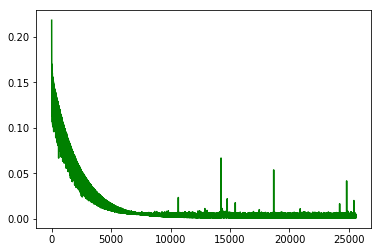

In [11]:
epochs = 100
batch_size = 2
A = []
start_time = datetime.datetime.now()
model = unet()
for e in range(epochs):
    batches = 0
    for x_batch, y_batch in gen_traindata(img, batch_size):
        loss = model.train_on_batch(x_batch, y_batch)
        A.append(abs(float(loss[0])))
        batches += 1
        elapsed_time = datetime.datetime.now() - start_time
        print("[Epoch %d/%d] [Batch %d/%d] [loss: %f] time: %s" %
              (e, epochs,
               batches, int(1000 / batch_size),
               loss[0], elapsed_time))
        monitor(e, batch_size, batches, model, test_tem_path, monitor_path)
                
model.save(filepath="D:/QLY/denoise/model/model_N2N_20201101.hdf5")
#model.load_weights('model_N2N_2020102206.hdf5')

A = np.array(A)
B = np.array(range(len(A)))
draw_loss(B, A, "D:/QLY/denoise/loss/1101.png")

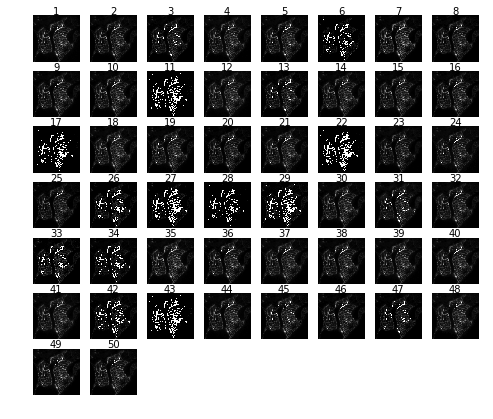

In [12]:
batchDraw(monitor_path, 50)